# Capstone -- Analysis of Baseball Eras and Whether they are valid by stats or cultural significance.
-- Alfred Emmanuel Lopez Sr.

For my capstone, I have decide to dig into the baseball data I found from http://www.seanlahman.com/baseball-archive/statistics/. It is a collection of regularly maintained csv files that list a multitude of baseball stats from 1871 to 2017.

### Problem Statement
- Are there true trends in eras referred by baseball writers and historians?

-- 19th Century Era  1876-1900,
-- Dead Ball Era  1901-1919,
-- Lively Ball Era  1920-1941,
-- Integration Era  1942-1960,
-- Expansion Era  1961-1976,
-- Free Agency Era  1977- 1993,
-- Long Ball Era  1994- 2005

- If these overall trends are true, how can we use this data to predict future eras and what are the best kind of players to draft, sign, or trade for to build a successful team?

### Evaluating
- I will visually look over a lot of data in clusters by years, by teams, and by players to see if there are trends on any levels. I am mostly concerned with the trends that will emerge from the groupings by years, but will look at other groupings.

### Modeling
- Ideally, I would use clustering to find the eras, single those periods of time out and then use classification modeling to classify the groups by the periods.
- I will use Random Forest Classifier as my model. It should do a great job with finding similar trends and grouping along those parameters.

### Risk and Assumption
- The risk will always be with overfitting and too complexed and doesn't allow for the human element in sports that allows an indivual or group of individuals to outperform for a period of time.
- If time permits, I would love to merge players by teams by year and add a column for salary. I would love to see if value or expense won out when putting together a winning team. This is particulary valuable in baseball where there is no salary cap.

In [2]:
# Import all the important stuff I might need

import scipy.stats as stats
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

from sklearn.cluster import KMeans, k_means, DBSCAN
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegressionCV
from sklearn.metrics import accuracy_score, mean_squared_error, silhouette_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from statsmodels.tsa.arima_model import ARMA

from datetime import datetime
from datetime import timedelta

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from hdbscan import HDBSCAN

import bokeh
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

plt.style.use('seaborn')
sns.set(style="white")

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# load player data
# not individual stats, but personal info
players = pd.read_csv('./data/People.csv')

#load batting data
batting = pd.read_csv('./data/Batting.csv')

#load post season batting data
batting_post = pd.read_csv('./data/BattingPost.csv')

#load pitching data
pitching = pd.read_csv('./data/Pitching.csv')

#load post season pitching data
pitching_post = pd.read_csv('./data/PitchingPost.csv')

#load salary data
salaries = pd.read_csv('./data/Salaries.csv')

#load team data
teams = pd.read_csv('./data/Teams.csv')

#load fielding data
fielding = pd.read_csv('./data/Fielding.csv')

#load post season fielding data
fielding_post = pd.read_csv('./data/FieldingPost.csv')

In [4]:
#standardize column names
batting.columns = map(str.lower, batting.columns)
batting_post.columns = map(str.lower, batting_post.columns)
pitching.columns = map(str.lower, pitching.columns)
pitching_post.columns = map(str.lower, pitching_post.columns)
salaries.columns = map(str.lower, salaries.columns)
teams.columns = map(str.lower, teams.columns)
fielding.columns = map(str.lower, fielding.columns)
fielding_post.columns = map(str.lower, fielding_post.columns)
players.columns = map(str.lower, players.columns)

In [5]:
#rename 'yearid' column to year for ease
batting.rename(columns={'yearid':'year'}, inplace=True)
batting_post.rename(columns={'yearid':'year'}, inplace=True)
pitching.rename(columns={'yearid': 'year'}, inplace=True)
pitching_post.rename(columns={'yearid': 'year'}, inplace=True)
salaries.rename(columns={'yearid': 'year'}, inplace=True)
teams.rename(columns={'yearid': 'year'}, inplace=True)
fielding.rename(columns={'yearid': 'year'}, inplace=True)
fielding_post.rename(columns={'yearid':'year'}, inplace=True)

In [6]:
# concat post and regular season stats to get a true value for career stats
batting = pd.concat([batting, batting_post], join='inner')
pitching = pd.concat([pitching, pitching_post], join='inner')
fielding = pd.concat([fielding, fielding_post], join='inner')

In [7]:
#use fillna() to replace NaN for years stat wasn't recorded
#need to figure out a way to fix pitching data, since 0 will be beneficaial in a few cases
batting.fillna(value=0, inplace=True)
batting_post.fillna(value=0, inplace=True)
pitching.fillna(value=0, inplace=True)
pitching_post.fillna(value=0, inplace=True)
teams.fillna(value=0, inplace=True)
fielding.fillna(value=0, inplace=True)
fielding_post.fillna(value=0, inplace=True)

In [8]:
batting['period'] = batting['year']
batting['period'].replace(range(1871,1901), 0, inplace=True)
batting['period'].replace(range(1901,1920), 1, inplace=True)
batting['period'].replace(range(1920, 1942), 2, inplace=True)
batting['period'].replace(range(1942, 1961), 3, inplace=True)
batting['period'].replace(range(1961, 1977), 4, inplace=True)
batting['period'].replace(range(1977, 1994), 5, inplace=True)
batting['period'].replace(range(1994, 2006), 6, inplace=True)
batting['period'].replace(range(2006, 2018), 7, inplace=True)

In [9]:
pitching['period'] = pitching['year']
pitching['period'].replace(range(1871, 1901), 0, inplace=True)
pitching['period'].replace(range(1901, 1920), 1, inplace=True)
pitching['period'].replace(range(1920, 1942), 2, inplace=True)
pitching['period'].replace(range(1942, 1961), 3, inplace=True)
pitching['period'].replace(range(1961, 1977), 4, inplace=True)
pitching['period'].replace(range(1977, 1994), 5, inplace=True)
pitching['period'].replace(range(1994, 2006), 6, inplace=True)
pitching['period'].replace(range(2006, 2018), 7, inplace=True)

In [10]:
fielding['period'] = fielding['year']
fielding['period'].replace(range(1871, 1901), 0, inplace=True)
fielding['period'].replace(range(1901, 1920), 1, inplace=True)
fielding['period'].replace(range(1920, 1942), 2, inplace=True)
fielding['period'].replace(range(1942, 1961), 3, inplace=True)
fielding['period'].replace(range(1961, 1977), 4, inplace=True)
fielding['period'].replace(range(1977, 1994), 5, inplace=True)
fielding['period'].replace(range(1994, 2006), 6, inplace=True)
fielding['period'].replace(range(2006, 2018), 7, inplace=True)

In [11]:
#remove player with fewer than 100 at bats for a given year
# will need to re-evaluate number later
batting = batting[batting['ab'] >= 100]

In [12]:
# remove players with fewer than 15 game appearances for a given year
# again, will need to re-evaluate number later
pitching = pitching[pitching['g'] >= 15]

In [13]:
# remove players with fewer than 40 outfield appearances for a given year
# will need to re-evalute later for seasons with less than 162 games.
fielding = fielding[fielding['g'] >= 40]

In [14]:
# create batting average column
# I used basic batting average formula
batting['bavg'] = batting['h']/batting['ab']

In [15]:
# create on base percentage column
batting['obp'] = (batting['h']+batting['bb']+batting['hbp']) / (batting['ab']+batting['bb']+batting['hbp']+batting['sf'])

In [16]:
# create singles column
batting['1b'] = batting['h']-(batting['2b']+batting['3b']+batting['hr'])

In [17]:
# create slugging percentage column
batting['slg'] = (batting['1b']+(2*batting['2b'])+(3*batting['3b'])+(4*batting['hr'])) / batting['ab']

In [18]:
# create on base plus slugging column
batting['ops'] = batting['obp']+batting['slg']

In [19]:
# created estimated pitch count column to see trends over time
# this is an estimate used from metrics found elsewhere
# not an offical stat until 1954
pitching['est_pc'] = 3 * (pitching['h'] + (4 * pitching['bb']) + (3 * pitching['so']) + pitching['wp'])

In [20]:
# created fielding percentage column
fielding['fp%'] = ((fielding['po']+fielding['a']) / (fielding['po']+fielding['a']+fielding['e']))

In [21]:
# created range fielding per game column
fielding['rf/g'] = (fielding['po']+fielding['a']) / fielding['g']

In [22]:
# created walks plus hits per inning pitched
pitching['whip'] = (pitching['bb']+pitching['h']) / (3*pitching['ipouts'])

In [23]:
#round batting average down to 3 significant digits to better group players
batting = round(batting, 3)
pitching = round(pitching, 3)
fielding = round(fielding, 3)

In [24]:
#replace bats and throws with numbers
players['bats'].replace({'R':1, 'L':2, 'B':3,}, inplace=True)
players['throws'].replace({'R':1, 'L':2, 'S':4}, inplace=True)

In [25]:
# We only need certain data from player dataset
# Right =1
# Left =2
#Both =3
#S =4 : find what s means
players = players.groupby('playerid').sum()
players = players[['weight', 'height', 'bats', 'throws']]

## We need major league baseball data!

The National League and American League partnership starts offically in 1903. Since this is considered the top levels of competition in American baseball, we will remove all the other league ids from the main data sets.

In [26]:
batting_al = batting[batting['lgid'] == 'AL']
batting_nl = batting[batting['lgid'] == 'NL']
batting = pd.concat([batting_al, batting_nl], axis=0)

In [27]:
pitching_al = pitching[pitching['lgid'] == 'AL']
pitching_nl = pitching[pitching['lgid'] == 'NL']
pitching = pd.concat([pitching_al, pitching_nl], axis=0)

In [28]:
fielding_al = fielding[fielding['lgid'] == 'AL']
fielding_nl = fielding[fielding['lgid'] == 'NL']
fielding = pd.concat([fielding_al, fielding_nl], axis=0)

In [29]:
teams_al = teams[teams['lgid'] == 'AL']
teams_nl = teams[teams['lgid'] == 'NL']
teams_mlb = pd.concat([teams_al, teams_nl], axis=0).shape

In [30]:
salaries_al = salaries[salaries['lgid'] == 'AL']
salaries_nl = salaries[salaries['lgid'] == 'NL']
salaries = pd.concat([salaries_al, salaries_nl], axis=0)

The players individual data doesn't include teams they played for, which is fine because this dataset will be used to reference player height and weight stats.

## Let's create some new datasets for career stats and stats by year and stats for player by year

### Batting

In [31]:
batters = batting.groupby('playerid').sum()
batters.drop(columns=(['year', 'bavg', 'obp', 'ops', 'slg','period']), inplace=True)
batters['years'] = batting.groupby('playerid')['year'].count()
batters['period'] = batting.groupby('playerid')['period'].mean()
batters['bavg'] = batting.groupby('playerid')['bavg'].mean()
batters['obp'] = batting.groupby('playerid')['obp'].mean()
batters['ops'] = batting.groupby('playerid')['ops'].mean()
batters['slg'] = batting.groupby('playerid')['slg'].mean()
batters = round(batters, 3)

In [32]:
batting_year = batting.groupby('year').sum()
batting_year.drop(columns=(['bavg', 'obp', 'ops', 'slg', 'period']), inplace=True)
batting_year['period'] = batting.groupby('year')['period'].mean()
batting_year['bavg'] = batting.groupby('year')['bavg'].mean()
batting_year['obp'] = batting.groupby('year')['obp'].mean()
batting_year['ops'] = batting.groupby('year')['ops'].mean()
batting_year['slg'] = batting.groupby('year')['slg'].mean()
batting_year = round(batting_year, 3)

In [33]:
batters_years = batting.groupby(['playerid', 'year']).sum()
batters_years.drop(columns=(['bavg', 'obp', 'ops', 'slg', 'period']), inplace=True)
batters_years['period'] = batting.groupby(['playerid', 'year'])['period'].mean()
batters_years['bavg'] = batting.groupby(['playerid', 'year'])['bavg'].mean()
batters_years['obp'] = batting.groupby(['playerid', 'year'])['obp'].mean()
batters_years['ops'] = batting.groupby(['playerid', 'year'])['ops'].mean()
batters_years['slg'] = batting.groupby(['playerid', 'year'])['slg'].mean()
batters_years = round(batters_years, 3)

In [34]:
batting_team = batting.groupby(['teamid']).sum()
batting_team.drop(columns=['year', 'bavg', 'obp', 'ops', 'slg', 'period'], inplace=True)
batting_team['period'] = batting.groupby('teamid')['period'].mean()
batting_team['bavg'] = batting.groupby('teamid')['bavg'].mean()
batting_team['obp'] = batting.groupby('teamid')['obp'].mean()
batting_team['ops'] = batting.groupby('teamid')['ops'].mean()
batting_team['slg'] = batting.groupby('teamid')['slg'].mean()
batting_team = round(batting_team, 3)

In [35]:
batting_team_year = batting.groupby(['teamid', 'year']).sum()
batting_team_year.drop(columns=['bavg', 'obp', 'ops', 'slg', 'period'], inplace=True)
batting_team_year['period'] = batting.groupby(['teamid', 'year'])['period'].mean()
batting_team_year['bavg'] = batting.groupby(['teamid', 'year'])['bavg'].mean()
batting_team_year['obp'] = batting.groupby(['teamid', 'year'])['obp'].mean()
batting_team_year['ops'] = batting.groupby(['teamid', 'year'])['ops'].mean()
batting_team_year['slg'] = batting.groupby(['teamid', 'year'])['slg'].mean()
batting_team_year = round(batting_team_year,3)

### Pitching

In [36]:
pitchers = pitching.groupby('playerid').sum()
pitchers.drop(columns=(['year', 'era', 'whip', 'period']), inplace=True)
pitchers['years'] = pitching.groupby('playerid')['year'].count()
pitchers['period'] = pitching.groupby('playerid')['period'].mean()
pitchers['era'] = pitching.groupby('playerid')['era'].mean()
pitchers['whip'] = pitching.groupby('playerid')['whip'].mean()
pitchers = round(pitchers, 3)

In [37]:
pitching_year = pitching.groupby('year').sum()
pitching_year.drop(columns=(['era','whip', 'period']), inplace=True)
pitching_year['period'] = pitching.groupby('year')['period'].mean()
pitching_year['era'] = pitching.groupby('year')['era'].mean()
pitching_year['whip'] = pitching.groupby('year')['whip'].mean()
pitching_year = round(pitching_year, 3)

In [38]:
pitchers_years = pitching.groupby(['playerid', 'year']).sum()
pitchers_years.drop(columns=(['era','whip', 'period']), inplace=True)
pitchers_years['era'] = pitching.groupby(['playerid', 'year'])['era'].mean()
pitchers_years['period'] = pitching.groupby(['playerid', 'year'])['period'].mean()
pitchers_years['era'] = pitching.groupby(['playerid', 'year'])['whip'].mean()
pitchers_years = round(pitchers_years, 3)

In [39]:
pitching_team = pitching.groupby(['teamid']).sum()
pitching_team.drop(columns=['year', 'era', 'whip', 'period'], inplace=True)
pitching_team['era'] = pitching.groupby('teamid')['era'].mean()
pitching_team['period'] = pitching.groupby('teamid')['period'].mean()
pitching_team['whip'] = pitching.groupby('teamid')['whip'].mean()
pitching_team = round(pitching_team, 3)

In [40]:
pitching_team_year = pitching.groupby(['teamid', 'year']).sum()
pitching_team_year.drop(columns=['era', 'whip', 'period'], inplace=True)
pitching_team_year['era'] = pitching.groupby(['teamid', 'year'])['era'].mean()
pitching_team_year['period'] = pitching.groupby(['teamid', 'year'])['period'].mean()
pitching_team_year['whip'] = pitching.groupby(['teamid', 'year'])['whip'].mean()
pitching_team_year = round(pitching_team_year,3)

### Fielding

In [41]:
fielders = fielding.groupby('playerid').sum()
fielders.drop(columns=(['year', 'fp%', 'rf/g','period']), inplace=True)
fielders['years'] = fielding.groupby('playerid')['year'].count()
fielders['period'] = fielding.groupby('playerid')['period'].mean()
fielders['fp%'] = fielding.groupby('playerid')['fp%'].mean()
fielders['rf/g'] = fielding.groupby('playerid')['rf/g'].mean()
fielders.fillna(value=0, inplace=True)

In [42]:
fielding_year = fielding.groupby(['year']).sum()
fielding_year.drop(['fp%', 'rf/g', 'period'], axis=1, inplace=True)
fielding_year['fp%'] = fielding.groupby('year')['fp%'].mean()
fielding_year['period'] = fielding.groupby('year')['period'].mean()
fielding_year['rf/g'] = fielding.groupby('year')['rf/g'].mean()
fielding_year.fillna(value=0, inplace=True)

In [43]:
fielders_years = fielding.groupby(['playerid', 'year']).sum()
fielders_years.drop(['fp%', 'rf/g','period'], axis=1, inplace=True)
fielders_years['fp%'] = fielding.groupby(['playerid','year'])['fp%'].mean()
fielders_years['period'] = fielding.groupby(['playerid', 'year'])['period'].mean()
fielders_years['rf/g'] = fielding.groupby(['playerid','year'])['rf/g'].mean()
fielders_years.fillna(value=0, inplace=True)

In [44]:
fielding_team = fielding.groupby(['teamid']).sum()
fielding_team.drop(columns=['year', 'fp%', 'rf/g','period'], inplace=True)
fielding_team['fp%'] = fielding.groupby('teamid')['fp%'].mean()
fielding_team['period'] = fielding.groupby('teamid')['period'].mean()
fielding_team['rf/g'] = fielding.groupby('teamid')['rf/g'].mean()
fielding_team = round(fielding_team, 3)

In [45]:
fielding_team_year = fielding.groupby(['teamid', 'year', 'period']).sum()
fielding_team_year.drop(columns=['fp%', 'rf/g'], inplace=True)
fielding_team_year['fp%'] = fielding.groupby(['teamid', 'year'])['fp%'].mean()
fielding_team_year['period'] = fielding.groupby(['teamid', 'year'])['period'].mean()
fielding_team_year['rf/g'] = fielding.groupby(['teamid', 'year'])['rf/g'].mean()
fielding_team_year = round(fielding_team_year,3)

In [46]:
# I will create saved files to open in other notebooks to work on.
# The goal is to have several messy notebooks with one clean notebook with all the data.
import datetime
now = str(datetime.datetime.now())[:10]

In [47]:
batting.to_csv('./data/data/batting', index=True)
batters.to_csv('./data/data/batters', index=True)
batting_year.to_csv('./data/data/batting_year', index=True)
batters_years.to_csv('./data/data/batters_years', index=True)
batting_team.to_csv('./data/data/batting_team', index=True)
batting_team_year.to_csv('./data/data/batting_team_year', index=True)

pitching.to_csv('./data/data/pitching', index=True)
pitchers.to_csv('./data/data/pitchers', index=True)
pitching_year.to_csv('./data/data/pitching_year', index=True)
pitchers_years.to_csv('./data/data/pitchers_years', index=True)
pitching_team.to_csv('./data/data/pitching_team', index=True)
pitching_team_year.to_csv('./data/data/pitching_team_year', index=True)

fielding.to_csv('./data/data/fielding', index=True)
fielders.to_csv('./data/data/fielders', index=True)
fielding_year.to_csv('./data/data/fielding_year', index=True)
fielders_years.to_csv('./data/data/fielders_years', index=True)
fielding_team.to_csv('./data/data/fielding_team', index=True)
fielding_team_year.to_csv('./data/data/fielding_team_year', index=True)

## Let's scale some data for later use

In [48]:
# batting
ss = StandardScaler()
batters_ss = ss.fit_transform(batters)
batters_ss = pd.DataFrame(data=batters_ss, columns=batters.columns)
ss = StandardScaler()
batting_year_ss = ss.fit_transform(batting_year)
batting_year_ss = pd.DataFrame(data=batting_year_ss, columns=batting_year.columns)
ss = StandardScaler()
batters_years_ss = ss.fit_transform(batters_years)
batters_years_ss = pd.DataFrame(data=batters_years_ss, columns=batters_years.columns)
ss = StandardScaler()
batting_team_ss = ss.fit_transform(batting_team)
batting_team_ss = pd.DataFrame(data=batting_team_ss, columns=batting_team.columns)
ss = StandardScaler()
batting_team_year_ss = ss.fit_transform(batting_team_year)
batting_team_year_ss = pd.DataFrame(data=batting_team_year_ss, columns=batting_team_year.columns)

In [49]:
# pitching
ss = StandardScaler()
pitchers_ss = ss.fit_transform(pitchers)
pitchers_ss = pd.DataFrame(data=pitchers_ss, columns=pitchers.columns)
ss = StandardScaler()
pitching_year_ss = ss.fit_transform(pitching_year)
pitching_year_ss = pd.DataFrame(data=pitching_year_ss, columns=pitching_year.columns)
ss = StandardScaler()
pitchers_years_ss = ss.fit_transform(pitchers_years)
pitchers_years_ss = pd.DataFrame(data=pitchers_years_ss, columns=pitchers_years.columns)
ss = StandardScaler()
pitching_team_ss = ss.fit_transform(pitching_team)
pitching_team_ss = pd.DataFrame(data=pitching_team_ss, columns=pitching_team.columns)
ss = StandardScaler()
pitching_team_year_ss = ss.fit_transform(pitching_team_year)
pitching_team_year_ss = pd.DataFrame(data=pitching_team_year_ss, columns=pitching_team_year.columns)

In [50]:
# fieldings
ss = StandardScaler()
fielders_ss = ss.fit_transform(fielders)
fielders_ss = pd.DataFrame(data=fielders_ss, columns=fielders.columns)
ss = StandardScaler()
fielding_year_ss = ss.fit_transform(fielding_year)
fielding_year_ss = pd.DataFrame(data=fielding_year_ss, columns=fielding_year.columns)
ss = StandardScaler()
fielders_years_ss = ss.fit_transform(fielders_years)
fielders_years_ss = pd.DataFrame(data=fielders_years_ss, columns=fielders_years.columns)
ss = StandardScaler()
fielding_team_ss = ss.fit_transform(fielding_team)
fielding_team_ss = pd.DataFrame(data=fielding_team_ss, columns=fielding_team.columns)
ss = StandardScaler()
fielding_team_year_ss = ss.fit_transform(fielding_team_year)
fielding_team_year_ss = pd.DataFrame(data=fielding_team_year_ss, columns=fielding_team_year.columns)

## Let's look at some stats -- Basic EDA

This is really just to check how my data looks. I am printing out the top 10 players for several categories. This can easily be visually inspected to make sure I didn't eliminate too much data earlier.

In [51]:
fielding.shape

(39648, 18)

### Batting

In [52]:
# individual batters over career
for each in batters.columns:
    print()
    print(each)
    print(batters[each].sort_values(ascending=False).head(10))


g
playerid
rosepe01     3536
yastrca01    3308
aaronha01    3298
cobbty01     3035
henderi01    3020
murraed02    3017
musiast01    3014
ripkeca01    2978
mayswi01     2973
bondsba01    2972
Name: g, dtype: int64

ab
playerid
rosepe01     13957
aaronha01    12364
yastrca01    11988
ripkeca01    11512
cobbty01     11434
murraed02    11329
jeterde01    11084
yountro01    11008
winfida01    10942
musiast01    10925
Name: ab, dtype: int64

r
playerid
henderi01    2271
cobbty01     2246
bondsba01    2219
aaronha01    2174
rosepe01     2156
ruthba01     2144
mayswi01     2054
rodrial01    2017
musiast01    1941
jeterde01    1910
Name: r, dtype: int64

h
playerid
rosepe01     4221
cobbty01     4189
aaronha01    3771
musiast01    3610
speaktr01    3511
jeterde01    3441
wagneho01    3420
yastrca01    3419
molitpa01    3309
collied01    3293
Name: h, dtype: int64

2b
playerid
speaktr01    792
rosepe01     737
cobbty01     724
musiast01    721
biggicr01    668
brettge01    663
lajoina01    657


In [53]:
for each in batters_years.columns:
    print()
    print(each)
    print(batters_years[each].sort_values(ascending=False).head(10))


g
playerid   year
willsma01  1962    165
paganjo01  1962    164
tovarce01  1967    164
santoro01  1965    164
willibi01  1965    164
bankser01  1965    163
matsuhi01  2003    163
riceji01   1978    163
oliveal01  1980    163
colavro01  1961    163
Name: g, dtype: int64

ab
playerid   year
rolliji01  2007    716
wilsowi02  1980    705
suzukic01  2004    704
samueju01  1984    701
pierrju01  2006    699
cashda01   1975    699
alouma01   1969    698
reyesjo01  2005    696
soriaal01  2002    696
jensewo01  1936    696
Name: ab, dtype: int64

r
playerid   year
hamilbi01  1894    198
ruthba01   1921    177
gehrilo01  1936    167
hamilbi01  1895    166
kellejo01  1894    165
keelewi01  1894    165
ruthba01   1928    163
gehrilo01  1931    163
keelewi01  1895    162
burkeje01  1896    160
Name: r, dtype: int64

h
playerid   year
suzukic01  2004    262
sislege01  1920    257
terrybi01  1930    254
odoulle01  1929    254
simmoal01  1925    253
hornsro01  1922    250
kleinch01  1930    250
cobbt

In [54]:
for each in batting_year.columns:
    print()
    print(each)
    print(batting_year[each].sort_values(ascending=False).head(10))


g
year
1998    46986
1999    46932
2000    46606
2003    46357
2007    46276
2002    46199
2008    46125
2005    45975
2013    45906
2001    45893
Name: g, dtype: int64

ab
year
2007    153885
1999    153319
2006    153281
1998    153208
2003    153106
2008    152878
2000    152696
2005    152641
2013    152579
2009    152514
Name: ab, dtype: int64

r
year
2000    23433
1999    23329
2006    22252
2004    21952
2007    21888
1998    21880
2001    21784
2003    21674
1996    21347
2008    21340
Name: r, dtype: int64

h
year
1999    42626
2006    42374
2000    42326
2007    42223
1998    41785
2004    41704
2003    41464
2005    41367
2008    41315
2001    41055
Name: h, dtype: int64

2b
year
2007    8684
2006    8616
2008    8528
2000    8399
2004    8385
2005    8373
2003    8354
2001    8299
1999    8298
2009    8245
Name: 2b, dtype: int64

3b
year
1921    1275
1894    1241
1912    1240
1911    1216
1930    1197
1920    1191
1901    1181
1922    1163
1913    1152
1915    1118
Name: 3

In [55]:
for each in batting_team.columns:
    print()
    print(each)
    print(batting_team[each].sort_values(ascending=False).head(10))


g
teamid
CHN    190217
PHI    187101
PIT    181506
CIN    179467
SLN    176126
DET    169008
CHA    166876
CLE    166039
BOS    165147
NYA    163007
Name: g, dtype: int64

ab
teamid
CHN    644551
PHI    629713
PIT    614525
CIN    598462
SLN    588523
DET    569736
BOS    565185
CLE    561973
CHA    559145
NYA    554351
Name: ab, dtype: int64

r
teamid
CHN    90450
PHI    84941
PIT    83259
NYA    81213
CIN    80605
SLN    80487
DET    79383
BOS    79085
CLE    76891
CHA    73882
Name: r, dtype: int64

h
teamid
CHN    175214
PHI    170074
PIT    168937
SLN    163130
CIN    162247
BOS    155120
DET    155112
CLE    153291
NYA    151748
CHA    149390
Name: h, dtype: int64

2b
teamid
CHN    29590
PHI    29447
BOS    28949
PIT    27890
SLN    27780
CIN    27468
CLE    27402
DET    26352
NYA    25197
CHA    24780
Name: 2b, dtype: int64

3b
teamid
PIT    7812
CHN    6726
SLN    6459
CIN    6315
PHI    6186
DET    5684
BOS    5117
CHA    5113
NYA    5044
CLE    4987
Name: 3b, dtype: int64

h

In [56]:
for each in batting_team_year.columns:
    print()
    print(each)
    print(batting_team_year[each].sort_values(ascending=False).head(10))


g
teamid  year
TEX     1980    1832
CHA     1983    1803
MIN     1978    1797
DET     1984    1796
BAL     1984    1793
SEA     1991    1782
KCA     1978    1779
TOR     1984    1779
TEX     1987    1776
OAK     1977    1773
Name: g, dtype: int64

ab
teamid  year
BOS     2003    5624
TEX     1998    5603
BOS     1997    5588
MIN     2009    5585
ML4     1982    5571
OAK     1988    5559
DET     1978    5559
        2000    5543
TOR     1984    5543
LAA     2005    5533
Name: ab, dtype: int64

r
teamid  year
BSN     1894    1172
PHI     1894    1159
BLN     1894    1108
PHI     1895    1034
NYA     1931    1004
BSN     1897     998
        1893     995
PHI     1893     987
NYA     1936     986
CHN     1894     982
Name: r, dtype: int64

h
teamid  year
PHI     1894    1753
        1930    1680
NY1     1930    1654
BOS     1997    1646
        2003    1634
TEX     1998    1624
SLN     1930    1602
PHI     1895    1599
CHN     1930    1597
CLE     1996    1597
Name: h, dtype: int64

2b
te

### Pitching

In [57]:
# individual pitchers over career
for each in pitchers.columns:
    print()
    print(each)
    print(pitchers[each].sort_values(ascending=False).head(10))


w
playerid
youngcy01    504
johnswa01    412
mathech01    369
alexape01    368
spahnwa01    363
nichoki01    360
clemero02    354
maddugr01    345
carltst01    320
ryanno01     319
Name: w, dtype: int64

l
playerid
youngcy01    307
ryanno01     286
niekrph01    272
johnswa01    270
perryga01    256
galvipu01    255
suttodo01    253
powelja01    253
rixeyep01    251
spahnwa01    245
Name: l, dtype: int64

g
playerid
oroscje01    1230
stantmi02    1170
francjo01    1119
riverma01    1106
plesada01    1064
eckerde01    1062
timlimi01    1058
tekulke01    1039
wilheho01    1036
hawkila01    1029
Name: g, dtype: int64

gs
playerid
youngcy01    797
ryanno01     759
suttodo01    744
maddugr01    716
niekrph01    712
clemero02    707
carltst01    676
spahnwa01    663
perryga01    661
glavito02    660
Name: gs, dtype: int64

cg
playerid
youngcy01    737
galvipu01    538
nichoki01    526
welchmi01    525
johnswa01    520
clarkjo01    471
radboch01    452
alexape01    430
mathech01    428
mccorj

In [58]:
for each in pitchers_years.columns:
    print()
    print(each)
    print(pitchers_years[each].sort_values(ascending=False).head(10))


w
playerid   year
radboch01  1884    59
clarkjo01  1885    53
           1889    49
radboch01  1883    48
buffich01  1884    48
spaldal01  1876    47
wardjo01   1879    47
galvipu01  1883    46
           1884    46
mccorji01  1880    45
Name: w, dtype: int64

l
playerid   year
colemjo01  1883    48
whitewi01  1880    42
mccorji01  1879    40
bradlge01  1879    40
cobbge01   1892    37
wiedmst01  1886    36
hutchbi01  1892    36
donahre01  1897    35
galvipu01  1880    35
devliji01  1876    35
Name: l, dtype: int64

g
playerid   year
marshmi01  1974    106
tekulke01  1979     94
torresa01  2006     94
felicpe01  2010     92
marshmi01  1973     92
tekulke01  1978     91
           1987     90
grangwa01  1969     90
marshmi01  1979     90
quantpa01  2003     89
Name: g, dtype: int64

gs
playerid   year
galvipu01  1883    75
whitewi01  1879    75
mccorji01  1880    74
radboch01  1884    73
clarkjo01  1889    72
galvipu01  1884    72
clarkjo01  1885    70
hutchbi01  1892    70
radboch01  

In [59]:
for each in pitching_year.columns:
    print()
    print(each)
    print(pitching_year[each].sort_values(ascending=False).head(10))


w
year
1999    2292
2004    2270
2005    2268
2002    2262
1998    2257
2010    2247
2001    2246
2003    2240
2011    2230
2008    2229
Name: w, dtype: int64

l
year
1999    2218
2005    2209
2010    2177
1998    2160
2001    2142
2002    2138
2004    2136
2003    2123
2011    2123
2000    2119
Name: l, dtype: int64

g
year
2017    18373
2016    18063
2015    17930
2012    17680
2014    17530
2007    17463
2013    17412
2010    17229
2008    17218
2009    17211
Name: g, dtype: int64

gs
year
1999    4446
2005    4403
2010    4342
1998    4324
2002    4289
2004    4280
2011    4255
2001    4255
2003    4251
2000    4250
Name: gs, dtype: int64

cg
year
1904    2016
1905    1845
1906    1778
1901    1712
1903    1704
1902    1695
1907    1683
1908    1568
1898    1455
1892    1454
Name: cg, dtype: int64

sho
year
1972    293
1968    276
1908    271
1906    266
1907    263
1909    262
1971    259
1976    253
1969    240
1917    240
Name: sho, dtype: int64

sv
year
2015    1271
2016    12

In [60]:
for each in pitching_team.columns:
    print()
    print(each)
    print(pitching_team[each].sort_values(ascending=False).head(10))


w
teamid
CHN    10167
PIT     9497
NYA     9447
SLN     9295
CIN     9293
PHI     8913
BOS     8822
DET     8710
CLE     8694
CHA     8679
Name: w, dtype: int64

l
teamid
PHI    9617
CHN    9427
PIT    8903
CIN    8829
SLN    8514
CHA    8316
DET    8112
CLE    7923
BOS    7910
NYA    6917
Name: l, dtype: int64

g
teamid
CHN    45850
SLN    43721
PIT    43684
PHI    43435
CIN    43048
CLE    40054
CHA    39896
BOS    39514
DET    39228
NYA    37894
Name: g, dtype: int64

gs
teamid
CHN    19605
PIT    18386
PHI    18371
CIN    18055
SLN    17774
CHA    16938
DET    16812
BOS    16618
CLE    16563
NYA    16260
Name: gs, dtype: int64

cg
teamid
CHN    7751
PHI    7051
PIT    6749
CIN    6540
BSN    6508
SLN    6301
DET    5896
NY1    5869
CLE    5699
CHA    5694
Name: cg, dtype: int64

sho
teamid
CHN    1125
PIT    1009
PHI     986
SLN     978
CHA     972
CIN     968
NYA     935
CLE     924
DET     874
BOS     872
Name: sho, dtype: int64

sv
teamid
NYA    3205
CHA    2951
CIN    2941
SLN

In [61]:
for each in pitching_team_year.columns:
    print()
    print(each)
    print(pitching_team_year[each].sort_values(ascending=False).head(10))


w
teamid  year
SEA     2001    111
NYA     1927    110
CLE     1954    109
NYA     1998    108
BAL     1969    108
        1970    108
PIT     1909    107
CHN     1907    107
NYA     1961    106
NY1     1904    106
Name: w, dtype: int64

l
teamid  year
DET     2003    116
NYN     1962    113
BSN     1935    110
NYN     1963    109
PHI     1941    105
        1961    105
HOU     2013    103
NYN     1965    102
PHI     1942    102
SEA     1978    102
Name: l, dtype: int64

g
teamid  year
CLE     2014    699
MIA     2017    690
SFN     2016    689
ARI     2016    686
COL     2012    686
        2017    686
LAN     2016    680
SFN     2015    679
COL     2015    673
NYN     2008    672
Name: g, dtype: int64

gs
teamid  year
LAN     1962    165
MIN     1967    164
BAL     1961    163
OAK     1968    163
BAL     1982    163
DET     1967    163
CIN     1964    163
SFN     1998    163
PIT     1965    163
LAN     1980    163
Name: gs, dtype: int64

cg
teamid  year
BOS     1904    148
CLE     1

### Fielding

In [62]:
# individual fielding over career
for each in fielders.columns:
    print()
    print(each)
    print(fielders[each].sort_values(ascending=False).head(10))


g
playerid
rosepe01     3333
ripkeca01    2950
cobbty01     2934
aaronha01    2921
bondsba01    2861
mayswi01     2842
robinbr01    2835
musiast01    2825
henderi01    2766
biggicr01    2762
Name: g, dtype: int64

gs
playerid
rosepe01     3277.0
ripkeca01    2943.0
aaronha01    2898.0
bondsba01    2797.0
robinbr01    2765.0
henderi01    2699.0
biggicr01    2690.0
yountro01    2677.0
beltrad01    2643.0
jeterde01    2634.0
Name: gs, dtype: float64

innouts
playerid
rosepe01     86207.0
ripkeca01    77456.0
aaronha01    76343.0
robinbr01    74377.0
bondsba01    72604.0
biggicr01    70592.0
yountro01    70373.0
mayswi01     69845.0
beltrad01    69759.0
henderi01    69651.0
Name: innouts, dtype: float64

po
playerid
becklja01    22006
ansonca01    21067
murraed02    20842
grimmch01    20269
mcinnst01    19961
koneted01    19825
daubeja01    19634
vernomi01    19497
gehrilo01    19384
kuheljo01    19208
Name: po, dtype: int64

a
playerid
maranra01    8614
smithoz01    8375
ripkeca01    816

In [63]:
for each in fielders_years.columns:
    print()
    print(each)
    print(fielders_years[each].sort_values(ascending=False).head(10))


g
playerid   year
gilliji01  1962    203
cantujo01  2008    195
tenacge01  1975    193
perezto01  1971    192
coninje01  1993    190
gallemi01  1991    190
mcauldi01  1967    188
flynndo01  1978    188
schumsk01  2009    187
runnepe01  1960    186
Name: g, dtype: int64

gs
playerid   year
willibi01  1965    164.0
santoro01  1965    164.0
willsma01  1962    164.0
paganjo01  1962    164.0
robinbr01  1964    163.0
willibi01  1968    163.0
rosepe01   1974    163.0
cardele01  1964    163.0
killeha01  1969    162.0
mazerbi01  1966    162.0
Name: gs, dtype: float64

innouts
playerid   year
russebi01  1973    4469.0
bandosa01  1969    4442.0
morenom01  1979    4438.0
santoro01  1965    4416.0
willibi01  1965    4416.0
garvest01  1976    4394.0
hansero02  1965    4391.0
perezto01  1968    4390.0
gonzaad01  2007    4388.0
whitebi03  1963    4384.0
Name: innouts, dtype: float64

po
playerid   year
donahji02  1907    1846
kellyge01  1920    1759
todtph01   1926    1755
pippwa01   1926    1710
don

In [64]:
for each in fielding_year.columns:
    print()
    print(each)
    print(fielding_year[each].sort_values(ascending=False).head(10))


g
year
2007    47233
1999    46695
2008    46532
2010    46163
2009    46161
2006    46156
1998    46128
2004    46057
2017    45931
2013    45874
Name: g, dtype: int64

gs
year
1998    34637.0
1999    34606.0
2007    34276.0
2002    34257.0
2005    34251.0
2000    34141.0
2001    34074.0
2004    33965.0
2006    33911.0
2010    33817.0
Name: gs, dtype: float64

innouts
year
1998    945856.0
1999    942978.0
2007    938720.0
2002    933107.0
2005    932847.0
2004    931003.0
2000    927719.0
2001    927684.0
2010    926696.0
2006    926691.0
Name: innouts, dtype: float64

po
year
1998    112617
2005    111681
1999    111592
2007    111385
2002    111073
2006    110935
2004    110834
2003    110557
2010    110006
2017    109941
Name: po, dtype: int64

a
year
1998    40183
2002    39212
2001    39178
1999    39135
2007    38924
2000    38906
2003    38787
2005    38640
2010    38374
2006    38366
Name: a, dtype: int64

e
year
1892    4357.0
1901    4015.0
1894    3768.0
1904    3665.0
18

In [65]:
for each in fielding_team.columns:
    print()
    print(each)
    print(fielding_team[each].sort_values(ascending=False).head(10))


g
teamid
CHN    177839
PHI    173653
PIT    169279
CIN    169127
SLN    167602
CHA    154748
DET    152171
CLE    151988
BOS    151302
NYA    149447
Name: g, dtype: int64

gs
teamid
PHI    73164.0
BAL    73067.0
CIN    73013.0
BOS    72671.0
SLN    72607.0
DET    72595.0
CHN    72410.0
CHA    72198.0
PIT    72156.0
NYA    71828.0
Name: gs, dtype: float64

innouts
teamid
CHN    2539680.0
PHI    2442353.0
PIT    2336665.0
CIN    2286062.0
SLN    2214605.0
BAL    1988623.0
BOS    1972577.0
CHA    1968152.0
DET    1964176.0
NYA    1954511.0
Name: innouts, dtype: float64

po
teamid
CHN    486858
PHI    475498
PIT    463832
CIN    462539
SLN    451070
BOS    423608
CHA    422651
DET    420806
CLE    419952
NYA    419079
Name: po, dtype: int64

a
teamid
CHN    194610
PHI    183672
PIT    183516
CIN    177437
SLN    175202
CHA    164534
DET    160193
BOS    158614
CLE    158397
NYA    154495
Name: a, dtype: int64

e
teamid
CHN    22755.0
PHI    20403.0
PIT    19209.0
CIN    17289.0
SLN    171

In [66]:
for each in fielding_team_year.columns:
    print()
    print(each)
    print(fielding_team_year[each].sort_values(ascending=False).head(10))


g
teamid  year  period
CHN     2017  7         1854
TBA     2010  7         1845
SFN     2004  6         1842
MON     1996  6         1826
PIT     2002  6         1800
ATL     1999  6         1783
PHI     2008  7         1778
SLN     1999  6         1773
HOU     2007  7         1768
FLO     2008  7         1767
Name: g, dtype: int64

gs
teamid  year  period
LAN     1963  4         1346.0
MIN     1965  4         1318.0
LAN     1969  4         1306.0
MON     1977  5         1298.0
PIT     1970  4         1297.0
MIN     1967  4         1293.0
SFN     1973  4         1293.0
WS2     1969  4         1290.0
KC1     1962  4         1289.0
SFN     1963  4         1288.0
Name: gs, dtype: float64

innouts
teamid  year  period
LAN     1963  4         35976.0
MIN     1969  4         35584.0
MON     1977  5         35497.0
MIN     1965  4         35270.0
PIT     1970  4         35235.0
WS2     1969  4         35177.0
LAN     1965  4         35102.0
        1969  4         35047.0
KCA     1975  4   

We start to see some issues and trends when just printing out list. The raw numbers are a little off for notable stats. This is due to an injury where a player player a small amount of the season and then was out for the rest of the year, failing to hit certain milestones that are used when calculating end of seasons awards.

The reason that these parameters were established was to take away the random guy who pitched five great games, had a near perfect earned run average, and then was injured and never pitched the same away again. The sample size is too small to count his stats for comparision to other players because they will be outliers and skew information more than help our models.

In [67]:
# max batting average for each year
batting.groupby('year').max()[['bavg']].T

year   1876   1877   1878   1879  1880   1881   1882   1883   1884   1885  \
bavg  0.429  0.387  0.358  0.357  0.36  0.399  0.368  0.374  0.354  0.371   

year  ...     2008   2009   2010   2011   2012   2013   2014   2015   2016  \
bavg  ...    0.396  0.365  0.359  0.344  0.362  0.348  0.341  0.338  0.348   

year   2017  
bavg  0.346  

[1 rows x 142 columns]

In [68]:
batting.groupby('year').max()[['hr']].T

year  1876  1877  1878  1879  1880  1881  1882  1883  1884  1885  ...   2008  \
hr       5     4     4     9     6     8     7    10    27    11  ...     48   

year  2009  2010  2011  2012  2013  2014  2015  2016  2017  
hr      47    54    43    44    53    40    47    47    59  

[1 rows x 142 columns]

Let's look at some mean stats. I will look at Homeruns, RBIs, and Hits. We can obviously change these around later once we run PCA to find stats that are highly correlated.
I also placed lines at the periods to help focus attention there.

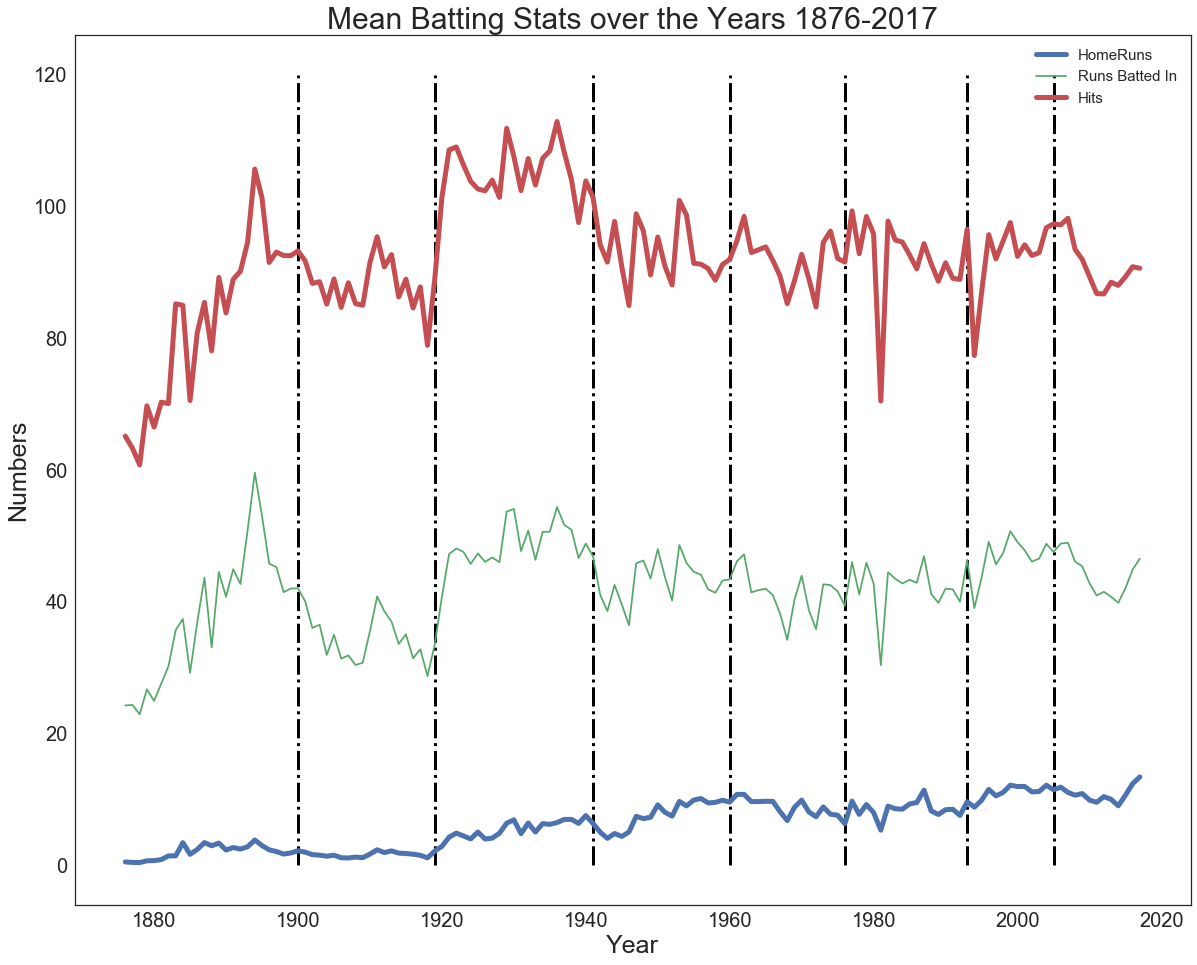

In [69]:
# plotted means hitting stats by year in matplotlib
plt.figure(figsize=(20,16))
plt.plot(batting.groupby('year').mean()[['hr']], label='HomeRuns', linewidth=5)
plt.plot(batting.groupby('year').mean()[['rbi']], label='Runs Batted In')
plt.plot(batting.groupby('year').mean()[['h']], label='Hits', linewidth=5)
plt.vlines(x=1900, ymin=0, ymax=120, linestyles='dashdot', lw=3)
plt.vlines(x=1919, ymin=0, ymax=120, linestyles='dashdot', lw=3)
plt.vlines(x=1941, ymin=0, ymax=120, linestyles='dashdot', lw=3)
plt.vlines(x=1960, ymin=0, ymax=120, linestyles='dashdot', lw=3)
plt.vlines(x=1976, ymin=0, ymax=120, linestyles='dashdot', lw=3)
plt.vlines(x=1993, ymin=0, ymax=120, linestyles='dashdot', lw=3)
plt.vlines(x=2005, ymin=0, ymax=120, linestyles='dashdot', lw=3)
plt.title('Mean Batting Stats over the Years 1876-2017', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Numbers', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend(fontsize=15);

We do see a few trends around certain lines! Well... more around the first few. Let's do the same for pitching stats

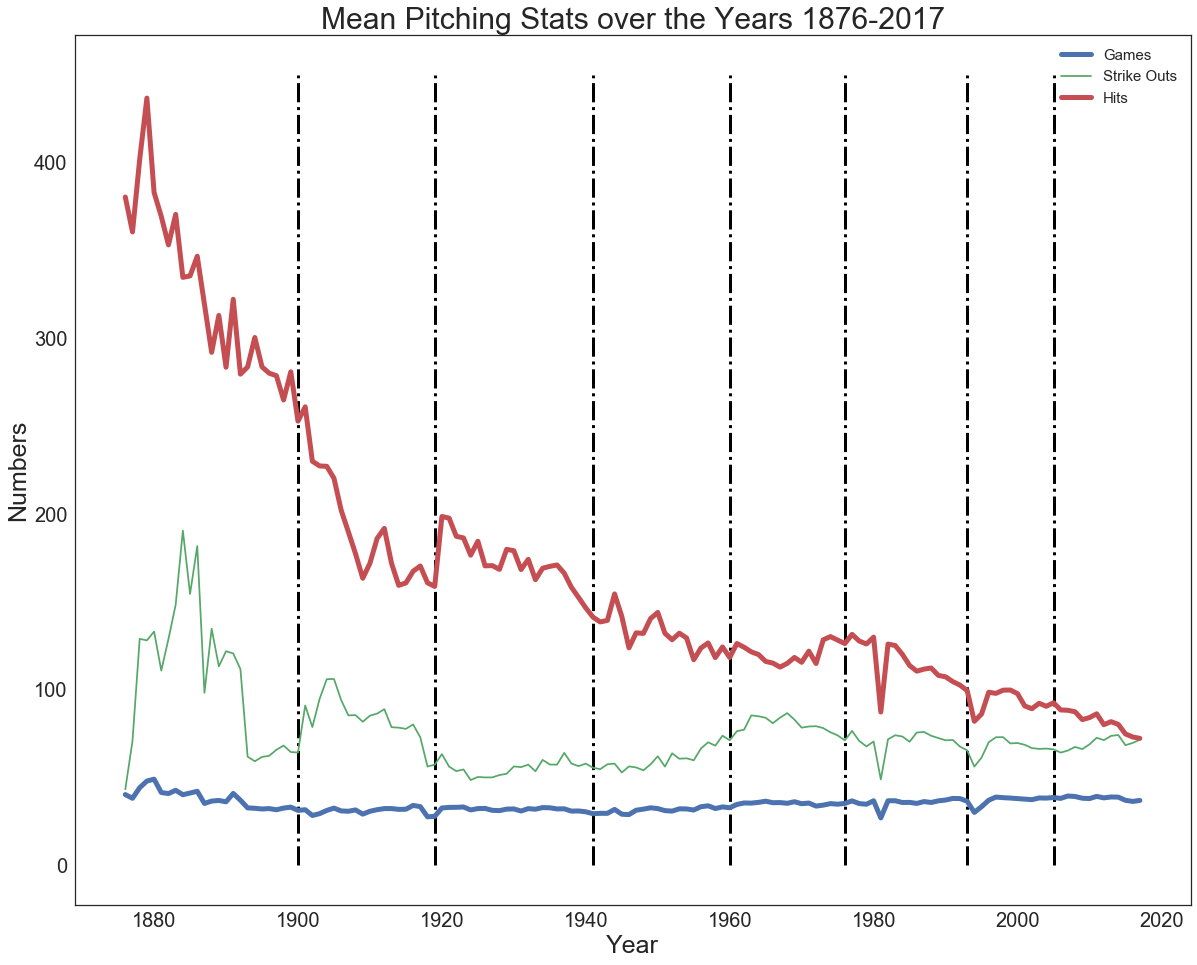

In [70]:
# plotted means hitting stats by year in matplotlib
plt.figure(figsize=(20,16))
plt.plot(pitching.groupby('year').mean()[['g']], label='Games', linewidth=5)
plt.plot(pitching.groupby('year').mean()[['so']], label='Strike Outs')
plt.plot(pitching.groupby('year').mean()[['h']], label='Hits', linewidth=5)
plt.vlines(x=1900, ymin=0, ymax=450, linestyles='dashdot', lw=3)
plt.vlines(x=1919, ymin=0, ymax=450, linestyles='dashdot', lw=3)
plt.vlines(x=1941, ymin=0, ymax=450, linestyles='dashdot', lw=3)
plt.vlines(x=1960, ymin=0, ymax=450, linestyles='dashdot', lw=3)
plt.vlines(x=1976, ymin=0, ymax=450, linestyles='dashdot', lw=3)
plt.vlines(x=1993, ymin=0, ymax=450, linestyles='dashdot', lw=3)
plt.vlines(x=2005, ymin=0, ymax=450, linestyles='dashdot', lw=3)
plt.title('Mean Pitching Stats over the Years 1876-2017', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Numbers', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend(fontsize=15);

Let's look at stats that are percentages for pitchers and batters

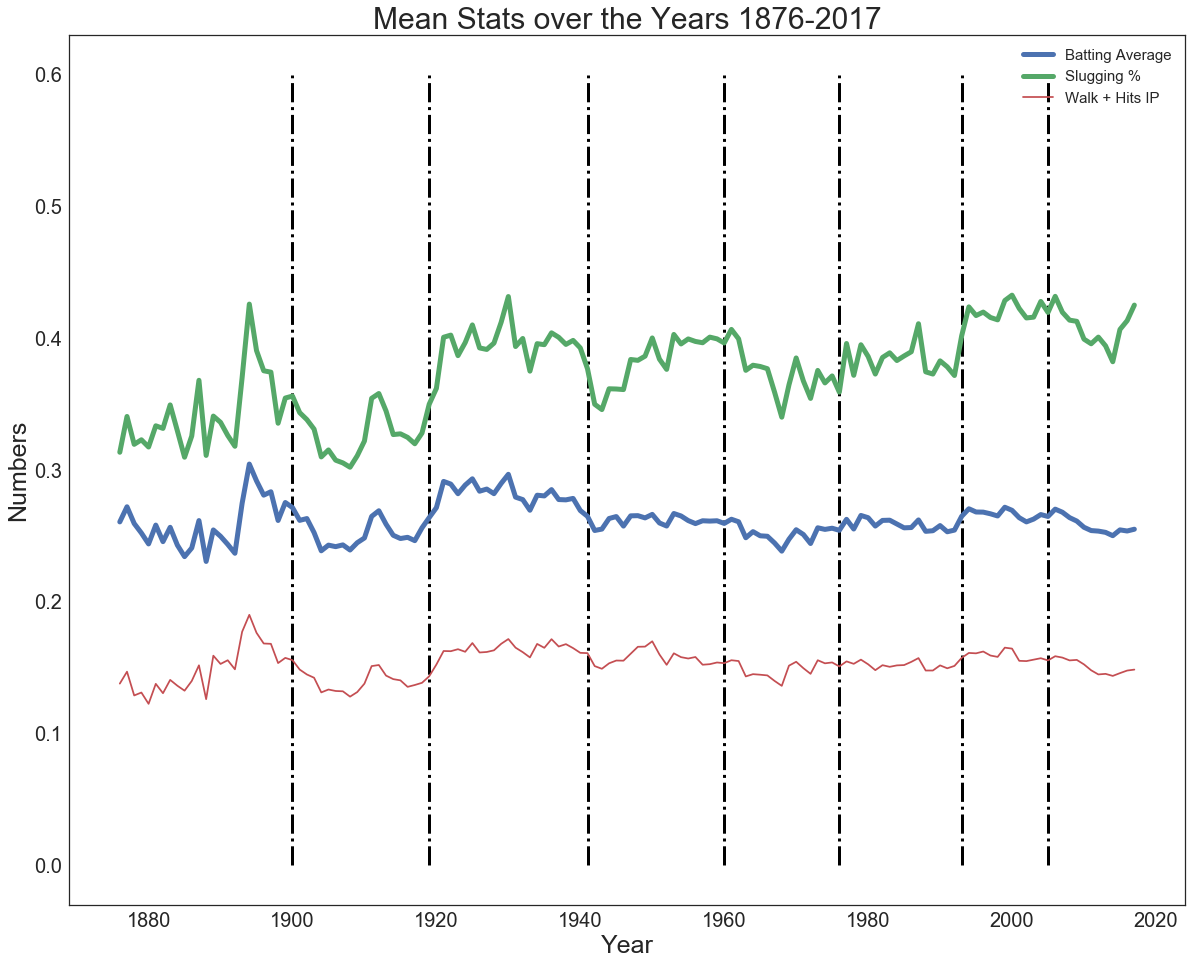

In [71]:
# plotted means hitting stats by year in matplotlib
plt.figure(figsize=(20,16))
plt.plot(batting.groupby('year').mean()[['bavg']], label='Batting Average', linewidth=5)
plt.plot(batting.groupby('year').mean()[['slg']], label='Slugging %', linewidth=5)
plt.plot(pitching.groupby('year').mean()[['whip']], label='Walk + Hits IP')
plt.vlines(x=1900, ymin=0, ymax=.6, linestyles='dashdot', lw=3)
plt.vlines(x=1919, ymin=0, ymax=.6, linestyles='dashdot', lw=3)
plt.vlines(x=1941, ymin=0, ymax=.6, linestyles='dashdot', lw=3)
plt.vlines(x=1960, ymin=0, ymax=.6, linestyles='dashdot', lw=3)
plt.vlines(x=1976, ymin=0, ymax=.6, linestyles='dashdot', lw=3)
plt.vlines(x=1993, ymin=0, ymax=.6, linestyles='dashdot', lw=3)
plt.vlines(x=2005, ymin=0, ymax=.6, linestyles='dashdot', lw=3)
plt.title('Mean Stats over the Years 1876-2017', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Numbers', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend(fontsize=15);

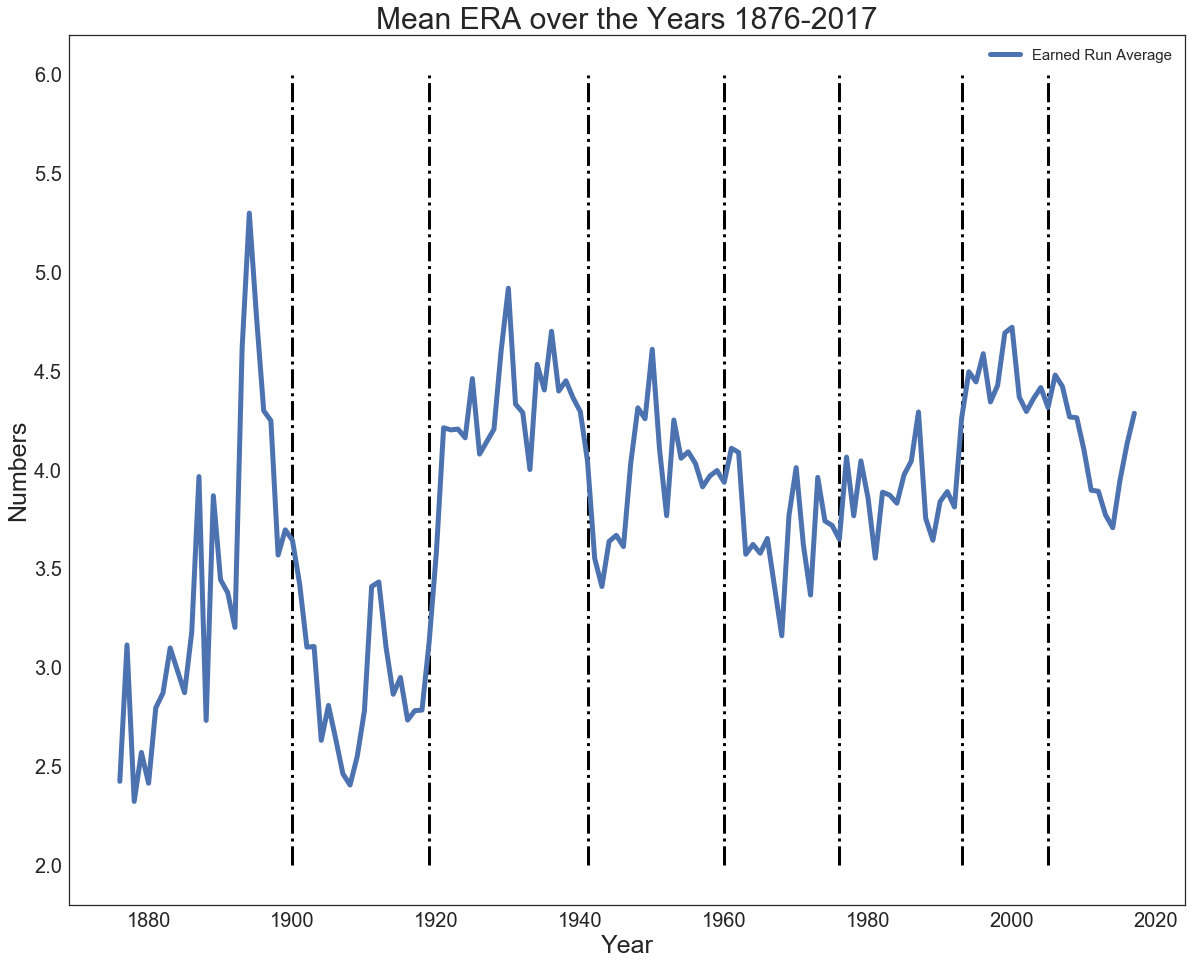

In [72]:
# plotted means hitting stats by year in matplotlib
plt.figure(figsize=(20,16))
plt.plot(pitching.groupby('year').mean()[['era']], label='Earned Run Average', linewidth=5)
plt.vlines(x=1900, ymin=2, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=1919, ymin=2, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=1941, ymin=2, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=1960, ymin=2, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=1976, ymin=2, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=1993, ymin=2, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=2005, ymin=2, ymax=6, linestyles='dashdot', lw=3)
plt.title('Mean ERA over the Years 1876-2017', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Numbers', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend(fontsize=15);

These are helpful. But let's add some density to the graph and regression lines. Let's do it for batters and pitchers for a few different stats.

## Batting Average

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


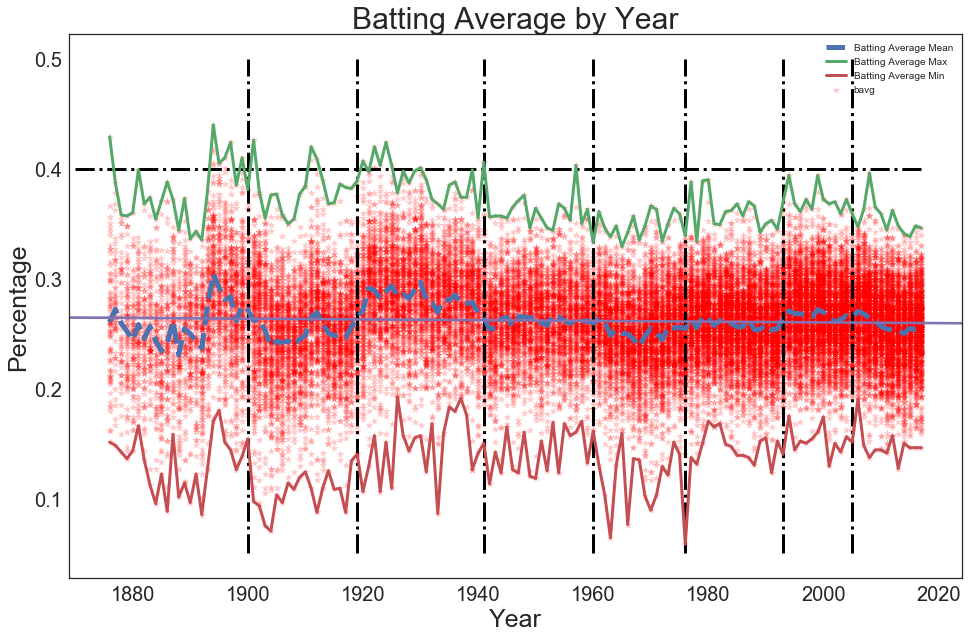

In [76]:
# taking it a step up
# plotting of batting average mean, max, and min with scatter

plt.figure(figsize=(16,10))
plt.scatter(batting['year'],
            batting['bavg'],
            marker='*',
            c='r',
            alpha=.2)
plt.plot(batting.groupby('year').mean()[['bavg']],
        lw=5, linestyle='--', label='Batting Average Mean')
plt.plot(batting.groupby('year').max()[['bavg']],
        lw=3, linestyle='-', label='Batting Average Max')
plt.plot(batting.groupby('year').min()[['bavg']],
        lw=3, linestyle='-', label='Batting Average Min')
ax = sns.regplot(x=batting['year'], y=batting['bavg'],
                scatter=False, logistic=False, order=1)
plt.vlines(x=1900, ymin=0.05, ymax=.5, linestyles='dashdot', lw=3)
plt.vlines(x=1919, ymin=0.05, ymax=.5, linestyles='dashdot', lw=3)
plt.vlines(x=1941, ymin=0.05, ymax=.5, linestyles='dashdot', lw=3)
plt.vlines(x=1960, ymin=0.05, ymax=.5, linestyles='dashdot', lw=3)
plt.vlines(x=1976, ymin=0.05, ymax=.5, linestyles='dashdot', lw=3)
plt.vlines(x=1993, ymin=0.05, ymax=.5, linestyles='dashdot', lw=3)
plt.vlines(x=2005, ymin=0.05, ymax=.5, linestyles='dashdot', lw=3)
plt.hlines(y=0.4, xmin=1870, xmax=2017, linestyles='dashdot', lw=3)
plt.title('Batting Average by Year', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Percentage', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend();

## Earned Run Average

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


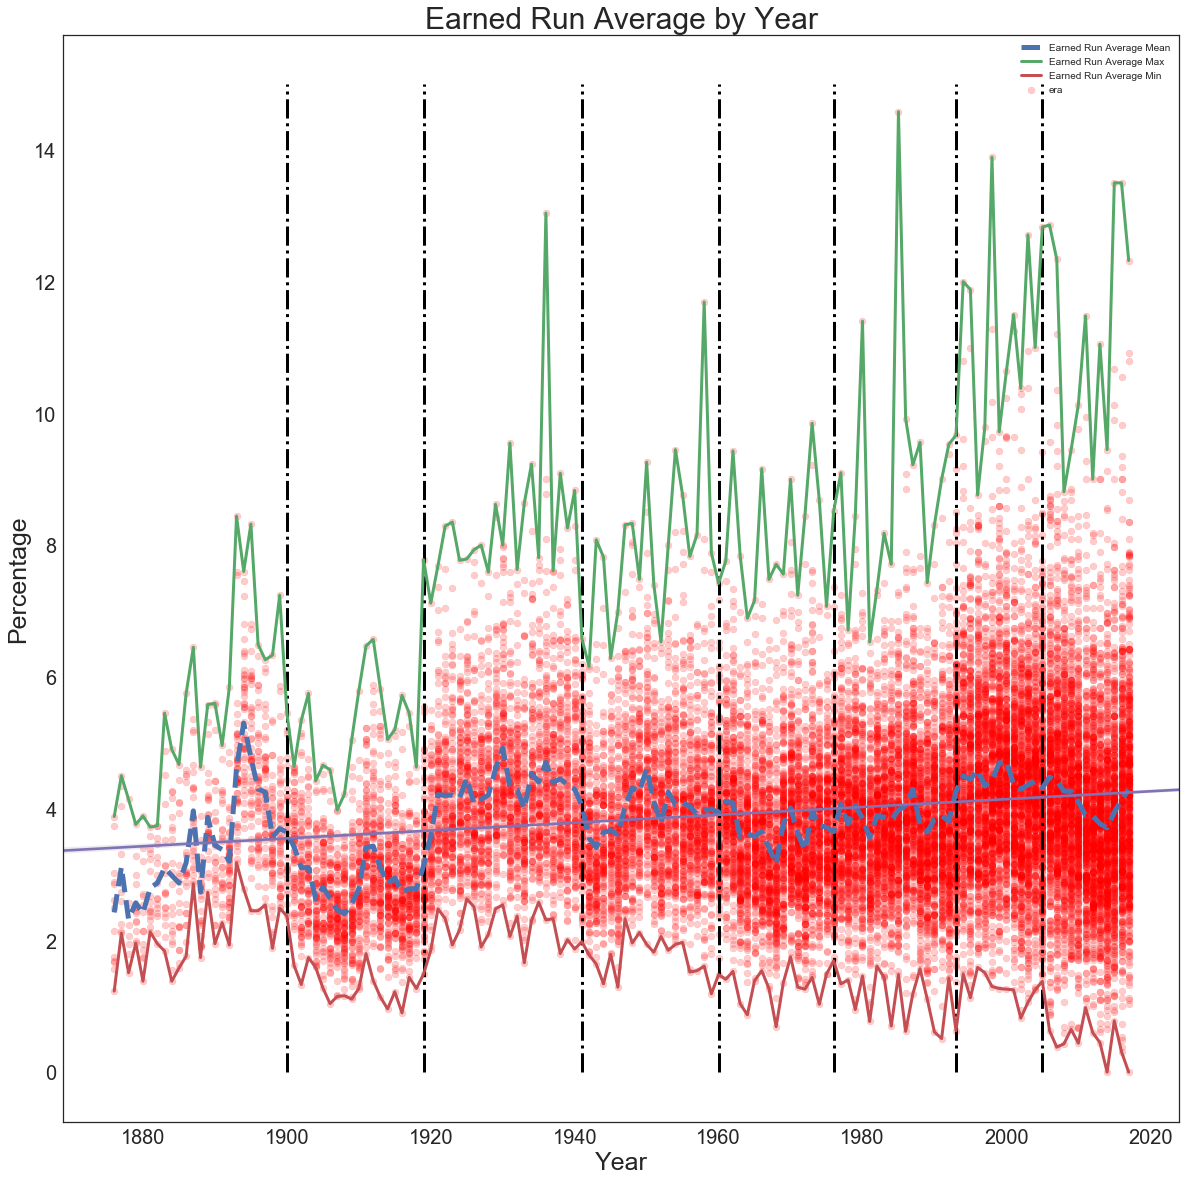

In [168]:
plt.figure(figsize=(20,20))
plt.scatter(pitching['year'],
            pitching['era'],
            marker='o',
            c='r',
            alpha=.2)
plt.plot(pitching.groupby('year').mean()[['era']],
        lw=5, linestyle='--', label='Earned Run Average Mean')
plt.plot(pitching.groupby('year').max()[['era']],
        lw=3, linestyle='-', label='Earned Run Average Max')
plt.plot(pitching.groupby('year').min()[['era']],
        lw=3, linestyle='-', label='Earned Run Average Min')
ax = sns.regplot(x=pitching['year'], y=pitching['era'],
                scatter=False, logistic=False, order=1)
plt.vlines(x=1900, ymin=0, ymax=15, linestyles='dashdot', lw=3)
plt.vlines(x=1919, ymin=0, ymax=15, linestyles='dashdot', lw=3)
plt.vlines(x=1941, ymin=0, ymax=15, linestyles='dashdot', lw=3)
plt.vlines(x=1960, ymin=0, ymax=15, linestyles='dashdot', lw=3)
plt.vlines(x=1976, ymin=0, ymax=15, linestyles='dashdot', lw=3)
plt.vlines(x=1993, ymin=0, ymax=15, linestyles='dashdot', lw=3)
plt.vlines(x=2005, ymin=0, ymax=15, linestyles='dashdot', lw=3)
# plt.hlines(y=0.4, xmin=1870, xmax=2020, linestyles='dashdot', lw=3)
plt.title('Earned Run Average by Year', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Percentage', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend();

And now let's stats by comparison

## Batting

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


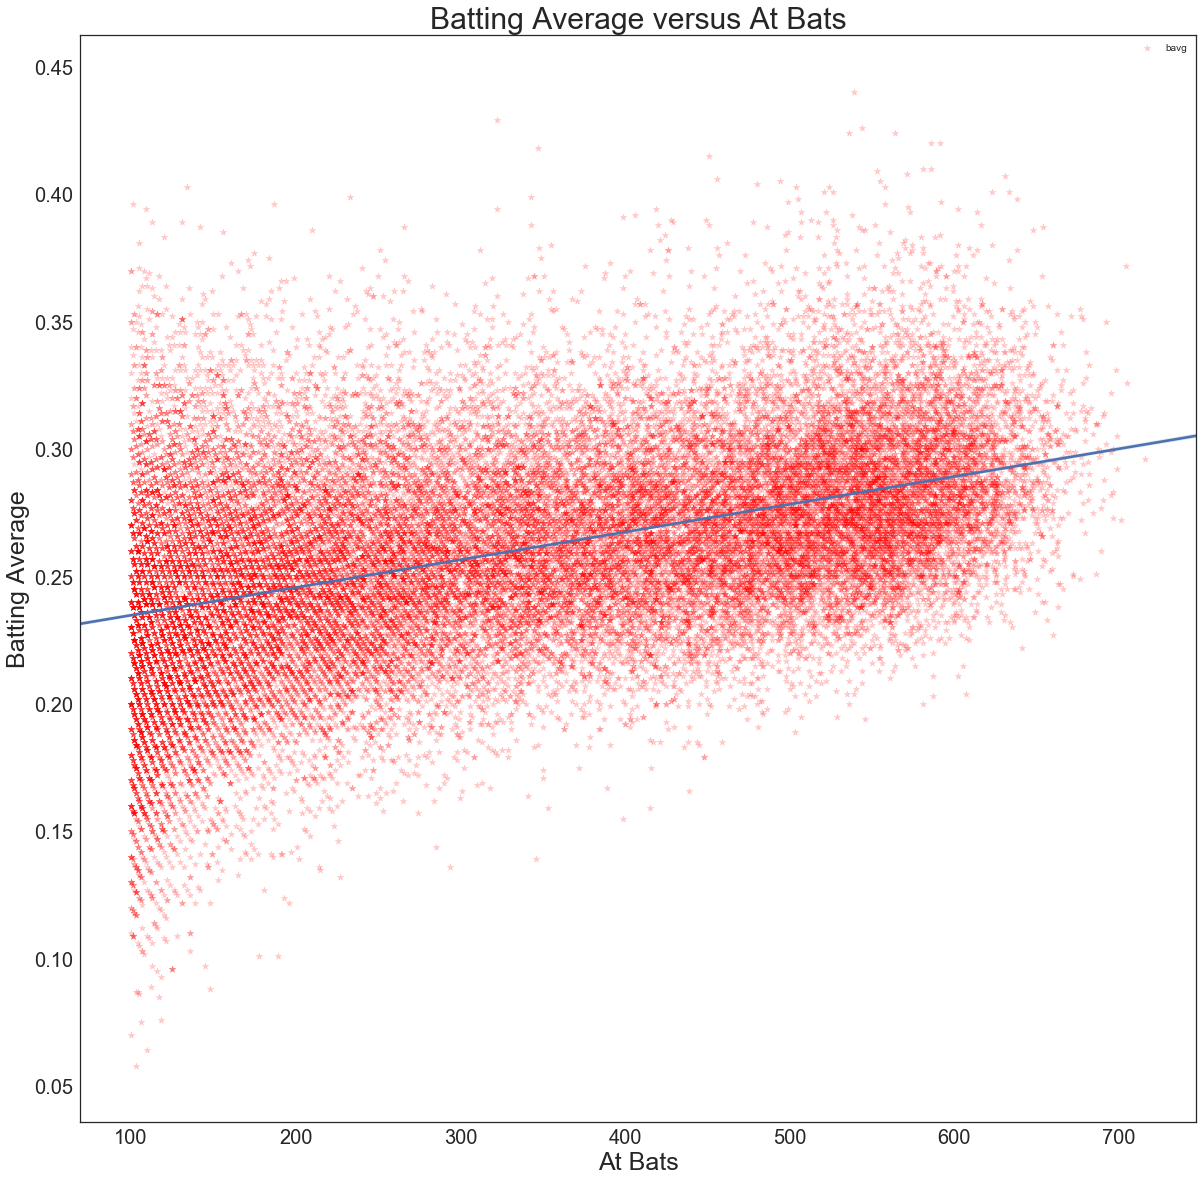

In [169]:
plt.figure(figsize=(20,20))
plt.scatter(batting['ab'],
            batting['bavg'],
            marker='*',
            c='r',
            alpha=.2)
ax = sns.regplot(x=batting['ab'], y=batting['bavg'],
                scatter=False, logistic=False, order=1)
plt.title('Batting Average versus At Bats', fontsize=30)
plt.xlabel('At Bats', fontsize=25)
plt.ylabel('Batting Average', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend();

## Pitching

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


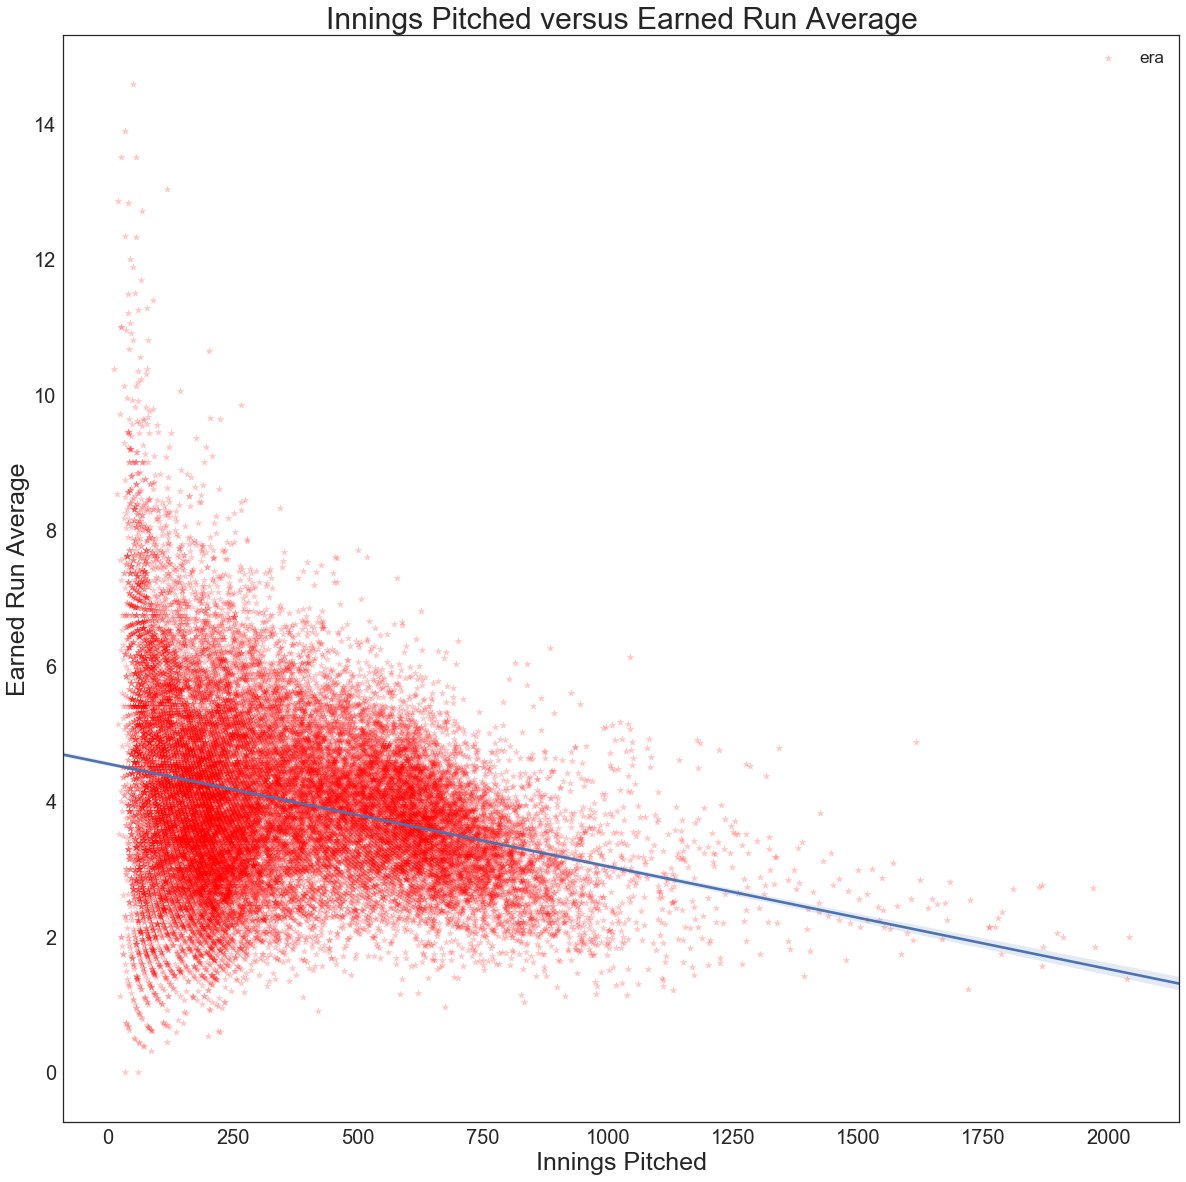

In [170]:
plt.figure(figsize=(20,20))
plt.scatter(pitching['ipouts'],
            pitching['era'],
            marker='*',
            c='r',
            alpha=.2)
ax = sns.regplot(x=pitching['ipouts'], y=pitching['era'],
                scatter=False, logistic=False, order=1)
plt.title('Innings Pitched versus Earned Run Average', fontsize=30)
plt.xlabel('Innings Pitched', fontsize=25)
plt.ylabel('Earned Run Average', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend(fontsize='xx-large');

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


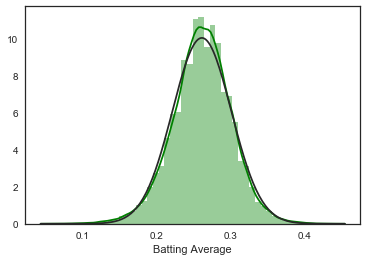

In [171]:
ax = sns.distplot(batting['bavg'],
                  hist=True,
            color = 'g',
            axlabel='Batting Average',
            fit= stats.norm)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<function matplotlib.pyplot.show(*args, **kw)>

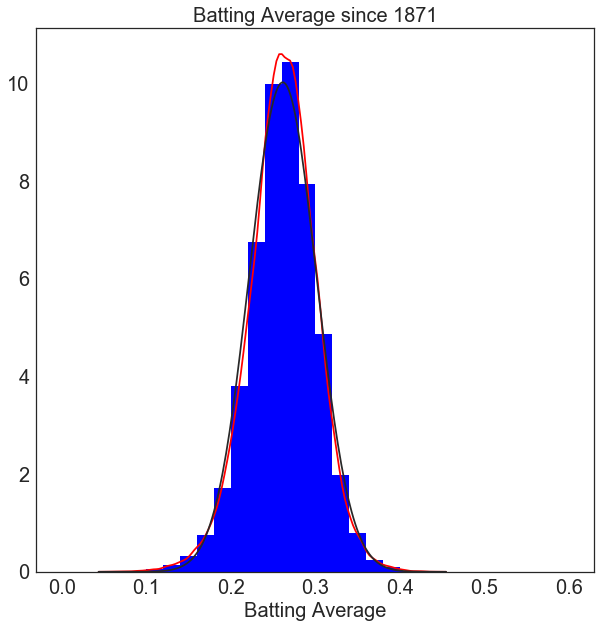

In [172]:
plt.figure(figsize=(10,10))
ax = sns.distplot(batting['bavg'],
                  hist=False,
            color = 'r',
            axlabel='Batting Average',
            fit= stats.norm)
plt.hist(batting['bavg'],
        range=(0.000, 0.600),
        bins=30,
        histtype='bar',
         normed=True,
        color='blue')

plt.title('Batting Average since 1871', fontsize=20)
plt.xlabel('Batting Average', fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show

In [173]:
batting.groupby('year')['bavg'].mean().T

year
1876    0.260557
1877    0.272037
1878    0.259339
1879    0.252116
1880    0.243837
1881    0.258138
1882    0.245565
1883    0.256460
1884    0.242945
1885    0.234216
1886    0.240782
1887    0.261556
1888    0.230550
1889    0.254454
1890    0.249624
1891    0.243500
1892    0.236739
1893    0.274665
1894    0.304440
1895    0.291714
1896    0.280861
1897    0.283432
1898    0.261640
1899    0.275283
1900    0.271409
1901    0.261730
1902    0.263088
1903    0.252433
1904    0.238640
1905    0.242930
          ...   
1988    0.253396
1989    0.253849
1990    0.257767
1991    0.253062
1992    0.254334
1993    0.264776
1994    0.270525
1995    0.268071
1996    0.267968
1997    0.266707
1998    0.265057
1999    0.271670
2000    0.269345
2001    0.263743
2002    0.260565
2003    0.262686
2004    0.266123
2005    0.264671
2006    0.270241
2007    0.267891
2008    0.263790
2009    0.261186
2010    0.256466
2011    0.253976
2012    0.253576
2013    0.252612
2014    0.250086
2015    0

## Let's Evaluate and Model out Data

Our orderinf will be to use PCA to find well correlated data to cluster on. Then we will do Kmeans cluster and HDB Scan to see how similar our cluster will be.
Since we can control the number of cluster, we will use KMeans clustering to compare to our set periods.

## Batting Year

## PCA first

### Batting by years

In [174]:
batting_year.columns

Index(['g', 'ab', 'r', 'h', '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so',
       'ibb', 'hbp', 'sh', 'sf', 'gidp', '1b', 'period', 'bavg', 'obp', 'ops',
       'slg'],
      dtype='object')

### Scale data for use with PCA

We already did this above

### Find Z scores

In [175]:
batting_year_ss

g        ab         r         h        2b        3b        hr  \
0   -1.794655 -1.819871 -1.774143 -1.849013 -1.628165 -2.962331 -1.178260   
1   -1.918455 -1.995638 -1.980602 -2.016796 -1.725236 -2.889443 -1.188633   
2   -1.899849 -1.979973 -1.991367 -2.018155 -1.695931 -3.171887 -1.188633   
3   -1.704685 -1.714014 -1.706477 -1.766287 -1.479812 -2.333665 -1.167276   
4   -1.688817 -1.722892 -1.749153 -1.793183 -1.472944 -2.310887 -1.165446   
5   -1.688415 -1.715434 -1.702632 -1.754927 -1.434024 -2.411109 -1.156903   
6   -1.693731 -1.713575 -1.670529 -1.770268 -1.434024 -1.991998 -1.128834   
7   -1.600941 -1.593576 -1.484063 -1.628799 -1.224772 -1.663998 -1.127003   
8   -1.536746 -1.526635 -1.416204 -1.597631 -1.373126 -1.873553 -1.012286   
9   -1.550278 -1.562867 -1.531737 -1.650063 -1.398767 -1.937331 -1.099544   
10  -1.477222 -1.484880 -1.381025 -1.555782 -1.318638 -1.527331 -1.055000   
11  -1.453864 -1.440029 -1.198211 -1.452763 -1.267355 -0.579775 -0.975674   
12  -1.418665 -1.408933 -1.435812 -1.522381 -1.379536 -1.540998 -1.005574   
13  -1.411819 -1.391230 -1.186100 -1.413051 -1.237135 -1.691331 -0.981166   
14  -1.421404 -1.404262 -1.232237 -1.461405 -1.300781 -1.153775 -1.048898   
15  -1.381775 -1.360339 -1.210322 -1.433344 -1.294370 -1.099108 -1.028761   
16  -0.889879 -0.774925 -0.620741 -0.904266 -1.026968  0.677559 -0.955537   
17  -1.079082 -0.952704 -0.474259 -0.897761 -0.963323  0.773226 -0.931740   
18  -1.051455 -0.933788 -0.190138 -0.717356 -0.716067  1.889337 -0.831057   
19  -1.075216 -0.981013 -0.461380 -0.834454 -0.879073  0.463448 -0.921976   
20  -1.063053 -0.989788 -0.611899 -0.873972 -0.972480  0.613781 -0.965911   
21  -1.022136 -0.945736 -0.591906 -0.821540 -0.891435  0.468003 -0.987878   
22  -0.888912 -0.821169 -0.694367 -0.803286 -1.009569  0.058003 -1.024490   
23  -0.887704 -0.822744 -0.588446 -0.731629 -0.955996  0.540892 -0.997641   
24  -1.363169 -1.382533 -1.271452 -1.352657 -1.287044 -1.094553 -1.055000   
25  -0.635514 -0.483495 -0.337005 -0.433834 -0.636854  1.616004 -0.941503   
26  -0.652589 -0.524604 -0.561341 -0.505297 -0.686305  0.463448 -0.991539   
27  -0.622062 -0.520604 -0.555766 -0.542679 -0.589234  1.237893 -1.005574   
28  -0.436645 -0.350567 -0.658419 -0.487917 -0.670737  1.224226 -1.013506   
29  -0.472327 -0.398747 -0.610169 -0.508210 -0.663869  1.037448 -1.003743   
..        ...       ...       ...       ...       ...       ...       ...   
112  1.065704  1.034377  0.789677  0.940272  0.839353 -0.105997  0.663321   
113  1.132236  1.058945  0.794483  0.956099  0.792649  0.003336  0.603521   
114  1.152372  1.052210  0.873491  0.998336  0.892467 -0.055886  0.737155   
115  1.210607  1.082480  0.958266  0.998627  0.912156  0.121781  0.803056   
116  1.142062  1.070480  0.791022  0.983966  0.935050 -0.110552  0.578503   
117  1.317250  1.325033  1.413667  1.372545  1.288992  0.294892  1.131954   
118  0.246388  0.260319  0.480757  0.325362  0.524331 -0.821219  0.712137   
119  0.920077  0.905759  1.150307  0.974936  1.052267 -0.274553  1.166125   
120  1.337145  1.362349  1.760649  1.480322  1.504653 -0.083219  1.692116   
121  1.382815  1.365343  1.567070  1.431386  1.557768 -0.001219  1.513938   
122  1.631462  1.639482  1.863109  1.708595  1.852185  0.094448  1.771442   
123  1.627112  1.642347  2.141656  1.790253  1.890189  0.267559  2.038099   
124  1.600854  1.626270  2.161648  1.761125  1.936435  0.372337  2.136341   
125  1.543424  1.593083  1.844655  1.637715  1.890647  0.217448  1.979520   
126  1.568072  1.607379  1.721049  1.596352  1.845774  0.217448  1.779985   
127  1.580798  1.636850  1.823509  1.677428  1.915830  0.258448  1.844056   
128  1.508467  1.619457  1.876950  1.700731  1.930024  0.153670  1.992334   
129  1.550029  1.624850  1.709515  1.668009  1.924530  0.044336  1.770832   
130  1.534484  1.641366  1.934620  1.765785  2.035795  0.363226  1.952061   
131  1.574274  1.656953  1.864647  1.751124  2.066931  0.267559  1.701269   
132  1.5

### Visualize correlation

In [176]:
# g = sns.PairGrid(batting_year_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

Text(0.5,1,'Batting Stats by Year Correlation')

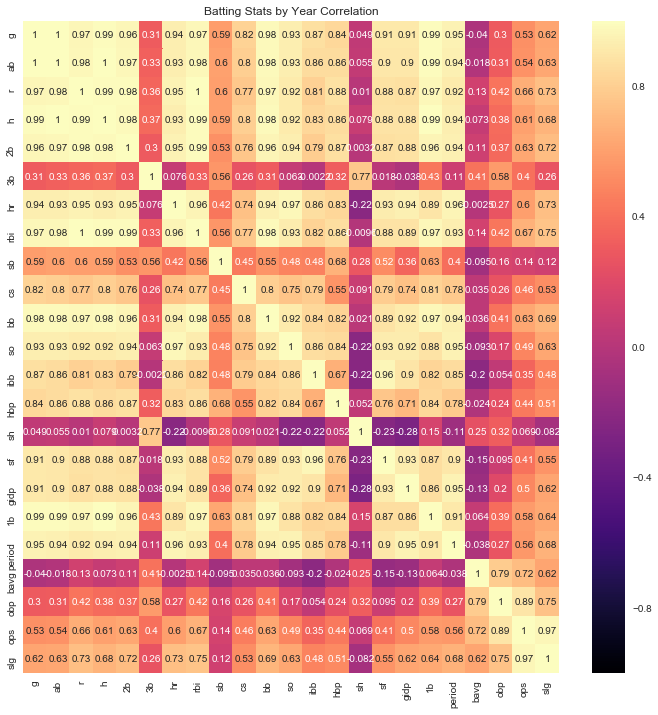

In [177]:
plt.figure(figsize=(12,12))
sns.heatmap(batting_year_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Batting Stats by Year Correlation')

### PCA for batting stats

In [178]:
batting_year_pca = PCA(n_components=23)
batting_year_pca.fit(batting_year_ss.values)

PCA(copy=True, iterated_power='auto', n_components=23, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Explained variance

In [179]:
for each in batting_year_pca.components_:
    for each in list(zip(batting_year_ss.columns, each)):
        print(each)
    print()

('g', 0.24749812763793266)
('ab', 0.24791299962391078)
('r', 0.2487221453682515)
('h', 0.24915156257232607)
('2b', 0.24645149599844032)
('3b', 0.07460226012703727)
('hr', 0.24181316864543684)
('rbi', 0.24959868248050085)
('sb', 0.1422505058939525)
('cs', 0.20463426056902595)
('bb', 0.24760177653480941)
('so', 0.23744177789891596)
('ibb', 0.21664155632867452)
('hbp', 0.21462932481992045)
('sh', -0.0032527387701026707)
('sf', 0.2302078425262292)
('gidp', 0.230137050332833)
('1b', 0.24526513487682358)
('period', 0.23957179246296845)
('bavg', 0.0209446718945661)
('obp', 0.09867030834249105)
('ops', 0.1619984004251485)
('slg', 0.18312787121214077)

('g', -0.04308020541273401)
('ab', -0.03030255549884743)
('r', 0.031023627419770595)
('h', 0.013997256088808075)
('2b', 0.010371870022973349)
('3b', 0.3856739045361716)
('hr', -0.08347366274828896)
('rbi', 0.027826928336816627)
('sb', 0.01796877704750198)
('cs', -0.020410936955139552)
('bb', -7.143723469123578e-05)
('so', -0.12990903199112855)
('

In [180]:
batting_year_pca.explained_variance_

array([1.59304863e+01, 3.37339059e+00, 2.02585497e+00, 6.20791582e-01,
       4.16138009e-01, 2.41418395e-01, 1.45161605e-01, 1.29445935e-01,
       9.72748085e-02, 5.79269659e-02, 3.98540722e-02, 2.74477547e-02,
       1.94684318e-02, 1.68563766e-02, 8.07880339e-03, 7.89558443e-03,
       2.78942587e-03, 1.98747573e-03, 4.95824913e-04, 1.83904253e-04,
       1.28971606e-04, 4.48170953e-05, 4.34920204e-33])

In [181]:
batting_year_pca.explained_variance_ratio_

array([6.87752163e-01, 1.45636275e-01, 8.74603645e-02, 2.68008613e-02,
       1.79655417e-02, 1.04225333e-02, 6.26692785e-03, 5.58844973e-03,
       4.19955542e-03, 2.50082737e-03, 1.72058303e-03, 1.18497655e-03,
       8.40492616e-04, 7.27724771e-04, 3.48778713e-04, 3.40868771e-04,
       1.20425306e-04, 8.58034533e-05, 2.14057908e-05, 7.93952837e-06,
       5.56797197e-06, 1.93484704e-06, 1.87764081e-34])

### Transform batters stats into PCA space

In [182]:
batting_year_pca_transformed = batting_year_pca.transform(batting_year_ss)

In [183]:
batting_year_pca_transformed = pd.DataFrame(batting_year_pca_transformed,
                                       columns=batting_year_ss.columns)

batting_year_pca_transformed

g        ab         r         h        2b        3b        hr  \
0   -7.135455 -3.289668 -1.692495 -0.154748  0.140384  1.402595 -0.292724   
1   -7.018914 -1.995082 -2.583224 -0.026068  0.505752  1.356538 -0.553509   
2   -7.315117 -3.210980 -1.976451 -0.139778  0.207454  1.205919 -0.388328   
3   -6.869623 -3.421696 -1.326092 -0.172548 -0.085479  1.181930  0.048133   
4   -6.958082 -3.816382 -1.070317 -0.223751 -0.217617  0.889230  0.165021   
5   -6.561888 -2.485790 -1.884814 -0.091990  0.112091  0.834368 -0.103621   
6   -6.675891 -3.232203 -1.286171 -0.159545 -0.158062  0.766730  0.207265   
7   -6.119673 -2.169433 -1.707677 -0.044251 -0.010461  0.833088  0.191497   
8   -6.183581 -3.041971 -1.233439 -0.135630 -0.265944  0.345139  0.352668   
9   -6.596995 -3.985220 -0.640138 -0.258240 -0.444283  0.289313  0.472836   
10  -5.856581 -2.848776 -0.445002  0.423115  0.418768 -0.073831  0.471670   
11  -4.645645 -0.230536 -0.774831  1.542250  1.444416 -0.134421  0.233214   
12  -5.818006 -3.824194  0.685522  1.042755  0.526867  0.010208  0.537757   
13  -4.861078 -1.128292 -0.980180  1.210289  0.994918 -0.512699  0.111375   
14  -4.897041 -1.197514 -0.470874  1.357106  0.988512 -0.631988  0.267006   
15  -5.041675 -1.810335 -0.173828  1.159268  0.696205 -0.609487  0.420302   
16  -3.717198 -1.640605  1.654114  1.748781  0.821380 -1.041492  1.170294   
17  -2.954830  1.740899 -0.536108  2.003069  1.447268 -0.625209  0.502562   
18  -1.796958  5.233545 -0.930000  1.920962  1.725424 -0.117274 -0.255730   
19  -2.676598  3.127682 -0.729697  1.751386  1.359508  0.129633 -0.380914   
20  -3.033203  2.274948  0.122429  1.582568  1.177059  0.009154 -0.278870   
21  -2.959661  2.285339 -0.074286  1.574301  0.952172  0.192624 -0.336401   
22  -3.574332  0.181759  0.958124  1.019454 -0.042508  0.185954 -0.207231   
23  -3.069039  1.511324  0.703032  1.425225  0.571561  0.215119 -0.282514   
24  -4.649804  0.386867 -0.937690  0.918926  0.651179  0.244307 -0.505784   
25  -2.697628  0.882913  2.186450  1.099898  0.002024  0.076949  0.104045   
26  -3.064010  0.505461  1.686662  0.784166 -0.068561  0.135909 -0.296536   
27  -3.167086  0.061361  2.627344  0.672311 -0.347763 -0.001256 -0.015219   
28  -3.398362 -1.104148  3.643583  0.435510 -0.801060 -0.032074  0.044090   
29  -3.210200 -0.584663  3.456163  0.521927 -0.728765 -0.098606 -0.191468   
..        ...       ...       ...       ...       ...       ...       ...   
112  3.659824 -1.487775  0.847803 -0.388060  0.772490 -0.056839 -0.121453   
113  3.687551 -1.402410  0.812966 -0.685999  0.809658 -0.133593 -0.135612   
114  4.008385 -0.989223  0.496381 -0.506090  0.986073 -0.097220 -0.044934   
115  4.032849 -1.193888  0.807452 -0.575499  0.657646 -0.087730  0.218565   
116  3.900993 -1.390849  0.903704 -0.539058  0.822012  0.003824 -0.006130   
117  5.501959 -0.259079  0.320426 -0.214099  0.877131  0.259318 -0.115571   
118  2.583629  0.374999 -1.805794  0.086562  0.564378  0.098592 -0.458561   
119  4.583167  0.169830 -0.787481  0.350947  0.394428  0.098005 -0.138877   
120  6.230317  0.022816 -0.520883  0.539900  0.330030  0.158758 -0.211681   
121  6.110033 -0.027078 -0.205894  0.366506  0.401159  0.400587  0.131904   
122  6.753397 -0.199006  0.019198  0.583509 -0.066934  0.458212  0.278007   
123  7.365674  0.574184 -0.446362  0.777754  0.244258  0.285119  0.254225   
124  7.331148  0.508980 -0.667688  0.691350 -0.187501  0.123656  0.046129   
125  6.906324 -0.265204 -0.107343  0.874941 -0.200179  0.678340 -0.097761   
126  6.626034 -0.556122 -0.117708  0.628933 -0.422716  0.389445 -0.188357   
127  6.656812 -0.358074 -0.176051  0.838060 -0.743283  0.478394 -0.180337   
128  6.845217  0.004623 -0.512541  0.903757 -0.712723  0.511916 -0.369740   
129  6.462868 -0.294046 -0.380790  0.907332 -0.768397  0.536785 -0.219924   
130  7.193089  0.200197 -0.649416  1.006763 -0.526564  0.502137 -0.313035   
131  6.974149 -0.085822 -0.399603  1.066269 -0.526333  0.320241 -0.268431   
132  6.6

### Visualize transformed PCA features
-There should be no correlation

In [184]:
# sns.pairplot(batting_year_pca_transformed)

## Now  KMeans Clustering

In [185]:
batting_year[batting_year.columns]

g      ab      r      h    2b    3b    hr      rbi      sb      cs  \
year                                                                           
1876   4450   19157   2959   5145   614   176    40   1916.0     0.0     0.0   
1877   2913   12346   1885   3417   402   192    23   1314.0     0.0     0.0   
1878   3144   12953   1829   3403   466   130    23   1283.0     0.0     0.0   
1879   5567   23259   3311   5997   938   314    58   2297.0     0.0     0.0   
1880   5764   22915   3089   5720   953   319    61   2145.0     0.0     0.0   
1881   5769   23204   3331   6114  1038   297    75   2400.0     0.0     0.0   
1882   5703   23276   3498   5956  1038   389   121   2568.0     0.0     0.0   
1883   6855   27926   4468   7413  1495   461   124   3105.0     0.0     0.0   
1884   7652   30520   4821   7734  1171   415   312   3401.0     0.0     0.0   
1885   7484   29116   4220   7194  1115   401   169   2978.0     0.0     0.0   
1886   8391   32138   5004   8165  1290   491   242   3727.0  1304.0     0.0   
1887   8681   33876   5955   9226  1402   699   372   4715.0  2571.0     0.0   
1888   9118   35081   4719   8509  1157   488   323   3602.0  2253.0     0.0   
1889   9203   35767   6018   9635  1468   455   363   4807.0  2038.0     0.0   
1890   9084   35262   5778   9137  1329   573   252   4441.0  2200.0     0.0   
1891   9576   36964   5892   9426  1343   585   285   4763.0  1952.0     0.0   
1892  15683   59649   8959  14875  1927   975   405   7044.0  3088.0     0.0   
1893  13334   52760   9721  14942  2066   996   444   8037.0  2667.0     0.0   
1894  13677   53493  11199  16800  2606  1241   609   9474.0  3049.0     0.0   
1895  13382   51663   9788  15594  2250   928   460   8160.0  2785.0     0.0   
1896  13533   51323   9005  15187  2046   961   388   7599.0  2959.0     0.0   
1897  14041   53030   9109  15727  2223   929   352   7645.0  2633.0     0.0   
1898  15695   57857   8576  15915  1965   839   292   7129.0  1985.0     0.0   
1899  15710   57796   9127  16653  2082   945   336   7560.0  2575.0     0.0   
1900   9807   36104   5574  10257  1359   586   242   4623.0  1633.0     0.0   
1901  18841   70942  10435  19720  2779  1181   428   8611.0  2759.0     0.0   
1902  18629   69349   9268  18984  2671   928   346   7743.0  2554.0     0.0   
1903  19008   69504   9297  18599  2883  1098   323   7668.0  2649.0     0.0   
1904  21310   76093   8763  19163  2705  1095   310   7182.0  2690.0     0.0   
1905  20867   74226   9014  18954  2720  1054   326   7451.0  2812.0     0.0   
...     ...     ...    ...    ...   ...   ...   ...      ...     ...     ...   
1988  39962  129760  16296  33872  6003   803  3058  15277.0  3155.0  1326.0   
1989  40788  130712  16321  34035  5901   827  2960  15292.0  2978.0  1366.0   
1990  41038  130451  16732  34470  6119   814  3179  15826.0  3132.0  1434.0   
1991  41761  131624  17173  34473  6162   853  3287  16202.0  2985.0  1494.0   
1992  40910  131159  16303  34322  6212   802  2919  15438.0  3131.0  1502.0   
1993  43085  141023  19542  38324  6985   891  3826  18398.0  3138.0  1571.0   
1994  29790   99765  14689  27539  5315   646  3138  13899.0  2171.0   971.0   
1995  38154  124776  18172  34229  6468   766  3882  17189.0  2802.0  1181.0   
1996  43332  142469  21347  39434  7456   808  4744  20225.0  3073.0  1243.0   
1997  43899  142585  20340  38930  7572   826  4452  19310.0  3169.0  1499.0   
1998  46986  153208  21880  41785  8215   847  4874  20897.0  3131.0  1424.0   
1999  46932  153319  23329  42626  8298   885  5311  22156.0  3292.0  1441.0   
2000  46606  152696  23433  42326  8399   908  5472  22465.0  2784.0  1241.0   
2001  45893  151410  21784  41055  8299   874  5215  20838.0  2963.0  1325.0   
2002  46199  151964  21141  40629  8201   874  4888  20224.0  2615.0  1201.0   
2003  46357  153106  21674  41464  8354   883  4993  20760.0  2464.0  1079.0   
2004  45459  152432  21952  41704  8385   860  5236  21026.0  2452.0  1030.0   
2005  4597

In [186]:
# Fitting pitching data on KMeans
batting_year_cluster = batting_year[batting_year.columns]
km = KMeans(n_clusters=8,
           random_state=42)
km.fit(batting_year_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [187]:
#looking at labels
km.labels_

array([2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0,
       0, 0, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [188]:
#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

4    60
7    22
1    17
6    10
0    10
5     8
3     8
2     7
dtype: int64

In [189]:
#saving labels to clustering data frame
batting_year['kmeans_clusters'] = km.labels_

In [190]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_year,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [191]:
show_cluster_results(6, 'kmeans_clusters')[batting_year.columns]

g     ab     r      h    2b   3b   hr     rbi      sb   cs  \
year                                                                  
1900  9807  36104  5574  10257  1359  586  242  4623.0  1633.0  0.0   
1887  8681  33876  5955   9226  1402  699  372  4715.0  2571.0  0.0   
1883  6855  27926  4468   7413  1495  461  124  3105.0     0.0  0.0   
1889  9203  35767  6018   9635  1468  455  363  4807.0  2038.0  0.0   
1890  9084  35262  5778   9137  1329  573  252  4441.0  2200.0  0.0   
1891  9576  36964  5892   9426  1343  585  285  4763.0  1952.0  0.0   
1884  7652  30520  4821   7734  1171  415  312  3401.0     0.0  0.0   
1886  8391  32138  5004   8165  1290  491  242  3727.0  1304.0  0.0   
1885  7484  29116  4220   7194  1115  401  169  2978.0     0.0  0.0   
1888  9118  35081  4719   8509  1157  488  323  3602.0  2253.0  0.0   

           ...            sh   sf  gidp    1b  period   bavg    obp    ops  \
year       ...                                                               
1900       ...         747.0  0.0   0.0  8070       0  0.271  0.328  0.684   
1887       ...           0.0  0.0   0.0  6753       0  0.262  0.316  0.684   
1883       ...           0.0  0.0   0.0  5333       0  0.256  0.283  0.632   
1889       ...           0.0  0.0   0.0  7349       0  0.254  0.323  0.664   
1890       ...           0.0  0.0   0.0  6983       0  0.250  0.321  0.657   
1891       ...           0.0  0.0   0.0  7213       0  0.244  0.312  0.638   
1884       ...           0.0  0.0   0.0  5836       0  0.243  0.282  0.611   
1886       ...           0.0  0.0   0.0  6142       0  0.241  0.287  0.613   
1885       ...           0.0  0.0   0.0  5509       0  0.234  0.271  0.581   
1888       ...           0.0  0.0   0.0  6541       0  0.231  0.274  0.585   

        slg  kmeans_clusters  
year                          
1900  0.356                6  
1887  0.368                6  
1883  0.349                6  
1889  0.341                6  
1890  0.336                6  
1891  0.326                6  
1884  0.330                6  
1886  0.326                6  
1885  0.310                6  
1888  0.311                6  

[10 rows x 24 columns]

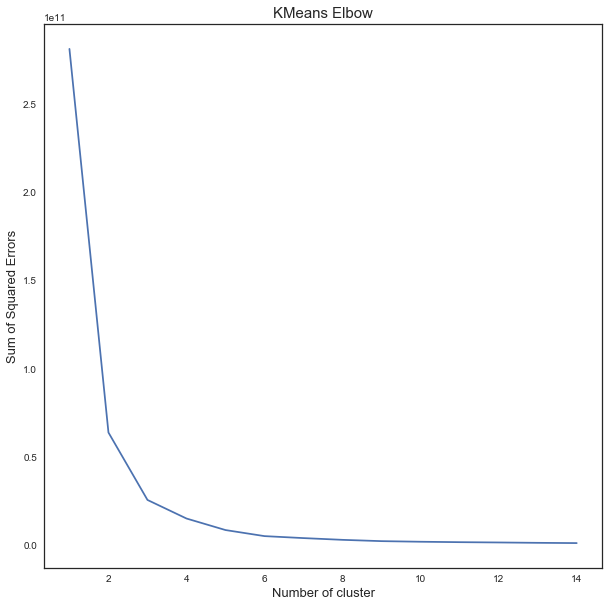

In [192]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(batting_year)
    batting_year['kmean_clusters'] = kmeans.labels_
    #print(batters["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('KMeans Elbow', fontsize=15)
plt.xlabel("Number of cluster", fontsize=13)
plt.ylabel("Sum of Squared Errors", fontsize=13)
plt.show()

In [193]:
ks = range(2,16)
sil = []

for n_cluster in range(2, 16):
    kmeans = KMeans(n_clusters=n_cluster).fit(batting_year)
    label = kmeans.labels_
    sil_coeff = silhouette_score(batting_year, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    sil.append(sil_coeff)

For n_clusters=2, The Silhouette Coefficient is 0.7099309357638623
For n_clusters=3, The Silhouette Coefficient is 0.7147295191842984
For n_clusters=4, The Silhouette Coefficient is 0.6698473531524637
For n_clusters=5, The Silhouette Coefficient is 0.6826849722617484
For n_clusters=6, The Silhouette Coefficient is 0.6792258837148392
For n_clusters=7, The Silhouette Coefficient is 0.6841816490462682
For n_clusters=8, The Silhouette Coefficient is 0.6795501787418714
For n_clusters=9, The Silhouette Coefficient is 0.5872318278041582
For n_clusters=10, The Silhouette Coefficient is 0.5513606053862716
For n_clusters=11, The Silhouette Coefficient is 0.5657938259527122
For n_clusters=12, The Silhouette Coefficient is 0.5273114892859978
For n_clusters=13, The Silhouette Coefficient is 0.5324363210892108
For n_clusters=14, The Silhouette Coefficient is 0.5519123285196622
For n_clusters=15, The Silhouette Coefficient is 0.5371029414494193


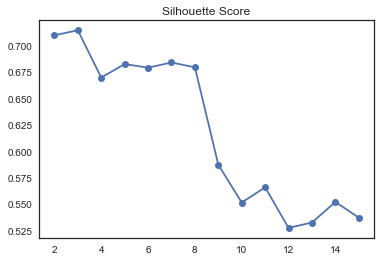

In [194]:
plt.plot(ks, sil, '-o')
plt.title('Silhouette Score');

In [195]:
batting_year['year'] = batting_year.index

In [196]:
# Call k-means to cluster the stats
kmeans = KMeans(n_clusters=8, random_state=42)
model = kmeans.fit(batting_year)
centroids = pd.DataFrame(model.cluster_centers_, columns = batting_year.columns)

In [623]:
batting_year.columns

Index(['g', 'ab', 'r', 'h', '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so',
       'ibb', 'hbp', 'sh', 'sf', 'gidp', '1b', 'period', 'bavg', 'obp', 'ops',
       'slg', 'kmeans_clusters', 'hdb_clusters', 'kmean_clusters', 'year'],
      dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


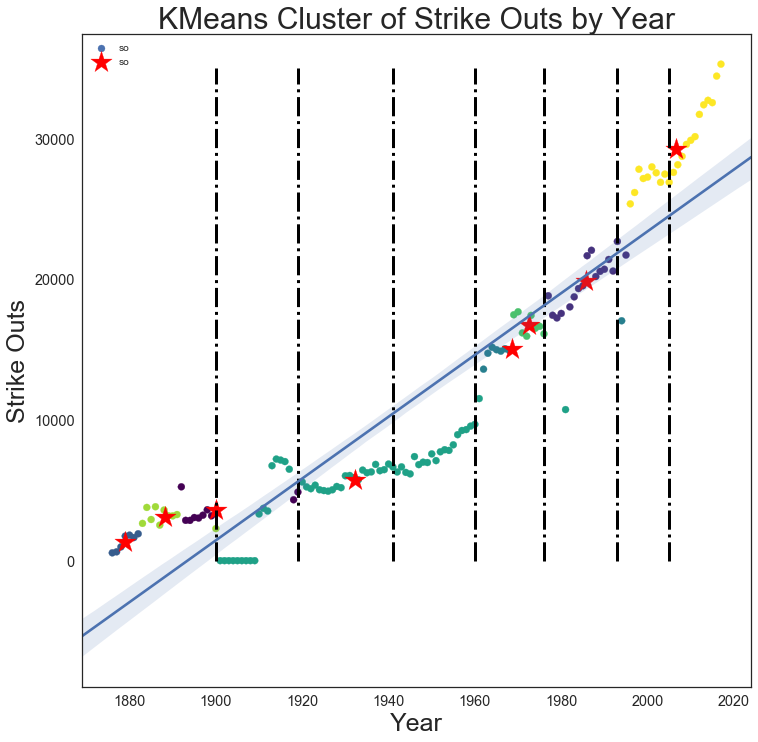

In [208]:
plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batting_year['year'], batting_year['so'],
                c=batting_year['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['year'], centroids['so'],
           c='red', marker='*', s=500)
ax = sns.regplot(x=batting_year['year'], y=batting_year['so'],
                scatter=False, logistic=False, order=1)
plt.vlines(x=1900, ymin=0, ymax=35000, linestyles='dashdot', lw=3)
plt.vlines(x=1919, ymin=0, ymax=35000, linestyles='dashdot', lw=3)
plt.vlines(x=1941, ymin=0, ymax=35000, linestyles='dashdot', lw=3)
plt.vlines(x=1960, ymin=0, ymax=35000, linestyles='dashdot', lw=3)
plt.vlines(x=1976, ymin=0, ymax=35000, linestyles='dashdot', lw=3)
plt.vlines(x=1993, ymin=0, ymax=35000, linestyles='dashdot', lw=3)
plt.vlines(x=2005, ymin=0, ymax=35000, linestyles='dashdot', lw=3)
plt.title('KMeans Cluster of Strike Outs by Year', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Strike Outs', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend();

## HDBSCAN

In [209]:
hdb = HDBSCAN(min_cluster_size=4)
hdb.fit(batting_year)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=4, min_samples=None, p=None,
    prediction_data=False)

In [210]:
# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

-1     6
 0    17
 1    23
 2     9
 3    10
 4     7
 5    16
 6    13
 7    41
dtype: int64

In [211]:
batting_year['hdb_clusters'] = hdb.labels_

In [212]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_year,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [213]:
show_cluster_results(2, 'hdb_clusters')

g      ab      r      h    2b   3b    hr      rbi      sb      cs  \
year                                                                          
1994  29790   99765  14689  27539  5315  646  3138  13899.0  2171.0   971.0   
1962  29984   97016  13265  26096  4005  809  2850  12505.0  1293.0   670.0   
1964  30483   98104  12182  25686  4013  720  2657  11481.0  1131.0   680.0   
1965  30194   96237  11965  24775  3916  743  2565  11081.0  1377.0   740.0   
1966  30290   96775  11895  25056  3818  758  2645  11191.0  1387.0   883.0   
1963  29635   96673  11746  24829  3818  731  2579  11058.0  1191.0   718.0   
1967  29777   95053  11186  24144  3736  735  2194  10312.0  1294.0   883.0   
1972  33791  108583  12476  27537  4249  686  2392  11643.0  1745.0  1035.0   
1968  29960   95461  10224  23612  3583  651  1880   9477.0  1476.0   901.0   

          ...          1b  period   bavg    obp    ops    slg  \
year      ...                                                   
1994      ...       18440       6  0.271  0.339  0.763  0.424   
1962      ...       18432       4  0.261  0.331  0.731  0.399   
1964      ...       18296       4  0.253  0.315  0.694  0.379   
1965      ...       17551       4  0.250  0.316  0.694  0.378   
1966      ...       17835       4  0.250  0.311  0.688  0.377   
1963      ...       17701       4  0.249  0.313  0.689  0.376   
1967      ...       17479       4  0.245  0.310  0.669  0.359   
1972      ...       20210       4  0.244  0.311  0.665  0.354   
1968      ...       17498       4  0.238  0.301  0.641  0.340   

      kmeans_clusters  kmean_clusters  year  hdb_clusters  
year                                                       
1994                3               4  1994             2  
1962                3               4  1962             2  
1964                3               4  1964             2  
1965                3               4  1965             2  
1966                3               4  1966             2  
1963                3               4  1963             2  
1967                3               4  1967             2  
1972                5               5  1972             2  
1968                3               4  1968             2  

[9 rows x 27 columns]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


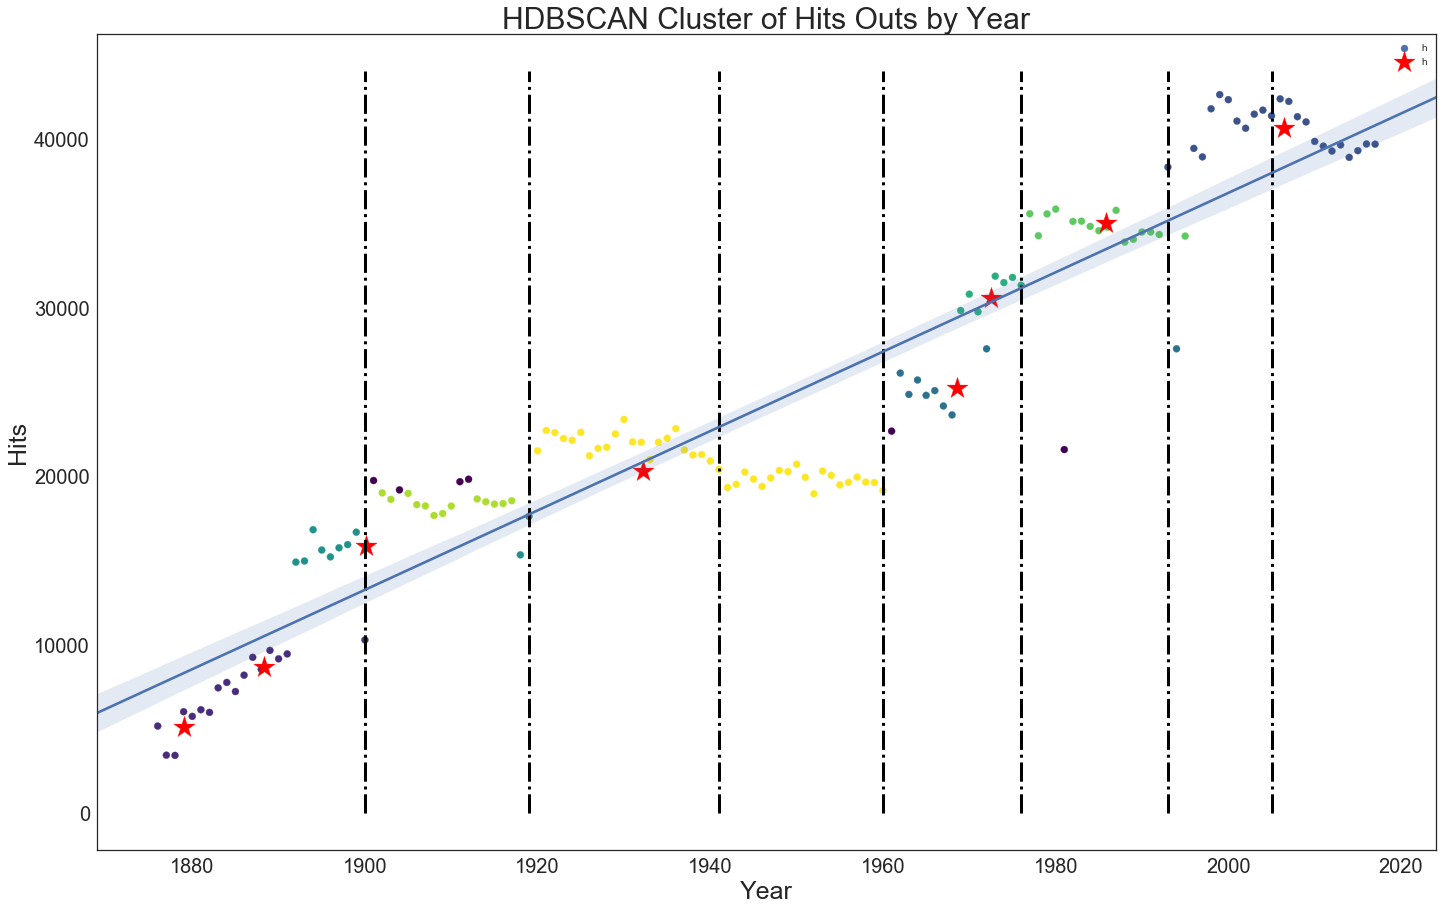

In [215]:
plt.figure(figsize=(24,15))
plt.scatter(batting_year['year'], batting_year['h'],
           c=batting_year['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['year'], centroids['h'],
           c='red', marker='*', s=500)
ax = sns.regplot(x=batting_year['year'], y=batting_year['h'],
                scatter=False, logistic=False, order=1)
plt.vlines(x=1900, ymin=0, ymax=44000, linestyles='dashdot', lw=3)
plt.vlines(x=1919, ymin=0, ymax=44000, linestyles='dashdot', lw=3)
plt.vlines(x=1941, ymin=0, ymax=44000, linestyles='dashdot', lw=3)
plt.vlines(x=1960, ymin=0, ymax=44000, linestyles='dashdot', lw=3)
plt.vlines(x=1976, ymin=0, ymax=44000, linestyles='dashdot', lw=3)
plt.vlines(x=1993, ymin=0, ymax=44000, linestyles='dashdot', lw=3)
plt.vlines(x=2005, ymin=0, ymax=44000, linestyles='dashdot', lw=3)
plt.title('HDBSCAN Cluster of Hits Outs by Year', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Hits', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend();

# Model the Data

How well can we predict the period just on the clusters we generated?

In [354]:
# Define my x and y
# we will test one cluster at a time
features = [each for each in batting_year.columns if each not in ['year', 'period']]
X = batting_year[features]
y = batting_year['period']

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [356]:
X_train.head()

g      ab      r      h    2b   3b    hr      rbi      sb      cs  \
year                                                                          
1986  41526  131982  17496  34760  6152  821  3657  16456.0  3152.0  1530.0   
1918  16839   58245   6663  15308  2093  801   218   5569.0  1868.0     0.0   
1993  43085  141023  19542  38324  6985  891  3826  18398.0  3138.0  1571.0   
1962  29984   97016  13265  26096  4005  809  2850  12505.0  1293.0   670.0   
1971  35340  114355  13804  29737  4535  766  2707  12935.0  1703.0   988.0   

          ...           sf    gidp     1b   bavg    obp    ops    slg  \
year      ...                                                           
1986      ...       1114.0  2903.0  24130  0.256  0.324  0.714  0.390   
1918      ...          0.0     0.0  12196  0.256  0.320  0.648  0.328   
1993      ...       1338.0  3171.0  26622  0.265  0.331  0.733  0.402   
1962      ...        776.0  2212.0  18432  0.261  0.331  0.731  0.399   
1971      ...        921.0  2767.0  21729  0.251  0.318  0.686  0.368   

      kmeans_clusters  kmean_clusters  hdb_clusters  
year                                                 
1986                1               0             5  
1918                0               6             3  
1993                1              12             1  
1962                3               4             2  
1971                5               5             4  

[5 rows x 25 columns]

In [357]:
y_train.head()

year
1986    5
1918    1
1993    5
1962    4
1971    4
Name: period, dtype: int64

In [358]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   36.1s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100building tree 21 of 100

building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100building tree 27 of 100

building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100building tree 38 of 100building tree 39 of 100

building tree 40 of 100

building tree 41 of 100
building tree 42 of 100bu

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9433962264150944

In [359]:
gs_rf.best_params_

{'rf__criterion': 'gini',
 'rf__n_estimators': 100,
 'rf__n_jobs': -1,
 'rf__random_state': 42,
 'rf__verbose': 2}

In [360]:
gs_rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.8611111111111112

In [361]:
y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[8, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 2, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 1, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 2, 1]], dtype=int64)

In [362]:
gs_rf.predict_proba(X_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.78, 0.21],
       [0.87, 0.08, 0.02, 0.03, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.94, 0.04, 0.02, 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.99, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.97, 0.01, 0.01, 0.01, 0.  , 0.  ],
       [0.98, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.92, 0.06, 0.01, 0.  ],
       [0.  , 0.01, 0.19, 0.77, 0.02, 0.01, 0.  , 0.  ],
       [0.  , 0.07, 0.04, 0.87, 0.01, 0.01, 0.  , 0.  ],
       [0.63, 0.2 , 0.1 , 0.05, 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.01, 0.98, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.94, 0.06, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.05, 0.94, 0.  , 0.01],
       [0.01, 0.  , 0.07, 0.  , 0.  , 0.  , 0.79, 0.13],
       [0.  , 0.01, 0.34, 0.63, 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.06, 0.93,

In [241]:
X_test

kmeans_clusters  hdb_clusters
year                               
2007                7             1
1895                0             3
1957                4             7
1972                5             2
1932                4             7
1888                6             0
1974                5             4
1941                4             7
1942                4             7
1894                0             3
1927                4             7
1953                4             7
1969                5             4
1991                1             5
2006                7             1
1940                4             7
1903                4             6
1945                4             7
2000                7             1
1949                4             7
1887                6             0
1994                3             2
1985                1             5
1988                1             5
1931                4             7
1921                4             7
1885                6             0
1880                2             0
1902                4             6
1999                7             1
1907                4             6
1973                5             4
1912                4            -1
1892                0             3
1886                6             0
2016                7             1

73.6% isn't horrible. We aren't over fitting. But lets make a more complexed model.

In [252]:
# Define my x and y
# we will test one cluster at a time
features = [each for each in batting_year.columns if each not in ['year', 'period','kmeans_cluster', 'hdb_clusters']]
X = batting_year[features]
y = batting_year['period']

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [254]:
X_train.head()

g      ab      r      h    2b   3b    hr      rbi      sb      cs  \
year                                                                          
1986  41526  131982  17496  34760  6152  821  3657  16456.0  3152.0  1530.0   
1918  16839   58245   6663  15308  2093  801   218   5569.0  1868.0     0.0   
1993  43085  141023  19542  38324  6985  891  3826  18398.0  3138.0  1571.0   
1962  29984   97016  13265  26096  4005  809  2850  12505.0  1293.0   670.0   
1971  35340  114355  13804  29737  4535  766  2707  12935.0  1703.0   988.0   

           ...            sh      sf    gidp     1b   bavg    obp    ops  \
year       ...                                                             
1986       ...        1011.0  1114.0  2903.0  24130  0.256  0.324  0.714   
1918       ...        2083.0     0.0     0.0  12196  0.256  0.320  0.648   
1993       ...        1076.0  1338.0  3171.0  26622  0.265  0.331  0.733   
1962       ...         842.0   776.0  2212.0  18432  0.261  0.331  0.731   
1971       ...        1005.0   921.0  2767.0  21729  0.251  0.318  0.686   

        slg  kmeans_clusters  kmean_clusters  
year                                          
1986  0.390                1               0  
1918  0.328                0               6  
1993  0.402                1              12  
1962  0.399                3               4  
1971  0.368                5               5  

[5 rows x 24 columns]

In [255]:
y_train.head()

year
1986    5
1918    1
1993    5
1962    4
1971    4
Name: period, dtype: int64

In [256]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   38.6s finished


building tree 1 of 100
building tree 2 of 100building tree 3 of 100building tree 4 of 100


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100building tree 10 of 100

building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100building tree 15 of 100

building tree 16 of 100
building tree 17 of 100
building tree 18 of 100building tree 19 of 100building tree 20 of 100


building tree 21 of 100building tree 22 of 100

building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100building tree 38 of 100
building tree 39 of 100

building tree 40 of 100
building tree 41 of 100building tree 42 of 100bui

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100building tree 99 of 100

building tree 100 of 100


0.9433962264150944

In [257]:
gs_rf.best_params_

{'rf__criterion': 'gini',
 'rf__n_estimators': 100,
 'rf__n_jobs': -1,
 'rf__random_state': 42,
 'rf__verbose': 2}

In [258]:
gs_rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.8611111111111112

In [259]:
y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[8, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 2, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 1, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 2, 1]], dtype=int64)

In [260]:
gs_rf.predict_proba(X_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.69, 0.31],
       [0.92, 0.02, 0.02, 0.03, 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.91, 0.04, 0.04, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.98, 0.01, 0.01, 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.91, 0.07, 0.01, 0.  ],
       [0.  , 0.03, 0.14, 0.81, 0.01, 0.01, 0.  , 0.  ],
       [0.01, 0.06, 0.03, 0.88, 0.01, 0.01, 0.  , 0.  ],
       [0.69, 0.08, 0.14, 0.07, 0.  , 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.98, 0.02, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.03, 0.96, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.97, 0.02, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.05, 0.94, 0.  , 0.01],
       [0.01, 0.  , 0.08, 0.  , 0.  , 0.  , 0.72, 0.19],
       [0.01, 0.03, 0.29, 0.65, 0.02, 0.  , 0.  , 0.  ],
       [0.02, 0.97, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.04, 0.07, 0.87,

In [261]:
X_test

g      ab      r      h    2b    3b    hr      rbi      sb      cs  \
year                                                                           
2007  46276  153885  21888  42223  8684   885  4759  21046.0  2800.0   943.0   
1895  13382   51663   9788  15594  2250   928   460   8160.0  2785.0     0.0   
1957  22913   74241   9695  19921  3146   622  2081   9214.0   734.0   523.0   
1972  33791  108583  12476  27537  4249   686  2392  11643.0  1745.0  1035.0   
1932  21418   76670  11127  21988  4231  1003  1312  10411.0   954.0   400.0   
1888   9118   35081   4719   8509  1157   488   323   3602.0  2253.0     0.0   
1974  37057  119656  14893  31470  4884   802  2533  13905.0  2369.0  1298.0   
1941  21615   74686  10195  20380  3641   818  1276   9423.0   840.0   309.0   
1942  21442   73458   9162  19305  3220   676  1029   8415.0   916.0   370.0   
1894  13677   53493  11199  16800  2606  1241   609   9474.0  3049.0     0.0   
1927  21617   73588  10685  21627  3777  1063   856   9718.0  1385.0   476.0   
1953  21972   73834  10301  20281  3299   695  1948   9771.0   638.0   490.0   
1969  36163  115347  14529  29811  4467   787  2955  13541.0  1778.0  1045.0   
1991  41761  131624  17173  34473  6162   853  3287  16202.0  2985.0  1494.0   
2006  45782  153281  22252  42374  8616   906  5170  21283.0  2645.0  1042.0   
1940  21442   75224  10587  20876  3791   868  1515   9814.0   908.0   324.0   
1903  19008   69504   9297  18599  2883  1098   323   7668.0  2649.0     0.0   
1945  21462   73382   9357  19807  3188   693   954   8630.0   937.0   354.0   
2000  46606  152696  23433  42326  8399   908  5472  22465.0  2784.0  1241.0   
1949  22290   74303  10494  20246  3334   713  1647   9837.0   709.0   283.0   
1887   8681   33876   5955   9226  1402   699   372   4715.0  2571.0     0.0   
1994  29790   99765  14689  27539  5315   646  3138  13899.0  2171.0   971.0   
1985  41020  131206  17149  34549  6064   912  3471  16165.0  2975.0  1338.0   
1988  39962  129760  16296  33872  6003   803  3058  15277.0  3155.0  1326.0   
1931  21787   76349  10953  22013  4195  1028  1033  10253.0  1047.0   435.0   
1921  21428   75616  10999  22691  3697  1275   891   9872.0  1435.0  1252.0   
1885   7484   29116   4220   7194  1115   401   169   2978.0     0.0     0.0   
1880   5764   22915   3089   5720   953   319    61   2145.0     0.0     0.0   
1902  18629   69349   9268  18984  2671   928   346   7743.0  2554.0     0.0   
1999  46932  153319  23329  42626  8298   885  5311  22156.0  3292.0  1441.0   
1907  20722   71873   8048  18211  2312   902   228   6560.0  2660.0     0.0   
1973  36922  120847  15309  31849  4909   739  2986  14371.0  1970.0  1153.0   
1912  20672   71052  10065  19796  3042  1240   420   8406.0  3171.0     0.0   
1892  15683   59649   8959  14875  1927   975   405   7044.0  3088.0     0.0   
1886   8391   32138   5004   8165  1290   491   242   3727.0  1304.0     0.0   
2016  45838  151836  20476  39696  7788   821  5412  19613.0  2421.0   937.0   

           ...            sh      sf    gidp     1b   bavg    obp    ops  \
year       ...                                                             
2007       ...         832.0  1358.0  3712.0  27895  0.268  0.335  0.755   
1895       ...         909.0     0.0     0.0  11956  0.292  0.354  0.745   
1957       ...         709.0   628.0  1739.0  14072  0.261  0.327  0.724   
1972       ...         971.0   803.0  2472.0  20210  0.244  0.311  0.665   
1932       ...        1096.0     0.0     0.0  15442  0.277  0.337  0.737   
1888       ...           0.0     0.0     0.0   6541  0.231  0.274  0.585   
1974       ...        1211.0  1018.0  2808.0  23251  0.255  0.322  0.688   
1941       ...         961.0     0.0  1610.0  14645  0.265  0.335  0.712   
1942       ...        1039.0     0.0  1521.0  14380  0.254  0.325  0.675   
1894       ...        1058.0     0.0     0.0  12344  0.304  0.372  0.798   
1927       ...        2625.0     0.0     0.0  15931  0.28

This seems to be a little better. 94%. But it is overfitting. Let's try it on a more complexed dataset. Let's predict some team data.

## Batting Team

## PCA first

In [262]:
batting_team.columns

Index(['g', 'ab', 'r', 'h', '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so',
       'ibb', 'hbp', 'sh', 'sf', 'gidp', '1b', 'period', 'bavg', 'obp', 'ops',
       'slg'],
      dtype='object')

### Scale data for use with PCA

We already did this above

### Find Z scores

In [263]:
batting_team_ss

g        ab         r         h        2b        3b        hr  \
0  -0.726901 -0.721588 -0.704883 -0.710779 -0.693243 -0.718435 -0.644804   
1  -0.425449 -0.437371 -0.422815 -0.436567 -0.345289 -0.451778 -0.195594   
2   0.403503  0.339047  0.312334  0.320670  0.351924 -0.172955  0.809054   
3   0.721052  0.680687  0.625546  0.630280  0.681291 -0.078068  1.301310   
4  -0.842880 -0.821084 -0.802563 -0.814701 -0.825533 -0.651771 -0.915348   
5  -0.898851 -0.892662 -0.876821 -0.880548 -0.894559 -0.727194 -0.926457   
6  -0.777507 -0.752759 -0.667163 -0.717364 -0.765638 -0.487300 -0.896602   
7   1.875950  1.928273  1.995061  1.959434  2.213985  1.662506  2.013196   
8   0.585434  0.642171  0.683474  0.672131  0.525086  1.248894  0.021027   
9   0.689455  0.778881  0.757288  0.762401  0.565523  1.116052 -0.178468   
10 -0.115565 -0.143519 -0.210166 -0.175840 -0.238761 -0.387060 -0.075018   
11  1.905400  1.897675  1.802841  1.852851  1.760808  1.660559  1.530891   
12  2.302971  2.330341  2.414930  2.333197  2.283663  2.445448  2.131226   
13  2.119864  2.096854  2.051216  2.092001  2.052998  2.245454  1.873411   
14 -0.857426 -0.841379 -0.839692 -0.841989 -0.844556 -0.714056 -0.924837   
15 -0.713871 -0.678720 -0.619912 -0.664463 -0.724658 -0.442046 -0.878319   
16  1.891143  1.912001  1.914006  1.925413  2.045824  1.599248  1.874799   
17 -0.888290 -0.875782 -0.870208 -0.870690 -0.890972 -0.755417 -0.932011   
18 -0.300051 -0.319501 -0.236839 -0.280265 -0.187345 -0.329154  0.052964   
19  1.941715  1.951329  2.006070  1.959285  1.931687  1.938409  2.085171   
20 -0.814094 -0.788348 -0.758895 -0.784401 -0.804771 -0.579267 -0.879708   
21 -0.463739 -0.475138 -0.470732 -0.468039 -0.405183 -0.551044 -0.318947   
22 -0.917434 -0.909866 -0.898470 -0.901195 -0.915756 -0.801644 -0.937334   
23  0.474991  0.425134  0.353859  0.396040  0.479105  0.114626  0.603310   
24 -0.928199 -0.924294 -0.916535 -0.916392 -0.925104 -0.820135 -0.938028   
25 -0.878905 -0.868533 -0.853952 -0.862970 -0.872275 -0.763203 -0.909562   
26 -0.613205 -0.628714 -0.654750 -0.635539 -0.658132 -0.559317 -0.616800   
27  0.336188  0.333976  0.272730  0.323962  0.426494  0.124845  0.387847   
28 -0.918780 -0.914152 -0.908814 -0.908338 -0.914342 -0.804077 -0.934326   
29 -0.495881 -0.494941 -0.497295 -0.495736 -0.466817 -0.613329 -0.355976   
..       ...       ...       ...       ...       ...       ...       ...   
39 -0.918320 -0.914116 -0.905711 -0.905176 -0.914125 -0.798238 -0.933631   
40 -0.038473 -0.088492 -0.137940 -0.103148 -0.012118 -0.250325  0.021953   
41  0.710168  0.792453  0.934878  0.849861  0.589981  1.321398  0.326286   
42 -0.928676 -0.924345 -0.917237 -0.916913 -0.928582 -0.821595 -0.938260   
43  1.839499  1.873388  2.073678  1.896712  1.806136  1.626984  2.551044   
44  0.516620  0.417970  0.317432  0.368939  0.420732 -0.070769  0.667649   
45  0.368142  0.339838  0.321016  0.279469  0.337250 -0.234267  0.804425   
46  0.261770  0.302643  0.314994  0.329636  0.314640  0.679084 -0.157870   
47  2.249895  2.255171  2.211405  2.237589  2.268119  2.182683  1.902108   
48 -0.929051 -0.924390 -0.914356 -0.914941 -0.924995 -0.810890 -0.937103   
49  2.154595  2.178229  2.149265  2.216440  2.098870  2.973897  1.540380   
50 -0.830889 -0.806591 -0.782355 -0.804062 -0.817815 -0.662963 -0.916042   
51  0.318235  0.240235  0.133857  0.199002  0.225395 -0.093152  0.373730   
52 -0.911438 -0.911837 -0.906080 -0.905176 -0.915321 -0.817215 -0.913034   
53  0.127583  0.126853  0.089377  0.099730  0.180610 -0.297525  0.488289   
54  0.604273  0.521661  0.495539  0.500781  0.536609  0.181291  0.962725   
55 -0.918320 -0.911776 -0.902090 -0.904394 -0.919451 -0.796778 -0.938028   
56 -0.903041 -0.896963 -0.893372 -0.893383 -0.901298 -0.795318 -0.929928   
57  0.227942  0.261609  0.202315  0.262729  0.232135  0.560353 -0.274281   
58  2.062957  2.046503  2.046856  2.108426  2.086913  2.315525  1.616752   
59 -0.927075 -0.922886 -0.917237 -0.915759 -0.926843 -0.819

### Visualize correlation

In [264]:
# g = sns.PairGrid(batting_year_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

Text(0.5,1,'Batting Stats by Team Correlation')

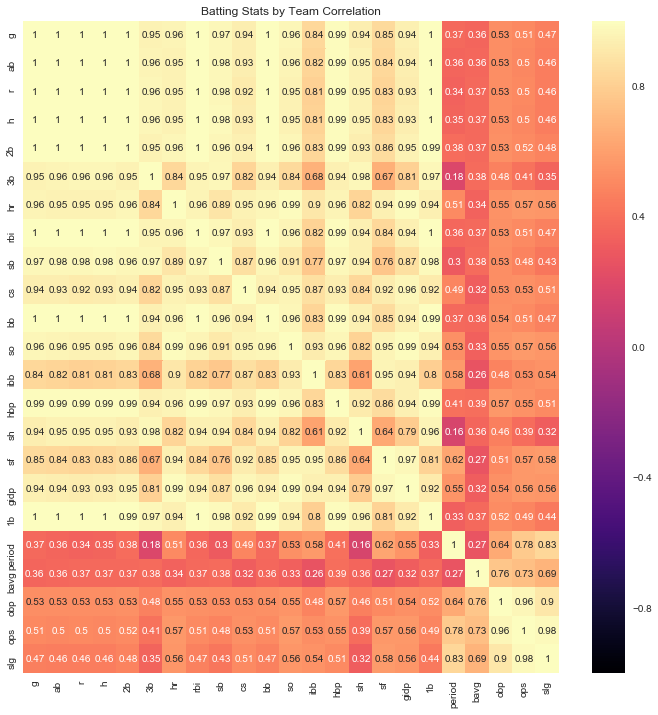

In [265]:
plt.figure(figsize=(12,12))
sns.heatmap(batting_team_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Batting Stats by Team Correlation')

### PCA for batting stats

In [266]:
batting_team_pca = PCA(n_components=23)
batting_team_pca.fit(batting_year_ss.values)

PCA(copy=True, iterated_power='auto', n_components=23, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Explained variance

In [267]:
for each in batting_team_pca.components_:
    for each in list(zip(batting_team_ss.columns, each)):
        print(each)
    print()

('g', 0.24749812763793266)
('ab', 0.24791299962391078)
('r', 0.2487221453682515)
('h', 0.24915156257232607)
('2b', 0.24645149599844032)
('3b', 0.07460226012703727)
('hr', 0.24181316864543684)
('rbi', 0.24959868248050085)
('sb', 0.1422505058939525)
('cs', 0.20463426056902595)
('bb', 0.24760177653480941)
('so', 0.23744177789891596)
('ibb', 0.21664155632867452)
('hbp', 0.21462932481992045)
('sh', -0.0032527387701026707)
('sf', 0.2302078425262292)
('gidp', 0.230137050332833)
('1b', 0.24526513487682358)
('period', 0.23957179246296845)
('bavg', 0.0209446718945661)
('obp', 0.09867030834249105)
('ops', 0.1619984004251485)
('slg', 0.18312787121214077)

('g', -0.04308020541273401)
('ab', -0.03030255549884743)
('r', 0.031023627419770595)
('h', 0.013997256088808075)
('2b', 0.010371870022973349)
('3b', 0.3856739045361716)
('hr', -0.08347366274828896)
('rbi', 0.027826928336816627)
('sb', 0.01796877704750198)
('cs', -0.020410936955139552)
('bb', -7.143723469123578e-05)
('so', -0.12990903199112855)
('

In [268]:
batting_team_pca.explained_variance_

array([1.59304863e+01, 3.37339059e+00, 2.02585497e+00, 6.20791582e-01,
       4.16138009e-01, 2.41418395e-01, 1.45161605e-01, 1.29445935e-01,
       9.72748085e-02, 5.79269659e-02, 3.98540722e-02, 2.74477547e-02,
       1.94684318e-02, 1.68563766e-02, 8.07880339e-03, 7.89558443e-03,
       2.78942587e-03, 1.98747573e-03, 4.95824913e-04, 1.83904253e-04,
       1.28971606e-04, 4.48170953e-05, 4.34920204e-33])

In [269]:
batting_team_pca.explained_variance_ratio_

array([6.87752163e-01, 1.45636275e-01, 8.74603645e-02, 2.68008613e-02,
       1.79655417e-02, 1.04225333e-02, 6.26692785e-03, 5.58844973e-03,
       4.19955542e-03, 2.50082737e-03, 1.72058303e-03, 1.18497655e-03,
       8.40492616e-04, 7.27724771e-04, 3.48778713e-04, 3.40868771e-04,
       1.20425306e-04, 8.58034533e-05, 2.14057908e-05, 7.93952837e-06,
       5.56797197e-06, 1.93484704e-06, 1.87764081e-34])

### Transform batters stats into PCA space

In [270]:
batting_team_pca_transformed = batting_team_pca.transform(batting_team_ss)

In [271]:
batting_team_pca_transformed = pd.DataFrame(batting_team_pca_transformed,
                                       columns=batting_team_ss.columns)

batting_team_pca_transformed

g        ab         r         h        2b        3b        hr  \
0  -1.840706  1.110745 -2.114224  0.075154 -0.028413 -0.265819 -0.195749   
1  -0.427536  0.876683 -2.006374  0.098143 -0.061311 -0.380114 -0.251133   
2   2.531722 -0.186546 -0.913830 -0.416645  0.524719 -0.140788 -0.657452   
3   3.656741 -0.446270 -0.589499 -0.273584  0.103054 -0.103851 -0.661531   
4  -3.891870 -0.686977 -0.513966  0.177765 -0.050401  0.334353  0.292625   
5  -3.095017  2.419738 -2.409503  0.464707  0.704266  0.230947 -0.392717   
6  -2.613168  3.108826 -2.053637  0.972083  0.983894  0.336213 -0.478657   
7   7.560305  1.138961  1.735626 -0.600681 -0.376717  0.572364 -0.331081   
8   1.173242  2.044853  1.628149  0.661365 -0.581596 -0.073666  0.261679   
9   0.886322  1.327853  2.207481  0.665250 -0.949128 -0.028864  0.475699   
10 -0.026035 -0.277593 -0.595958 -0.451850  0.121743 -0.311508 -0.196916   
11  7.113485  0.799321  3.061967 -0.788542  0.132026  0.758165  0.058755   
12  8.226162  1.164231  3.269820  0.175488 -0.109995  0.462436 -0.227618   
13  7.783799  1.070514  3.120646  0.094534  0.384332  0.449568 -0.444037   
14 -4.329959 -2.208845  0.413532  0.016833 -0.436851  0.017633  0.587243   
15 -3.047700  0.967847 -0.787697  0.590531  0.357328 -0.260213  0.086374   
16  7.324069  1.132193  2.255408 -0.746762 -0.118530  0.844940 -0.002005   
17 -4.308913 -1.542691  0.026961  0.084049 -0.174831  0.361630  0.372539   
18  0.446242  2.018797 -2.540299  0.152569  0.338675  0.125967 -0.473342   
19  7.466783  1.264943  2.304577 -0.713627 -0.187566  0.585036  0.125549   
20 -3.722288 -0.714695 -0.379465  0.255434 -0.084953 -0.104327  0.392289   
21 -0.614245  1.063607 -1.942102  0.118945  0.094445 -0.300262 -0.283181   
22 -4.330626 -1.165679 -0.215836  0.126567 -0.005706  0.670421  0.225253   
23  2.861721 -0.345488 -0.238914 -0.339336  0.825151  0.009364 -0.554634   
24 -4.576533 -2.202775  0.425449  0.013272 -0.312719  0.191426  0.475614   
25 -3.992913 -1.145164 -0.136324  0.243320 -0.111451 -0.419906  0.403084   
26 -2.155250  0.118205 -1.205587 -0.026146 -0.143816 -0.597867  0.027429   
27  2.255207 -0.021919 -0.364745 -0.206984  0.584437  0.156012 -0.228579   
28 -4.440047 -2.386047  0.468868 -0.005739 -0.488148 -0.511701  0.628517   
29 -1.038922  0.300588 -1.558866 -0.022731 -0.168006 -0.383055 -0.124970   
..       ...       ...       ...       ...       ...       ...       ...   
39 -3.719152  0.357815 -1.153533  0.225453  0.198908 -0.066884  0.011721   
40  0.659555  0.088724 -0.806060 -0.307009  0.639385 -0.215897 -0.427163   
41  1.798027  2.292989  1.641603  1.194886 -0.377612  0.121485  0.373650   
42 -4.962525 -3.522348  1.278328 -0.118352 -0.618322  0.218544  0.715839   
43  7.691923  1.185880  1.606705 -0.187932  0.020433  0.526978 -0.101593   
44  2.662999 -0.596577 -0.430041 -0.406219  0.564537 -0.208342 -0.639855   
45  2.381550 -0.479572 -0.482915 -0.155821  0.187070 -0.275360 -0.202479   
46  0.248583  1.941377  0.829365 -0.151253 -0.514456  0.123798  0.472158   
47  8.005782  0.845200  3.065130  0.350080 -0.112609  0.452696 -0.489854   
48 -3.954562  0.351727 -1.246879  0.289487  0.404547  1.106345 -0.123458   
49  7.894766  1.459375  3.423075  0.211323  0.188647  0.507160 -0.446302   
50 -3.918934 -0.834738 -0.370837  0.156368 -0.095909  0.156666  0.340261   
51  1.865830 -0.497544 -0.419385 -0.405040  0.513317 -0.304010 -0.393044   
52 -3.198823 -0.050630 -1.299451  0.011877 -0.297054 -1.055921  0.206543   
53  1.451825 -0.328016 -0.770473 -0.148969  0.037480 -0.182198 -0.232474   
54  3.392712 -0.211437 -0.557021 -0.526244  0.791385 -0.078188 -0.982750   
55 -4.462021 -1.850885  0.215767  0.048884 -0.230527  0.244555  0.414376   
56 -4.695991 -3.424262  1.184580 -0.107790 -0.750373 -0.700074  0.856376   
57 -0.028730  1.511587  0.958905 -0.378550 -0.415025  0.030760  0.680587   
58  7.736206  1.392089  2.730228  0.001964  0.513947  0.533231 -0.479034   
59 -4.950008 -3.678384  1.320812 -0.132656 -0.693229  0.126

### Visualize transformed PCA features
-There should be no correlation

In [272]:
# sns.pairplot(batting_team_pca_transformed)

## Now  KMeans Clustering

In [273]:
batting_team_year[batting_team_year.columns]

g    ab    r     h   2b  3b   hr    rbi     sb    cs  ...    \
teamid year                                                           ...     
ANA    1997  1599  5506  817  1505  274  24  158  757.0  124.0  72.0  ...     
       1998  1516  5147  732  1412  291  26  139  696.0   84.0  42.0  ...     
       1999  1492  5102  676  1327  234  19  150  635.0   68.0  42.0  ...     
       2000  1538  5355  826  1500  299  33  229  801.0   89.0  48.0  ...     
       2001  1534  5215  662  1387  266  24  147  642.0  114.0  47.0  ...     
       2002  1523  5251  795  1496  314  31  148  768.0  110.0  43.0  ...     
       2003  1623  5207  697  1403  267  30  146  668.0  123.0  56.0  ...     
       2004  1511  5333  798  1536  259  37  153  746.0  135.0  42.0  ...     
ARI    1998  1587  5093  630  1297  228  44  155  605.0   71.0  38.0  ...     
       1999  1540  5160  864  1473  271  45  208  822.0  133.0  38.0  ...     
       2000  1365  4549  699  1265  249  38  163  653.0   85.0  38.0  ...     
       2001  1627  5059  778  1400  270  32  203  743.0   70.0  38.0  ...     
       2002  1560  4918  767  1371  266  38  157  729.0   92.0  46.0  ...     
       2003  1681  5246  701  1425  297  46  150  678.0   76.0  38.0  ...     
       2004  1305  4507  531  1209  249  36  113  475.0   48.0  31.0  ...     
       2005  1612  5013  663  1331  277  25  188  643.0   66.0  24.0  ...     
       2006  1515  5113  730  1415  309  37  157  696.0   73.0  28.0  ...     
       2007  1534  4826  656  1241  261  38  165  643.0  106.0  22.0  ...     
       2008  1551  4878  678  1260  296  47  154  630.0   57.0  23.0  ...     
       2009  1495  4882  659  1276  276  41  160  618.0   94.0  38.0  ...     
       2010  1445  4799  651  1231  267  34  171  629.0   84.0  39.0  ...     
       2011  1421  4677  667  1208  265  37  153  612.0  126.0  53.0  ...     
       2012  1334  4543  647  1237  271  28  151  625.0   89.0  44.0  ...     
       2013  1458  4991  631  1349  272  28  124  594.0   52.0  38.0  ...     
       2014  1401  4865  568  1258  241  45  109  526.0   80.0  31.0  ...     
       2015  1525  5049  670  1381  272  46  146  626.0  130.0  42.0  ...     
       2016  1515  5024  690  1372  272  51  172  653.0  129.0  30.0  ...     
       2017  1563  5027  758  1309  296  36  212  735.0  102.0  29.0  ...     
ATL    1966  1531  5005  720  1378  208  29  206  697.0   54.0  45.0  ...     
       1967  1451  4776  581  1199  181  26  154  557.0   53.0  43.0  ...     
...           ...   ...  ...   ...  ...  ..  ...    ...    ...   ...  ...     
WS1    1946  1361  4708  562  1266  246  61   59  515.0   47.0  47.0  ...     
       1947  1361  4492  447  1108  163  45   42  421.0   45.0  49.0  ...     
       1948  1497  4638  536  1145  189  68   31  504.0   75.0  46.0  ...     
       1949  1417  4686  538  1222  196  41   81  511.0   46.0  32.0  ...     
       1950  1356  4591  630  1244  173  50   73  608.0   41.0  24.0  ...     
       1951  1394  4829  626  1300  228  44   52  597.0   45.0  37.0  ...     
       1952  1281  4423  528  1109  191  39   47  468.0   46.0  37.0  ...     
       1953  1207  4333  607  1186  208  49   64  574.0   61.0  35.0  ...     
       1954  1422  4690  596  1210  178  67   79  560.0   37.0  21.0  ...     
       1955  1405  4383  532  1136  157  51   72  510.0   23.0  30.0  ...     
       1956  1474  4581  593  1196  185  56  103  555.0   37.0  29.0  ...     
       1957  1429  4518  539  1158  193  35  105  515.0   12.0  35.0  ...     
       1958  1455  4457  504  1118  151  31  116  490.0   22.0  37.0  ...     
       1959  1388  4231  545  1048  155  28  157  536.0   46.0  32.0  ...     
       1960  1526  4579  626  1174  186  39  140  574.0   52.0  42.0  ...     
WS2    1961  1532  4756  579  1200  203  43  114  544.0   76.0  46.0  ...     
       1962  1669  5010  565  1302  201  33  129  544.0   98.0  52.0  ...     
       1963  1532  4845  540  1144  183  33  133  507.0   62.0  28

In [402]:
# Fitting batting team data on KMeans
batting_team_cluster = batting_team[batting_team.columns]
km = KMeans(n_clusters=7,
           random_state=42)
km.fit(batting_team_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [403]:
centroids = pd.DataFrame(km.cluster_centers_, columns = batting_team.columns)

In [404]:
#looking at labels
km.labels_

array([6, 3, 0, 4, 1, 1, 6, 2, 4, 4, 3, 2, 5, 2, 1, 6, 2, 1, 3, 2, 6, 3,
       1, 0, 1, 1, 6, 0, 1, 3, 4, 1, 6, 6, 3, 4, 6, 1, 3, 1, 3, 4, 1, 2,
       0, 0, 0, 5, 1, 5, 1, 0, 1, 0, 4, 1, 1, 0, 2, 1, 3, 0, 0, 1, 3, 1,
       0, 6, 1])

In [405]:
#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

1    21
0    12
3    10
6     9
4     7
2     7
5     3
dtype: int64

In [406]:
#saving labels to clustering data frame
batting_team['kmeans_clusters'] = km.labels_

In [407]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_team,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [408]:
show_cluster_results(6, 'kmeans_clusters')[batting_team.columns]

g     ab     r      h    2b   3b    hr     rbi      sb     cs  \
teamid                                                                      
BLN      9365  35963  7024  11212  1538  699   182  5802.0  2463.0    0.0   
ANA     12336  42116  6003  11566  2204  224  1270  5713.0   847.0  392.0   
CL4     13101  50578  8303  14056  1915  792   261  6878.0  2033.0    0.0   
ML1     18728  61600  8699  16802  2661  526  2152  8252.0   638.0  363.0   
LS3      9117  34445  5171   9231  1178  538   244  4124.0  1640.0    0.0   
MIA      9064  29519  3588   7794  1414  202   766  3390.0   548.0  186.0   
KC1     19011  60449  7360  15611  2527  551  1391  6924.0   707.0  384.0   
DTN      7217  28938  4541   7608  1178  510   255  3495.0   606.0    0.0   
WS2     17494  53060  6018  12948  1930  363  1338  5634.0   627.0  385.0   

             ...            sh     sf    gidp     1b  period   bavg    obp  \
teamid       ...                                                             
BLN          ...         573.0    0.0     0.0   8793   0.000  0.295  0.362   
ANA          ...         323.0  380.0   910.0   7868   6.000  0.266  0.330   
CL4          ...         504.0    0.0     0.0  11088   0.000  0.266  0.331   
ML1          ...         663.0  453.0  1397.0  11463   3.391  0.263  0.324   
LS3          ...         538.0    0.0     0.0   7271   0.000  0.257  0.317   
MIA          ...         112.0  206.0   713.0   5412   7.000  0.255  0.317   
KC1          ...         535.0  453.0  1429.0  11142   3.532  0.252  0.318   
DTN          ...           0.0    0.0     0.0   5665   0.000  0.249  0.289   
WS2          ...         360.0  369.0  1277.0   9317   4.000  0.237  0.308   

          ops    slg  kmeans_clusters  
teamid                                 
BLN     0.746  0.385                6  
ANA     0.736  0.407                6  
CL4     0.677  0.346                6  
ML1     0.736  0.412                6  
LS3     0.657  0.339                6  
MIA     0.703  0.386                6  
KC1     0.695  0.377                6  
DTN     0.630  0.341                6  
WS2     0.663  0.355                6  

[9 rows x 24 columns]

In [409]:
# sse = {}
# for k in range(1, 15):
#     kmeans = KMeans(n_clusters=k, max_iter=1000000).fit(batters)
#     batters["clusters"] = kmeans.labels_
#     #print(batters["clusters"])
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
# plt.figure(figsize=(10,10))
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.title('KMeans Elbow', fontsize=15)
# plt.xlabel("Number of cluster", fontsize=13)
# plt.ylabel("Sum of Squared Errors", fontsize=13)
# plt.show()

In [410]:
# ks = range(2,16)
# sil = []

# for n_cluster in range(2, 16):
#     kmeans = KMeans(n_clusters=n_cluster).fit(batters)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(batters, label, metric='euclidean')
#     print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
#     sil.append(sil_coeff)

In [411]:
# plt.plot(ks, sil, '-o')
# plt.title('Silhouette Score');

In [412]:
# # Call k-means to cluster the stats
# kmeans = KMeans(n_clusters=7, random_state=42)
# model = kmeans.fit(batting_team)
# centroids = pd.DataFrame(model.cluster_centers_, columns = batting_year.columns)

In [413]:
batting_team.columns

Index(['g', 'ab', 'r', 'h', '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so',
       'ibb', 'hbp', 'sh', 'sf', 'gidp', '1b', 'period', 'bavg', 'obp', 'ops',
       'slg', 'kmeans_clusters'],
      dtype='object')

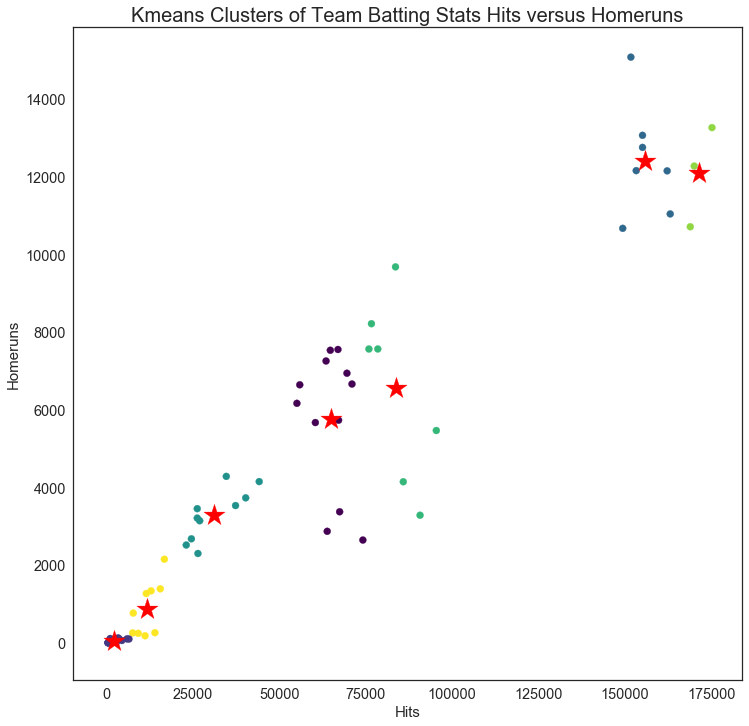

In [414]:
plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batting_team['h'], batting_team['hr'],
                c=batting_team['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Team Batting Stats Hits versus Homeruns', fontsize=20)
plt.xlabel('Hits', fontsize=15)
plt.ylabel('Homeruns', fontsize=15);

## HDBSCAN

In [415]:
# ss = StandardScaler()
# batters_years = ss.fit_transform(batters_years)

In [416]:
hdb = HDBSCAN(min_cluster_size=6)
hdb.fit(batting_team)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=6, min_samples=None, p=None,
    prediction_data=False)

In [417]:
# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

-1     6
 0    10
 1    19
 2     6
 3    28
dtype: int64

In [418]:
# batters_years[batters_years['hdb_clusters'] == 2]

In [419]:
batting_team['hdb_clusters'] = hdb.labels_

In [420]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_team,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [421]:
show_cluster_results(2, 'hdb_clusters')

g      ab      r      h    2b   3b    hr      rbi      sb     cs  \
teamid                                                                         
ML1     18728   61600   8699  16802  2661  526  2152   8252.0   638.0  363.0   
WAS     28926   98190  14099  26507  4747  984  2300  12861.0  2785.0  431.0   
ARI     30034   98219  13638  26308  5405  772  3211  12935.0  1763.0  708.0   
MIL     30901   99008  13558  26308  5378  553  3454  12947.0  1948.0  768.0   
LAA     25899   86855  11622  23127  4287  440  2518  11130.0  1628.0  689.0   
TBA     31199  104295  13565  27016  5343  644  3143  12992.0  2278.0  900.0   

            ...          sf    gidp     1b  period   bavg    obp    ops  \
teamid      ...                                                           
ML1         ...       453.0  1397.0  11463   3.391  0.263  0.324  0.736   
WAS         ...       521.0  1469.0  18476   4.355  0.262  0.332  0.724   
ARI         ...       811.0  2102.0  16920   6.590  0.261  0.330  0.752   
MIL         ...       748.0  2281.0  16923   6.606  0.260  0.331  0.752   
LAA         ...       748.0  2048.0  15882   6.235  0.257  0.321  0.717   
TBA         ...       867.0  2216.0  17886   6.581  0.252  0.319  0.719   

          slg  kmeans_clusters  hdb_clusters  
teamid                                        
ML1     0.412                6             2  
WAS     0.392                3             2  
ARI     0.422                3             2  
MIL     0.422                3             2  
LAA     0.396                3             2  
TBA     0.400                3             2  

[6 rows x 25 columns]

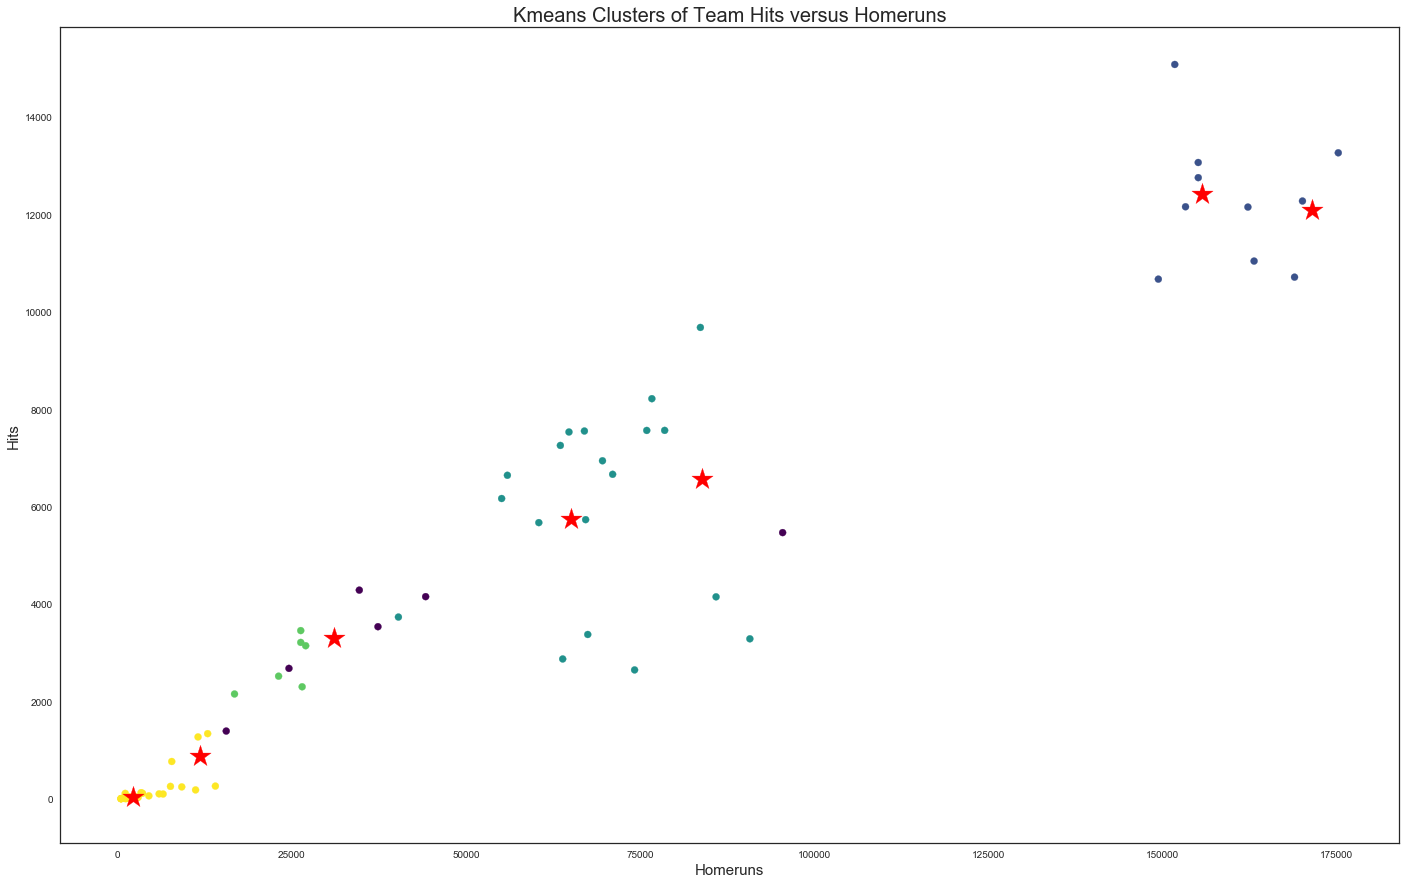

In [422]:

plt.figure(figsize=(24,15))
plt.scatter(batting_team['h'], batting_team['hr'],
           c=batting_team['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Team Hits versus Homeruns', fontsize=20)
plt.xlabel('Homeruns', fontsize=15)
plt.ylabel('Hits', fontsize=15)

plt.show()

# Model the Data

In [423]:
# Define my x and y
# we will test one cluster at a time
features = [each for each in batting_team.columns if each not in ['kmeans_clusters','hdb_clusters']]
X = batting_team[features]
y = batting_team['kmeans_clusters']

In [424]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [425]:
X_train.head()

g      ab      r       h     2b    3b     hr      rbi       sb  \
teamid                                                                        
SL5       1995    7498    901    1749    290    66     38    659.0    154.0   
PHA      70380  244294  33609   67500  11476  3096   3374  29925.0   4792.0   
CLE     166039  561973  76891  153291  27402  4987  12157  71112.0  10523.0   
MIL      30901   99008  13558   26308   5378   553   3454  12947.0   1948.0   
NY3        490    2093    255     484     39    12      2    156.0      0.0   

            cs  ...       hbp      sh      sf    gidp      1b  period   bavg  \
teamid          ...                                                            
SL5        0.0  ...       0.0     0.0     0.0     0.0    1355   0.000  0.216   
PHA     1694.0  ...    1524.0  5975.0    29.0  1834.0   49554   1.889  0.266   
CLE     4795.0  ...    4037.0  9221.0  2858.0  9063.0  108745   3.744  0.265   
MIL      768.0  ...    1260.0   531.0   748.0  2281.0   16923   6.606  0.260   
NY3        0.0  ...       0.0     0.0     0.0     0.0     431   0.000  0.230   

          obp    ops    slg  
teamid                       
SL5     0.255  0.533  0.278  
PHA     0.331  0.700  0.369  
CLE     0.330  0.718  0.388  
MIL     0.331  0.752  0.422  
NY3     0.236  0.499  0.262  

[5 rows x 23 columns]

In [426]:
y_train.head()

teamid
SL5    1
PHA    0
CLE    2
MIL    3
NY3    1
Name: kmeans_clusters, dtype: int32

In [427]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   32.1s finished


building tree 1 of 10building tree 2 of 10

building tree 3 of 10building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.9607843137254902

In [428]:
gs_rf.best_params_

{'rf__criterion': 'entropy',
 'rf__n_estimators': 10,
 'rf__n_jobs': -1,
 'rf__random_state': 42,
 'rf__verbose': 2}

In [429]:
gs_rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


0.8888888888888888

In [430]:
y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


array([[3, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0],
       [0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2]], dtype=int64)

In [431]:
# pipe_lr = Pipeline([
#     ('ss', StandardScaler()),
#     ('lr', LogisticRegressionCV())
# ])

# params = {
#     'lr__Cs': [10, 50, 100],
#     'lr__cv': [3,5,7,9],
#     'lr__penalty': ['l2'],
#     'lr__max_iter': [10,100,1000],
#     'lr__verbose': [2],
#     'lr__n_jobs': [-1],
#     'lr__random_state': [42]
# }
# gs_lr = GridSearchCV(pipe_lr, params, n_jobs=-1, cv=5, verbose=2)
# gs_lr.fit(X_train, y_train)
# gs_lr.best_score_

In [432]:
# gs_lr.best_params_

In [433]:
# gs_lr.score(X_test, y_test)

In [434]:
# y_preds_gs_lr = gs_lr.predict(X_test)

# confusion_matrix(y_test, y_preds_gs_lr)

## Batting team year

## PCA first

In [435]:
batting_team_year.columns

Index(['g', 'ab', 'r', 'h', '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so',
       'ibb', 'hbp', 'sh', 'sf', 'gidp', '1b', 'period', 'bavg', 'obp', 'ops',
       'slg'],
      dtype='object')

### Scale data for use with PCA

We already did this above

### Find Z scores

In [436]:
batting_team_year_ss

g        ab         r         h        2b        3b        hr  \
0     0.964788  1.538076  1.473899  1.423038  1.078306 -0.958853  0.926361   
1     0.543359  0.829367  0.756237  0.847767  1.416476 -0.860772  0.601094   
2     0.421500  0.740532  0.283423  0.321983  0.282613 -1.204055  0.789407   
3     0.655063  1.239984  1.549887  1.392109  1.575615 -0.517490  2.141831   
4     0.634753  0.963607  0.165220  0.693125  0.919168 -0.958853  0.738049   
5     0.578901  1.034675  1.288151  1.367366  1.874000 -0.615571  0.755168   
6     1.086647  0.947814  0.460728  0.792096  0.939060 -0.664611  0.720929   
7     0.517972  1.196553  1.313481  1.614794  0.779921 -0.321329  0.840764   
8     0.903859  0.722765 -0.104959  0.136411  0.163259  0.021953  0.875003   
9     0.665218  0.855031  1.870725  1.225095  1.018629  0.070994  1.782325   
10   -0.223336 -0.351156  0.477615 -0.061531  0.580998 -0.272288  1.011957   
11    1.106957  0.655645  1.144619  0.773539  0.998737 -0.566530  1.696729   
12    0.766767  0.377294  1.051745  0.594153  0.919168 -0.272288  0.909242   
13    1.381139  1.024805  0.494501  0.928181  1.535830  0.120034  0.789407   
14   -0.527984 -0.434069 -0.940825 -0.407930  0.580998 -0.370369  0.155993   
15    1.030795  0.564835  0.173663  0.346725  1.137983 -0.909813  1.439940   
16    0.538282  0.762247  0.739350  0.866324  1.774538 -0.321329  0.909242   
17    0.634753  0.195675  0.114562 -0.209988  0.819706 -0.272288  1.046196   
18    0.721070  0.298329  0.300310 -0.092459  1.515938  0.169074  0.857884   
19    0.436733  0.306226  0.139891  0.006512  1.118091 -0.125168  0.960599   
20    0.182860  0.142374  0.072346 -0.271845  0.939060 -0.468450  1.148912   
21    0.061001 -0.098469  0.207436 -0.414116  0.899275 -0.321329  0.840764   
22   -0.380737 -0.363000  0.038574 -0.234731  1.018629 -0.762692  0.806526   
23    0.248867  0.521405 -0.096516  0.458068  1.038522 -0.762692  0.344305   
24   -0.040548  0.272666 -0.628431 -0.104831  0.421859  0.070994  0.087516   
25    0.589056  0.635904  0.232765  0.656010  1.038522  0.120034  0.720929   
26    0.538282  0.586551  0.401627  0.600339  1.038522  0.365236  1.166031   
27    0.782000  0.592473  0.975757  0.210640  1.515938 -0.370369  1.850803   
28    0.619521  0.549042  0.654919  0.637453 -0.234588 -0.713651  1.748087   
29    0.213325  0.096969 -0.518670 -0.469787 -0.771681 -0.860772  0.857884   
...        ...       ...       ...       ...       ...       ...       ...   
2664 -0.243646 -0.037271 -0.679089 -0.055345  0.521321  0.855639 -0.768449   
2665 -0.243646 -0.463680 -1.650045 -1.032686 -1.129743  0.070994 -1.059477   
2666  0.446888 -0.175459 -0.898610 -0.803815 -0.612542  1.198921 -1.247789   
2667  0.040691 -0.080701 -0.881723 -0.327516 -0.473296 -0.125168 -0.391825   
2668 -0.269033 -0.268243 -0.104959 -0.191431 -0.930819  0.316195 -0.528779   
2669 -0.076090  0.201598 -0.138731  0.154969  0.163259  0.021953 -0.888284   
2670 -0.649843 -0.599895 -0.966154 -1.026500 -0.572757 -0.223248 -0.973881   
2671 -1.025574 -0.777565 -0.299150 -0.550201 -0.234588  0.267155 -0.682853   
2672  0.066079 -0.072805 -0.392024 -0.401745 -0.831358  1.149881 -0.426063   
2673 -0.020238 -0.678859 -0.932382 -0.859487 -1.249097  0.365236 -0.545898   
2674  0.330106 -0.287984 -0.417353 -0.488344 -0.692111  0.610437 -0.015200   
2675  0.101621 -0.412353 -0.873280 -0.723401 -0.532973 -0.419409  0.019038   
2676  0.233635 -0.532775 -1.168789 -0.970829 -1.368451 -0.615571  0.207351   
2677 -0.106555 -0.978925 -0.822622 -1.403828 -1.288882 -0.762692  0.909242   
2678  0.594134 -0.291932 -0.138731 -0.624430 -0.672219 -0.223248  0.618214   
2679  0.624599  0.057487 -0.535557 -0.463602 -0.334049 -0.027087  0.173112   
2680  1.320210  0.558913 -0.653760  0.167340 -0.373834 -0.517490  0.429901   
2681  0.624599  0.233183 -0.864837 -0.810001 -0.731896 -0.517490  0.498379   
2682  0.929246  0.219365 -0.873280 -0.673915 -0.692111 -0.762692  0.224470   
2683  1.436991  0.304252 -0.763520 

### Visualize correlation

In [437]:
# g = sns.PairGrid(batting_team_year_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

Text(0.5,1,'Batting Stats by Team Year Correlation')

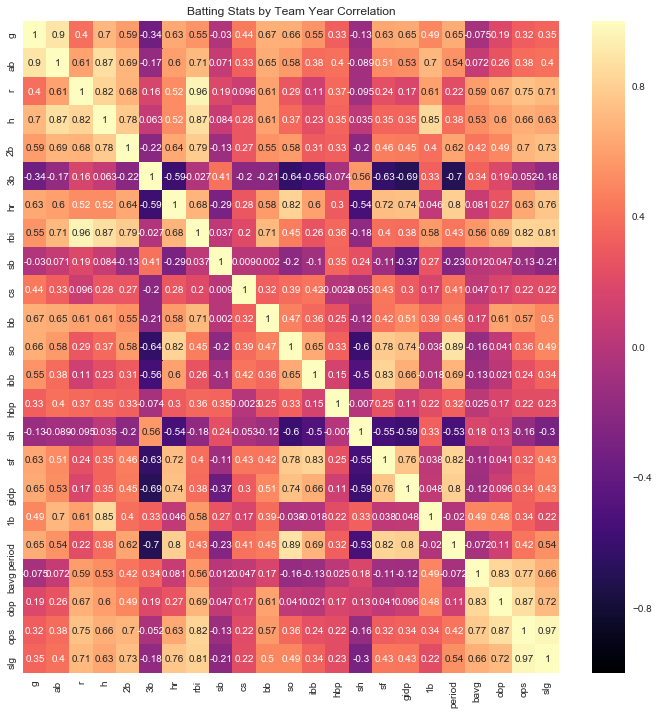

In [438]:
plt.figure(figsize=(12,12))
sns.heatmap(batting_team_year_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Batting Stats by Team Year Correlation')

### PCA for batting stats

In [451]:
batting_team_year_pca = PCA(n_components=23)
batting_team_year_pca.fit(batting_team_year_ss.values)

PCA(copy=True, iterated_power='auto', n_components=23, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Explained variance

In [452]:
for each in batting_team_year_pca.components_:
    for each in list(zip(batting_team_year_ss.columns, each)):
        print(each)
    print()

('g', -0.24407451465094154)
('ab', -0.24994266985683045)
('r', -0.2257664202511803)
('h', -0.25386477852410666)
('2b', -0.2613181152725338)
('3b', 0.12307240515009074)
('hr', -0.2715553583905836)
('rbi', -0.27088514941699365)
('sb', 0.03600328218624943)
('cs', -0.1291483838205854)
('bb', -0.23478775400420626)
('so', -0.23845657664290523)
('ibb', -0.1854860519698338)
('hbp', -0.12119848974284379)
('sh', 0.11705178251177817)
('sf', -0.22572536256682252)
('gidp', -0.22221121438663172)
('1b', -0.13517626279689549)
('period', -0.243592454099573)
('bavg', -0.10513451230153856)
('obp', -0.17017691606581492)
('ops', -0.23995136856657423)
('slg', -0.2523807128228052)

('g', -0.06854290502405513)
('ab', 0.04042104386690504)
('r', 0.2518456581749504)
('h', 0.2089901325832243)
('2b', 0.07548745251256184)
('3b', 0.345245375486733)
('hr', -0.13508966022479094)
('rbi', 0.1850200361940974)
('sb', 0.15909638112210983)
('cs', -0.06689191187125278)
('bb', 0.05921027989425029)
('so', -0.23303945880013116)

In [453]:
batting_team_year_pca.explained_variance_

array([1.01864698e+01, 4.86782300e+00, 2.18600913e+00, 1.23137438e+00,
       1.00448247e+00, 6.94187181e-01, 6.51061928e-01, 5.24364021e-01,
       3.43573639e-01, 2.96983611e-01, 2.51753887e-01, 2.23696261e-01,
       1.49531511e-01, 1.31365689e-01, 9.31996239e-02, 6.97164938e-02,
       5.09559977e-02, 1.76582453e-02, 1.38507649e-02, 1.14872334e-02,
       8.94356565e-03, 5.22555586e-05, 5.35266132e-31])

In [454]:
batting_team_year_pca.explained_variance_ratio_

array([4.42725592e-01, 2.11565917e-01, 9.50085952e-02, 5.35181434e-02,
       4.36569397e-02, 3.01708479e-02, 2.82965329e-02, 2.27899730e-02,
       1.49324394e-02, 1.29075379e-02, 1.09417582e-02, 9.72231418e-03,
       6.49895675e-03, 5.70943158e-03, 4.05065342e-03, 3.03002676e-03,
       2.21465579e-03, 7.67464809e-04, 6.01983634e-04, 4.99259541e-04,
       3.88706341e-04, 2.27113746e-06, 2.32638019e-32])

### Transform batting team year stats into PCA space

In [455]:
batting_team_year_pca_transformed = batting_team_year_pca.transform(batting_team_ss)

In [456]:
batting_team_year_pca_transformed = pd.DataFrame(batting_team_year_pca_transformed,
                                       columns=batting_team_year_ss.columns)

batting_team_year_pca_transformed

g        ab         r         h        2b        3b        hr  \
0   1.045491 -0.132622  2.553744 -0.006862  0.126808 -0.515513 -0.258910   
1  -0.210652 -0.294062  2.119776  0.199824  0.302027 -0.467735 -0.235066   
2  -2.604718 -0.656648  0.147382 -0.089881  0.927453  0.103667 -0.089404   
3  -3.578798 -0.646907 -0.495848  0.075744  0.595212 -0.023139  0.042459   
4   3.453880 -0.682772  1.093138 -0.170148 -1.056830  0.488797 -0.190856   
5   2.066078  1.119295  3.365100 -0.326415  0.177832 -0.115750 -0.127351   
6   1.715443  1.959657  3.116887 -0.004249  0.499275 -0.131995  0.012616   
7  -6.533982  1.989421 -2.873800 -0.274829  0.936275 -0.562766  0.133273   
8  -0.659652  2.697714 -1.064126  0.250514 -0.263702 -0.365895  0.358286   
9  -0.235226  2.424183 -1.800167  0.281150 -0.764437 -0.325109  0.318327   
10 -0.148258 -0.705971  0.424353 -0.258933  0.315634 -0.147762  0.010894   
11 -5.634717  1.949075 -4.061106 -0.216213  1.792334 -0.913763  0.118795   
12 -6.647964  2.736576 -4.274204  0.431972  1.028892  0.064748  0.138473   
13 -6.239215  2.393018 -4.060387  0.447955  1.588525  0.022190  0.106504   
14  4.167536 -1.659435  0.006136 -0.069058 -1.544244  0.632495 -0.002420   
15  2.530170  0.631529  1.578556 -0.047085 -0.347946  0.233066  0.301195   
16 -6.133690  2.078804 -3.294847 -0.345441  1.350182 -0.778431 -0.027777   
17  4.013946 -1.241442  0.490951 -0.154623 -1.287259  0.588584 -0.151602   
18 -1.193771  0.531498  2.685819  0.095273  0.836661 -0.569953 -0.482399   
19 -6.241923  2.219802 -3.274172 -0.355416  1.230856 -0.592073  0.194329   
20  3.339684 -0.665257  0.957251 -0.055847 -1.014881  0.469713  0.059482   
21 -0.028702 -0.114884  2.113316  0.143598  0.466197 -0.555137 -0.191942   
22  3.952136 -1.014395  0.794010 -0.201808 -1.134386  0.565371 -0.290028   
23 -2.657478 -0.607048 -0.528896  0.105820  1.361031  0.112750 -0.190917   
24  4.390986 -1.690142  0.048547 -0.115374 -1.461415  0.631121 -0.021653   
25  3.660758 -1.004800  0.697359  0.000810 -1.024874  0.424791  0.291442   
26  1.622260 -0.527761  1.563114 -0.128598 -0.358774 -0.094729  0.103277   
27 -2.152394 -0.335973 -0.207370  0.070629  0.997451  0.018147 -0.410865   
28  4.285801 -1.857959 -0.035099 -0.021171 -1.507186  0.544983  0.319495   
29  0.486531 -0.603316  1.679206  0.082952  0.034791 -0.386987 -0.189164   
..       ...       ...       ...       ...       ...       ...       ...   
39  3.055951 -0.184847  1.890659 -0.243041 -0.518074  0.135066  0.053545   
40 -0.819009 -0.489901  0.597903 -0.080096  0.921948 -0.009891 -0.135401   
41 -1.219063  3.109299 -1.189400  0.717667 -0.084690 -0.247747  0.290779   
42  5.034202 -2.487807 -0.940485 -0.043329 -1.917860  0.828911 -0.025952   
43 -6.665664  2.032896 -2.753576  0.142255  1.294657 -0.362812  0.363966   
44 -2.563519 -0.866022 -0.427159 -0.000238  0.976408  0.171007 -0.058076   
45 -2.344391 -0.753189 -0.260548  0.216806  0.698430 -0.172047  0.113827   
46 -0.053935  2.134420 -0.232822 -0.457154 -0.062123 -0.789362  0.232987   
47 -6.506125  2.359105 -4.213978  0.634995  1.002292  0.012597  0.145100   
48  3.271835 -0.094946  1.982530 -0.283656 -0.619143  0.390868 -0.541082   
49 -6.213492  2.844129 -4.207454  0.524987  1.414934  0.094157 -0.117588   
50  3.514404 -0.756381  0.931076 -0.182458 -1.105606  0.499314 -0.073286   
51 -1.816698 -0.831703 -0.206760 -0.045924  0.882573  0.115358 -0.068693   
52  2.554450 -0.787187  1.864848 -0.053700 -0.499980 -0.243479  0.304353   
53 -1.566528 -0.757577  0.253759  0.181653  0.456288 -0.214258 -0.143097   
54 -3.268749 -0.588883 -0.304011 -0.075430  1.305808  0.270037 -0.111163   
55  4.215641 -1.459775  0.291432 -0.138474 -1.354176  0.600043 -0.060354   
56  4.753570 -2.474312 -0.862177  0.033834 -1.863099  0.685707  0.434899   
57  0.254520  1.760114 -0.428584 -0.621245 -0.002449 -0.739308  0.255378   
58 -6.306139  2.579097 -3.675830  0.259258  1.645127  0.108566 -0.055110   
59  5.045266 -2.604333 -1.011910 -0.002159 -1.976062  0.825

### Visualize transformed PCA features
-There should be no correlation

In [457]:
# sns.pairplot(batting_team_year_pca_transformed)

## Now  KMeans Clustering

In [458]:
batting_team_year[batting_team_year.columns]

g    ab    r     h   2b  3b   hr    rbi     sb    cs  ...    \
teamid year                                                           ...     
ANA    1997  1599  5506  817  1505  274  24  158  757.0  124.0  72.0  ...     
       1998  1516  5147  732  1412  291  26  139  696.0   84.0  42.0  ...     
       1999  1492  5102  676  1327  234  19  150  635.0   68.0  42.0  ...     
       2000  1538  5355  826  1500  299  33  229  801.0   89.0  48.0  ...     
       2001  1534  5215  662  1387  266  24  147  642.0  114.0  47.0  ...     
       2002  1523  5251  795  1496  314  31  148  768.0  110.0  43.0  ...     
       2003  1623  5207  697  1403  267  30  146  668.0  123.0  56.0  ...     
       2004  1511  5333  798  1536  259  37  153  746.0  135.0  42.0  ...     
ARI    1998  1587  5093  630  1297  228  44  155  605.0   71.0  38.0  ...     
       1999  1540  5160  864  1473  271  45  208  822.0  133.0  38.0  ...     
       2000  1365  4549  699  1265  249  38  163  653.0   85.0  38.0  ...     
       2001  1627  5059  778  1400  270  32  203  743.0   70.0  38.0  ...     
       2002  1560  4918  767  1371  266  38  157  729.0   92.0  46.0  ...     
       2003  1681  5246  701  1425  297  46  150  678.0   76.0  38.0  ...     
       2004  1305  4507  531  1209  249  36  113  475.0   48.0  31.0  ...     
       2005  1612  5013  663  1331  277  25  188  643.0   66.0  24.0  ...     
       2006  1515  5113  730  1415  309  37  157  696.0   73.0  28.0  ...     
       2007  1534  4826  656  1241  261  38  165  643.0  106.0  22.0  ...     
       2008  1551  4878  678  1260  296  47  154  630.0   57.0  23.0  ...     
       2009  1495  4882  659  1276  276  41  160  618.0   94.0  38.0  ...     
       2010  1445  4799  651  1231  267  34  171  629.0   84.0  39.0  ...     
       2011  1421  4677  667  1208  265  37  153  612.0  126.0  53.0  ...     
       2012  1334  4543  647  1237  271  28  151  625.0   89.0  44.0  ...     
       2013  1458  4991  631  1349  272  28  124  594.0   52.0  38.0  ...     
       2014  1401  4865  568  1258  241  45  109  526.0   80.0  31.0  ...     
       2015  1525  5049  670  1381  272  46  146  626.0  130.0  42.0  ...     
       2016  1515  5024  690  1372  272  51  172  653.0  129.0  30.0  ...     
       2017  1563  5027  758  1309  296  36  212  735.0  102.0  29.0  ...     
ATL    1966  1531  5005  720  1378  208  29  206  697.0   54.0  45.0  ...     
       1967  1451  4776  581  1199  181  26  154  557.0   53.0  43.0  ...     
...           ...   ...  ...   ...  ...  ..  ...    ...    ...   ...  ...     
WS1    1946  1361  4708  562  1266  246  61   59  515.0   47.0  47.0  ...     
       1947  1361  4492  447  1108  163  45   42  421.0   45.0  49.0  ...     
       1948  1497  4638  536  1145  189  68   31  504.0   75.0  46.0  ...     
       1949  1417  4686  538  1222  196  41   81  511.0   46.0  32.0  ...     
       1950  1356  4591  630  1244  173  50   73  608.0   41.0  24.0  ...     
       1951  1394  4829  626  1300  228  44   52  597.0   45.0  37.0  ...     
       1952  1281  4423  528  1109  191  39   47  468.0   46.0  37.0  ...     
       1953  1207  4333  607  1186  208  49   64  574.0   61.0  35.0  ...     
       1954  1422  4690  596  1210  178  67   79  560.0   37.0  21.0  ...     
       1955  1405  4383  532  1136  157  51   72  510.0   23.0  30.0  ...     
       1956  1474  4581  593  1196  185  56  103  555.0   37.0  29.0  ...     
       1957  1429  4518  539  1158  193  35  105  515.0   12.0  35.0  ...     
       1958  1455  4457  504  1118  151  31  116  490.0   22.0  37.0  ...     
       1959  1388  4231  545  1048  155  28  157  536.0   46.0  32.0  ...     
       1960  1526  4579  626  1174  186  39  140  574.0   52.0  42.0  ...     
WS2    1961  1532  4756  579  1200  203  43  114  544.0   76.0  46.0  ...     
       1962  1669  5010  565  1302  201  33  129  544.0   98.0  52.0  ...     
       1963  1532  4845  540  1144  183  33  133  507.0   62.0  28

In [459]:
# Fitting batting team data on KMeans
# batting_team_year_cluster = batting_team_year[batting_team_year.columns]
km = KMeans(n_clusters=7,
           random_state=42)
km.fit(batting_team_year)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [460]:
centroids = pd.DataFrame(km.cluster_centers_, columns = batting_team_year.columns)

In [461]:
#looking at labels
km.labels_

array([5, 5, 5, ..., 1, 4, 4])

In [462]:
#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

3    691
5    605
2    477
0    437
4    325
1    105
6     54
dtype: int64

In [463]:
#saving labels to clustering data frame
batting_team_year['kmeans_clusters'] = km.labels_

In [464]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_team_year,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [465]:
show_cluster_results(6, 'kmeans_clusters')[batting_team_year.columns]

g    ab    r    h   2b  3b  hr    rbi     sb    cs  \
teamid year                                                         
CHN    1876  587  2712  618  915  128  32   8  439.0    0.0   0.0   
BSN    1877  545  2349  415  697   91  37   4  290.0    0.0   0.0   
CHN    1878  516  2196  351  646   87  19   3  279.0    0.0   0.0   
       1877  437  1853  310  540   72  28   0  219.0    0.0   0.0   
LS1    1877  539  2312  336  654   74  35   9  248.0    0.0   0.0   
PHN    1876  468  2084  333  590   72  34   7  233.0    0.0   0.0   
CHN    1880  756  3060  531  863  163  37   4  375.0    0.0   0.0   
CN1    1878  537  2232  329  617   67  22   5  220.0    0.0   0.0   
       1877  337  1402  205  380   52  25   5  162.0    0.0   0.0   
BFN    1882  733  3035  488  844  146  46  18  375.0    0.0   0.0   
PIT    1981  885  2938  358  792  157  27  47  330.0  117.0  49.0   
BFN    1881  712  2879  428  773  152  50  12  342.0    0.0   0.0   
BSN    1882  750  3062  466  808  113  50  15  364.0    0.0   0.0   
       1876  590  2565  452  694   94  23   9  267.0    0.0   0.0   
DTN    1881  669  2663  409  708  117  50  17  321.0    0.0   0.0   

                  ...           sh    sf  gidp   1b  period   bavg    obp  \
teamid year       ...                                                       
CHN    1876       ...          0.0   0.0   0.0  747       0  0.326  0.343   
BSN    1877       ...          0.0   0.0   0.0  565       0  0.294  0.312   
CHN    1878       ...          0.0   0.0   0.0  537       0  0.291  0.316   
       1877       ...          0.0   0.0   0.0  440       0  0.287  0.301   
LS1    1877       ...          0.0   0.0   0.0  536       0  0.283  0.299   
PHN    1876       ...          0.0   0.0   0.0  477       0  0.279  0.287   
CHN    1880       ...          0.0   0.0   0.0  659       0  0.277  0.299   
CN1    1878       ...          0.0   0.0   0.0  523       0  0.276  0.294   
       1877       ...          0.0   0.0   0.0  298       0  0.271  0.295   
BFN    1882       ...          0.0   0.0   0.0  634       0  0.267  0.291   
PIT    1981       ...         24.0  29.0  50.0  561       5  0.266  0.322   
BFN    1881       ...          0.0   0.0   0.0  559       0  0.264  0.287   
BSN    1882       ...          0.0   0.0   0.0  630       0  0.262  0.293   
       1876       ...          0.0   0.0   0.0  568       0  0.262  0.277   
DTN    1881       ...          0.0   0.0   0.0  524       0  0.262  0.292   

               ops    slg  kmeans_clusters  
teamid year                                 
CHN    1876  0.743  0.400                6  
BSN    1877  0.682  0.370                6  
CHN    1878  0.667  0.351                6  
       1877  0.652  0.352                6  
LS1    1877  0.656  0.356                6  
PHN    1876  0.639  0.351                6  
CHN    1880  0.654  0.355                6  
CN1    1878  0.625  0.331                6  
       1877  0.649  0.355                6  
BFN    1882  0.650  0.359                6  
PIT    1981  0.709  0.387                6  
BFN    1881  0.647  0.360                6  
BSN    1882  0.638  0.345                6  
       1876  0.603  0.326                6  
DTN    1881  0.654  0.362                6  

[15 rows x 24 columns]

In [466]:
# sse = {}
# for k in range(1, 15):
#     kmeans = KMeans(n_clusters=k, max_iter=1000000).fit(batters)
#     batters["clusters"] = kmeans.labels_
#     #print(batters["clusters"])
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
# plt.figure(figsize=(10,10))
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.title('KMeans Elbow', fontsize=15)
# plt.xlabel("Number of cluster", fontsize=13)
# plt.ylabel("Sum of Squared Errors", fontsize=13)
# plt.show()

In [467]:
# ks = range(2,16)
# sil = []

# for n_cluster in range(2, 16):
#     kmeans = KMeans(n_clusters=n_cluster).fit(batters)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(batters, label, metric='euclidean')
#     print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
#     sil.append(sil_coeff)

In [468]:
# plt.plot(ks, sil, '-o')
# plt.title('Silhouette Score');

In [469]:
# # Call k-means to cluster the stats
# kmeans = KMeans(n_clusters=7, random_state=42)
# model = kmeans.fit(batting_team)
# centroids = pd.DataFrame(model.cluster_centers_, columns = batting_year.columns)

In [470]:
batting_team_year.columns

Index(['g', 'ab', 'r', 'h', '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so',
       'ibb', 'hbp', 'sh', 'sf', 'gidp', '1b', 'period', 'bavg', 'obp', 'ops',
       'slg', 'kmeans_clusters'],
      dtype='object')

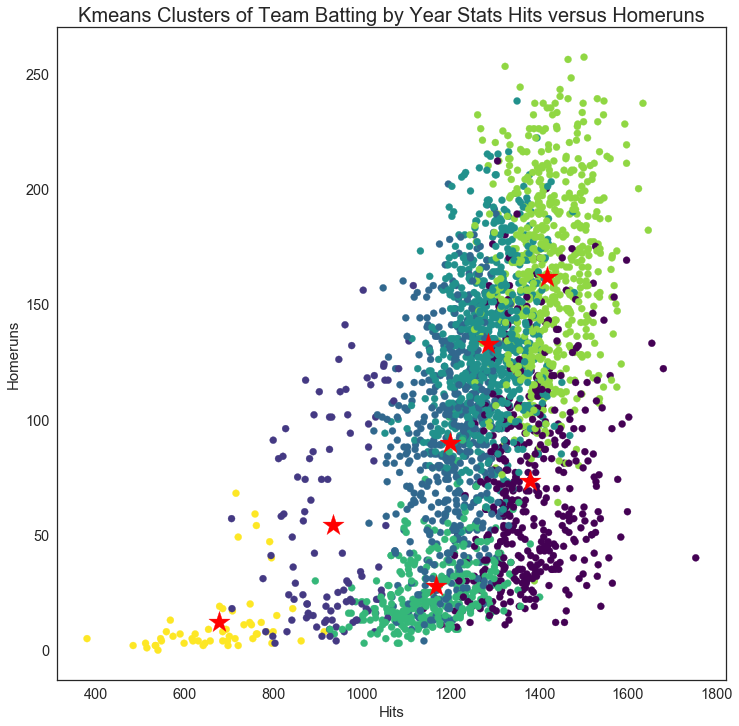

In [471]:
plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batting_team_year['h'], batting_team_year['hr'],
                c=batting_team_year['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Team Batting by Year Stats Hits versus Homeruns', fontsize=20)
plt.xlabel('Hits', fontsize=15)
plt.ylabel('Homeruns', fontsize=15);

## HDBSCAN

In [472]:
hdb = HDBSCAN(min_cluster_size=6)
hdb.fit(batting_team_year)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=6, min_samples=None, p=None,
    prediction_data=False)

In [473]:
# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

-1     301
 0      16
 1      43
 2      27
 3     150
 4      12
 5    2145
dtype: int64

In [474]:
batting_team_year['hdb_clusters'] = hdb.labels_

In [475]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_team_year,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [476]:
show_cluster_results(2, 'hdb_clusters')

g    ab    r    h   2b  3b  hr    rbi   sb   cs      ...       \
teamid year                                                         ...        
CHN    1880  756  3060  531  863  163  37   4  375.0  0.0  0.0      ...        
BSN    1879  755  3197  560  876  137  51  20  392.0  0.0  0.0      ...        
BFN    1882  733  3035  488  844  146  46  18  375.0  0.0  0.0      ...        
       1881  712  2879  428  773  152  50  12  342.0  0.0  0.0      ...        
BSN    1882  750  3062  466  808  113  50  15  364.0  0.0  0.0      ...        
DTN    1881  669  2663  409  708  117  50  17  321.0  0.0  0.0      ...        
WOR    1881  708  2940  402  762  113  31   7  268.0  0.0  0.0      ...        
CN1    1879  714  3016  474  800  127  53   8  357.0  0.0  0.0      ...        
CHN    1879  729  3050  432  797  166  32   3  288.0  0.0  0.0      ...        
CL2    1881  718  2925  384  764  118  38   7  270.0  0.0  0.0      ...        
PRO    1882  683  2818  434  734  119  53  11  301.0  0.0  0.0      ...        
       1881  735  2941  432  751  140  36  11  308.0  0.0  0.0      ...        
NY1    1883  823  3300  513  867  136  68  24  358.0  0.0  0.0      ...        
BFN    1879  706  2870  386  721  104  54   2  271.0  0.0  0.0      ...        
PRO    1880  769  3137  414  785  114  34   8  277.0  0.0  0.0      ...        

              sf  gidp   1b  period   bavg    obp    ops    slg  \
teamid year                                                       
CHN    1880  0.0   0.0  659       0  0.277  0.299  0.654  0.355   
BSN    1879  0.0   0.0  668       0  0.273  0.292  0.651  0.360   
BFN    1882  0.0   0.0  634       0  0.267  0.291  0.650  0.359   
       1881  0.0   0.0  559       0  0.264  0.287  0.647  0.360   
BSN    1882  0.0   0.0  630       0  0.262  0.293  0.638  0.345   
DTN    1881  0.0   0.0  524       0  0.262  0.292  0.654  0.362   
WOR    1881  0.0   0.0  611       0  0.259  0.286  0.607  0.321   
CN1    1879  0.0   0.0  612       0  0.258  0.273  0.609  0.336   
CHN    1879  0.0   0.0  596       0  0.257  0.273  0.605  0.332   
CL2    1881  0.0   0.0  601       0  0.256  0.284  0.605  0.321   
PRO    1882  0.0   0.0  551       0  0.253  0.276  0.616  0.341   
       1881  0.0   0.0  564       0  0.252  0.286  0.618  0.333   
NY1    1883  0.0   0.0  639       0  0.248  0.271  0.614  0.343   
BFN    1879  0.0   0.0  561       0  0.248  0.268  0.590  0.322   
PRO    1880  0.0   0.0  629       0  0.246  0.266  0.580  0.314   

             kmeans_clusters  hdb_clusters  
teamid year                                 
CHN    1880                6             2  
BSN    1879                1             2  
BFN    1882                6             2  
       1881                6             2  
BSN    1882                6             2  
DTN    1881                6             2  
WOR    1881                6             2  
CN1    1879                6             2  
CHN    1879                6             2  
CL2    1881                6             2  
PRO    1882                6             2  
       1881                6             2  
NY1    1883                1             2  
BFN    1879                6             2  
PRO    1880                6             2  

[15 rows x 25 columns]

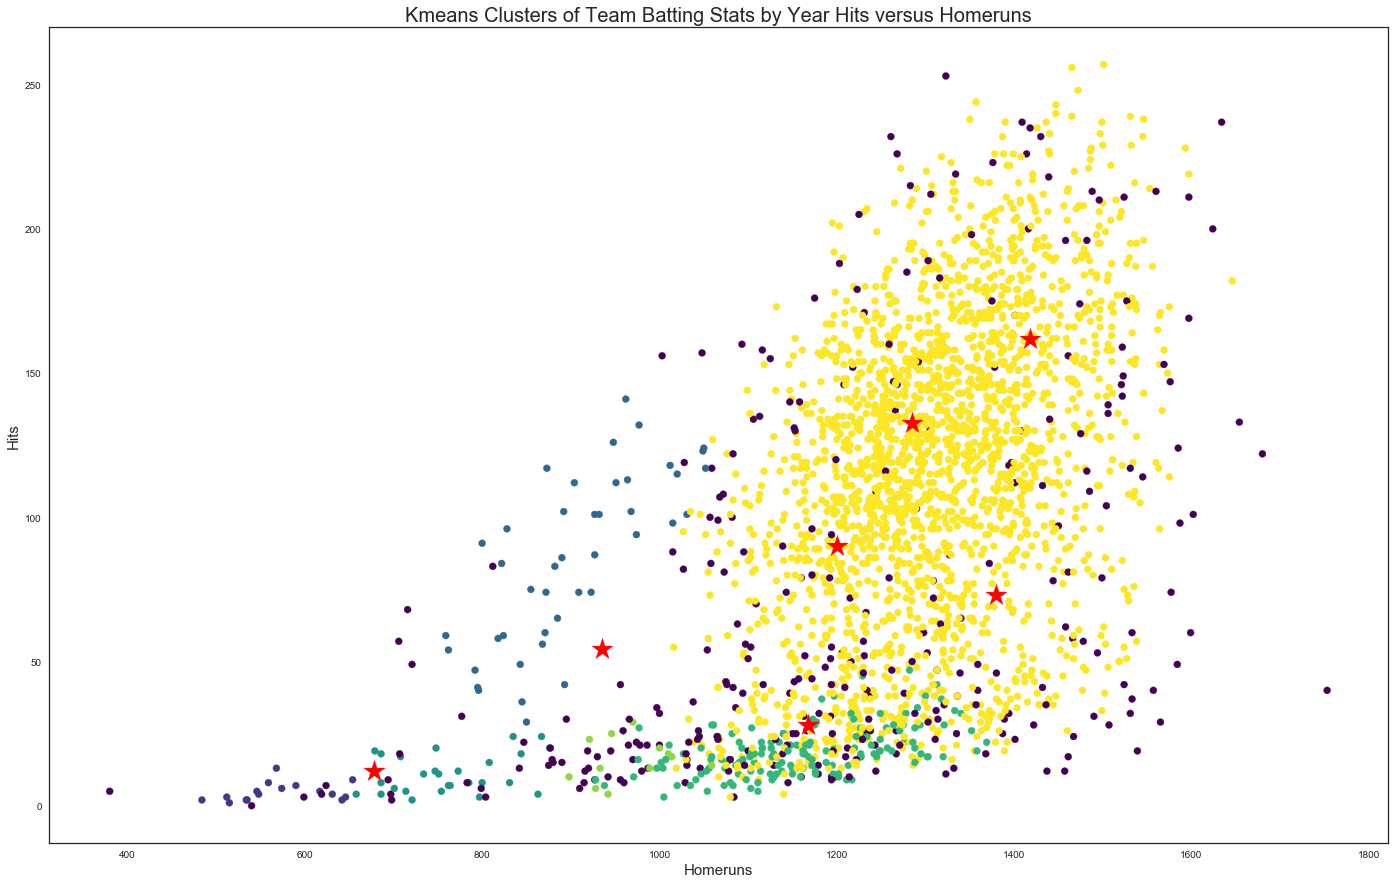

In [477]:

plt.figure(figsize=(24,15))
plt.scatter(batting_team_year['h'], batting_team_year['hr'],
           c=batting_team_year['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Team Batting Stats by Year Hits versus Homeruns', fontsize=20)
plt.xlabel('Homeruns', fontsize=15)
plt.ylabel('Hits', fontsize=15)

plt.show()

# Model the Data

In [478]:
# Define my x and y
# we will test one cluster at a time
features = [each for each in batting_team_year.columns if each not in ['kmeans_clusters','hdb_clusters']]
X = batting_team_year[features]
y = batting_team_year['kmeans_clusters']

In [479]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [480]:
X_train.head()

g    ab    r     h   2b  3b   hr    rbi     sb    cs  ...    \
teamid year                                                           ...     
BOS    2006  1480  5133  759  1407  302  16  184  740.0   43.0  18.0  ...     
PIT    2012  1466  4685  592  1195  220  34  167  582.0   69.0  47.0  ...     
BRO    1902  1171  4409  530  1162  137  46   18  443.0  142.0   0.0  ...     
CIN    1974  1615  5010  742  1358  265  35  134  674.0  146.0  48.0  ...     
NYN    1984  1438  4619  587  1241  213  24  101  541.0  144.0  50.0  ...     

              hbp     sh    sf   gidp   1b  period   bavg    obp    ops    slg  
teamid year                                                                     
BOS    2006  61.0   21.0  55.0  124.0  905       7  0.267  0.346  0.775  0.429  
PIT    2012  48.0   28.0  41.0   88.0  774       7  0.249  0.312  0.719  0.408  
BRO    1902  56.0  111.0   0.0    0.0  961       1  0.252  0.305  0.619  0.315  
CIN    1974  30.0   22.0  44.0  110.0  924       4  0.259  0.340  0.735  0.395  
NYN    1984  18.0   24.0  39.0  114.0  903       5  0.260  0.328  0.693  0.365  

[5 rows x 23 columns]

In [481]:
y_train.head()

teamid  year
BOS     2006    5
PIT     2012    3
BRO     1902    4
CIN     1974    3
NYN     1984    3
Name: kmeans_clusters, dtype: int32

In [482]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   49.2s finished


building tree 1 of 1000building tree 2 of 1000building tree 3 of 1000building tree 4 of 1000



building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000building tree 9 of 1000

building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000building tree 32 of 1000

building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000building tree 36 of 1000

building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.0s


building tree 61 of 1000building tree 62 of 1000


building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000building tree 72 of 1000

building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 80 of 1000
building tree 81 of 1000building tree 82 of 1000

building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000
building tree 86 of 1000
building tree 87 of 1000building tree 88 of 1000

building tree 89 of 1000
building tree 90 of 1000
building tree 91 of 1000
building tree 92 of 1000
building tree 93 of 1000
building tree 94 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 98 of 1000building tree 99 of 1000
building tree 100 of 1000

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    0.4s



building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000building tree 181 of 1000

building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000building tree 197 of 1000

building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000
building tree 202 of 1000
building tree 203 of 1000
building tree 204 of 1000
building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000
building tree 208 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    1.1s


building tree 383 of 1000
building tree 384 of 1000building tree 385 of 1000

building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000building tree 398 of 1000

building tree 399 of 1000
building tree 400 of 1000building tree 401 of 1000

building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000building tree 406 of 1000

building tree 407 of 1000
building tree 408 of 1000
building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000
building tree 412 of 1000
building tree 413 of 1000
building tree 414 of 1000
building tree 415 of 1000
building tree 416 of 1000
building tree 417 of 1000building tree 418 of 1000building tree 419 of 1000


building tree 420 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    2.2s


building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000building tree 650 of 1000

building tree 651 of 1000building tree 652 of 1000
building tree 653 of 1000

building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000building tree 657 of 1000

building tree 658 of 1000
building tree 659 of 1000building tree 660 of 1000building tree 661 of 1000


building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000building tree 665 of 1000building tree 666 of 1000


building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000building tree 672 of 1000

building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000building tree 679 of 1000

building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tre

building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000building tree 977 of 1000

building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000building tree 991 of 1000
building tree 992 of 1000

building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000building tree 998 of 1000
building tree 999 of 1000

building tree 1000 of 1000


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


0.946039603960396

In [483]:
gs_rf.best_params_

{'rf__criterion': 'gini',
 'rf__n_estimators': 1000,
 'rf__n_jobs': -1,
 'rf__random_state': 42,
 'rf__verbose': 2}

In [484]:
gs_rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished


0.9510385756676558

In [485]:
y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished


array([[ 91,   0,   2,   1,   3,   0,   0],
       [  0,  28,   0,   0,   0,   0,   1],
       [  2,   0, 105,   4,   5,   0,   0],
       [  1,   0,   1, 171,   0,   2,   0],
       [  5,   0,   4,   0,  81,   0,   0],
       [  0,   0,   0,   1,   0, 152,   0],
       [  0,   1,   0,   0,   0,   0,  13]], dtype=int64)

In [486]:
# pipe_lr = Pipeline([
#     ('ss', StandardScaler()),
#     ('lr', LogisticRegressionCV())
# ])

# params = {
#     'lr__Cs': [10, 50, 100],
#     'lr__cv': [3,5,7,9],
#     'lr__penalty': ['l2'],
#     'lr__max_iter': [10,100,1000],
#     'lr__verbose': [2],
#     'lr__n_jobs': [-1],
#     'lr__random_state': [42]
# }
# gs_lr = GridSearchCV(pipe_lr, params, n_jobs=-1, cv=5, verbose=2)
# gs_lr.fit(X_train, y_train)
# gs_lr.best_score_

In [487]:
# gs_lr.best_params_

In [488]:
# gs_lr.score(X_test, y_test)

In [489]:
# y_preds_gs_lr = gs_lr.predict(X_test)

# confusion_matrix(y_test, y_preds_gs_lr)

## Batters

## PCA first

In [490]:
batters.columns

Index(['g', 'ab', 'r', 'h', '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so',
       'ibb', 'hbp', 'sh', 'sf', 'gidp', '1b', 'years', 'period', 'bavg',
       'obp', 'ops', 'slg'],
      dtype='object')

### Scale data for use with PCA

We already did this above

### Find Z scores

In [491]:
batters_ss

g        ab         r         h        2b        3b        hr  \
0     4.553473  4.794851  5.734168  5.212296  4.734971  2.969985  9.100476   
1    -0.454507 -0.553026 -0.554027 -0.568281 -0.486663 -0.445184 -0.420707   
2     0.345227  0.414124  0.203080  0.323386  0.037277  0.928308 -0.420707   
3    -0.218108 -0.090636  0.124966 -0.054167 -0.211373  1.039673 -0.305686   
4    -0.707673 -0.663097 -0.653172 -0.674318 -0.619868 -0.445184 -0.535728   
5    -0.692583 -0.687966 -0.605102 -0.642185 -0.548825 -0.593669 -0.356806   
6     0.087032 -0.022936 -0.037271 -0.062200  0.099439  0.185880  0.167178   
7    -0.789826 -0.781918 -0.680212 -0.759468 -0.699791 -0.593669 -0.484607   
8    -0.647315 -0.546118 -0.529992 -0.534543 -0.495543 -0.482305 -0.459047   
9    -0.897127 -0.834881 -0.725277 -0.783567 -0.753073 -0.556548 -0.497388   
10   -0.407563 -0.572369 -0.563040 -0.584347 -0.513304 -0.556548 -0.459047   
11   -0.154397 -0.214063 -0.079333 -0.182695 -0.264655  0.000273 -0.139544   
12    3.051247  2.984900  3.561992  3.106032  4.255433  1.522251  3.132164   
13    0.053500  0.212404  0.194067  0.320173  0.472413 -0.222455  1.036226   
14   -0.652345 -0.670465 -0.629137 -0.642185 -0.477782 -0.482305 -0.484607   
15   -0.746234 -0.663557 -0.644159 -0.632546 -0.628748 -0.296698 -0.535728   
16    0.003203  0.027264 -0.049289 -0.062200  0.001755 -0.073970 -0.011743   
17   -0.773060 -0.746456 -0.668194 -0.709663 -0.744192 -0.519426 -0.548508   
18    0.846528  0.842894  0.296216  0.710579  0.596737  0.000273  0.167178   
19   -0.773060 -0.795734 -0.722273 -0.767501 -0.744192 -0.556548 -0.522948   
20   -0.836770 -0.799419 -0.731286 -0.751435 -0.708671 -0.556548 -0.548508   
21   -0.632226 -0.638688 -0.713260 -0.659858 -0.673150 -0.556548 -0.522948   
22    1.015864  0.896778  0.912117  0.845534  0.827626  0.965430 -0.075644   
23   -0.050448 -0.008198  0.025821 -0.014001  0.010636 -0.259577  0.064937   
24   -0.903834 -0.834881 -0.767339 -0.802846 -0.761953 -0.630791 -0.522948   
25   -0.135955 -0.260578 -0.382777 -0.219647 -0.193612 -0.519426 -0.177885   
26   -0.825034 -0.749219 -0.683216 -0.709663 -0.744192 -0.445184 -0.548508   
27   -0.833417 -0.849158 -0.740299 -0.798026 -0.770833 -0.630791 -0.484607   
28   -0.090687 -0.168929 -0.214531 -0.153776  0.037277 -0.445184  0.371660   
29   -0.788149 -0.792050 -0.695233 -0.764288 -0.761953 -0.630791 -0.497388   
...        ...       ...       ...       ...       ...       ...       ...   
6491 -0.890421 -0.848237 -0.776352 -0.799633 -0.753073 -0.630791 -0.548508   
6492 -0.897127 -0.838565 -0.776352 -0.801240 -0.761953 -0.630791 -0.548508   
6493 -0.830064 -0.825670 -0.698238 -0.769107 -0.779714 -0.630791 -0.548508   
6494 -0.863596 -0.845934 -0.746308 -0.798026 -0.744192 -0.667912 -0.471827   
6495 -0.885391 -0.839026 -0.758326 -0.785174 -0.761953 -0.556548 -0.548508   
6496  0.680546  0.598803  0.593651  0.622216  0.783224  0.854066  0.167178   
6497 -0.597017 -0.540130 -0.496944 -0.552215 -0.646509 -0.593669 -0.011743   
6498  0.918622  0.585908  0.416392  0.450308  0.818746 -0.370941  0.461121   
6499 -0.699290 -0.751061 -0.665190 -0.701630 -0.744192 -0.482305 -0.522948   
6500  0.159126  0.134111 -0.004223 -0.001149 -0.326817  0.000273 -0.497388   
6501  2.595214  2.550603  2.143918  2.339680  2.692495  0.148759  2.672080   
6502  1.086281  0.994414  0.915121  0.906585  0.605618  0.148759  2.480378   
6503 -0.922276 -0.840407 -0.764335 -0.802846 -0.788594 -0.630791 -0.548508   
6504 -0.524924 -0.491773 -0.487930 -0.486344 -0.548825 -0.482305 -0.522948   
6505 -0.806591 -0.761654 -0.674203 -0.730549 -0.673150 -0.593669 -0.446267   
6506  0.947124  0.987966  0.903104  0.948357  0.978592  1.967708 -0.241785   
6507  0.730843  0.553670  0.221106  0.361945  0.321447  0.111637  0.601702   
6508 -0.771383 -0.707309 -0.704247 -0.722516 -0.717551 -0.408062 -0.510168   
6509  1.456808  1.539241  1.290671  1.666511  1.626856  3.229835  0.192738   
6510 -0.328763 -0.516642 -0.659181 

### Visualize correlation

In [492]:
# g = sns.PairGrid(batters_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

Text(0.5,1,'Batters Stats Correlation')

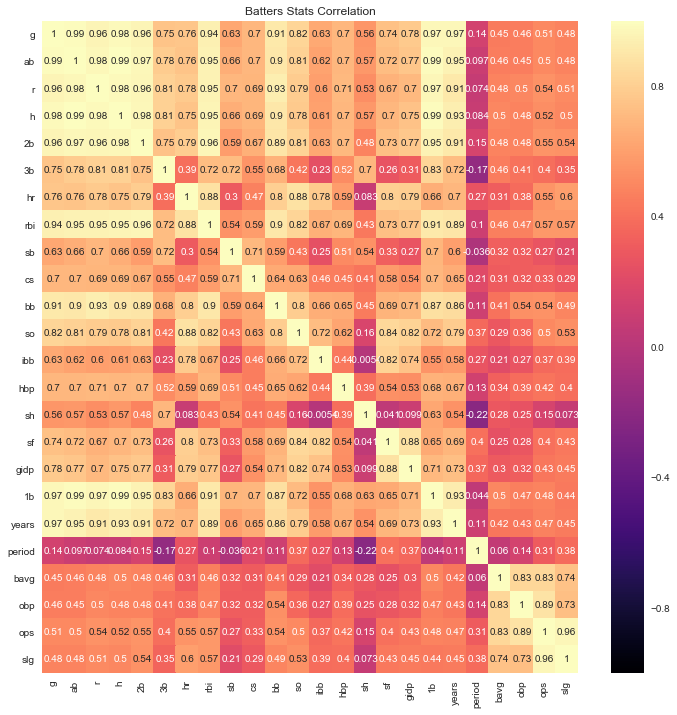

In [493]:
plt.figure(figsize=(12,12))
sns.heatmap(batters_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Batters Stats Correlation')

### PCA for batting stats

In [500]:
batters_pca = PCA(n_components=24)
batters_pca.fit(batters_ss.values)

PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Explained variance

In [501]:
for each in batters_pca.components_:
    for each in list(zip(batters_ss.columns, each)):
        print(each)
    print()

('g', 0.25098840103445735)
('ab', 0.25154228143150237)
('r', 0.2503940594257524)
('h', 0.251613375665903)
('2b', 0.2500209622210419)
('3b', 0.19003701213982976)
('hr', 0.2122743966561682)
('rbi', 0.24727650579050597)
('sb', 0.16532663821606242)
('cs', 0.18493727486312528)
('bb', 0.23897857391870037)
('so', 0.22007026817521466)
('ibb', 0.17554508766616667)
('hbp', 0.18823255418325072)
('sh', 0.12330027593435769)
('sf', 0.19830742556136363)
('gidp', 0.20430891229618392)
('1b', 0.24478472344846583)
('years', 0.2392549442276042)
('period', 0.05024827287777573)
('bavg', 0.14121354961143315)
('obp', 0.1468226970812975)
('ops', 0.16469855826058916)
('slg', 0.15807641903837163)

('g', 0.0715484923384055)
('ab', 0.09351812890227623)
('r', 0.09718112775879105)
('h', 0.10007836091963505)
('2b', 0.03358115244412653)
('3b', 0.3291957863000787)
('hr', -0.22595534033259967)
('rbi', 0.0013905385135400926)
('sb', 0.28823108418985155)
('cs', 0.08862101923493305)
('bb', 0.021534633345453823)
('so', -0.18

In [502]:
batters_pca.explained_variance_

array([1.50466650e+01, 2.66395227e+00, 2.33767125e+00, 9.01487551e-01,
       5.92024252e-01, 5.04298489e-01, 4.08581370e-01, 3.05196228e-01,
       2.64500002e-01, 2.30748797e-01, 1.57732152e-01, 1.31756185e-01,
       1.12046266e-01, 9.61268294e-02, 8.25902567e-02, 5.99303023e-02,
       5.12867961e-02, 2.79884946e-02, 1.37220950e-02, 9.07745915e-03,
       4.25230113e-03, 2.02982332e-03, 1.67946674e-05, 2.30469205e-31])

In [503]:
batters_pca.explained_variance_ratio_

array([6.26848233e-01, 1.10980990e-01, 9.73880318e-02, 3.75562211e-02,
       2.46638944e-02, 2.10092148e-02, 1.70216131e-02, 1.27145594e-02,
       1.10191434e-02, 9.61305882e-03, 6.57116516e-03, 5.48899917e-03,
       4.66787847e-03, 4.00467034e-03, 3.44073298e-03, 2.49671300e-03,
       2.13662214e-03, 1.16600844e-03, 5.71666281e-04, 3.78169463e-04,
       1.77152043e-04, 8.45630019e-05, 6.99670496e-07, 9.60141095e-33])

### Transform batting team year stats into PCA space

In [504]:
batters_pca_transformed = batters_pca.transform(batters_ss)

In [505]:
batters_pca_transformed = pd.DataFrame(batters_pca_transformed,
                                       columns=batters_ss.columns)

batters_pca_transformed

g        ab         r         h        2b        3b        hr  \
0     20.678906 -4.605797 -4.723615 -4.266202  4.121226 -0.708843  1.575004   
1     -2.187905 -0.203272 -0.599317  0.187197  0.018729 -0.229150  0.126401   
2      0.503444  2.710730  0.686323 -0.447704 -0.379403  0.556855 -0.352519   
3     -0.057749  1.157608  1.829695 -1.012571  0.573152  0.953515  0.224006   
4     -3.300952  1.240388 -1.746955 -0.630886  0.028804  0.346272  0.084120   
5     -1.745720 -1.585463  1.835712  0.653079 -0.172297 -0.165795  0.324350   
6      0.429897 -1.040639  0.406619  0.498234 -0.690169 -0.120465  0.592726   
7     -2.970677 -0.735249 -0.720019  1.121413 -0.681219 -0.020285  0.615599   
8     -1.986102 -0.650939  0.486954  0.800133 -0.276634 -0.131340 -0.007415   
9     -2.054173 -1.359526  2.903549 -0.230759  0.563522  0.148406 -0.034695   
10    -2.344328 -0.207039 -1.303708  0.455041 -0.348411 -0.132337  0.158159   
11     0.026179 -0.611651  2.229899 -0.170743  0.584650 -0.051447 -0.213212   
12    14.317444 -1.580629 -2.238760  1.831518  3.501870  0.741185  1.243799   
13     2.443521 -3.137977  2.093479 -0.079380 -1.051092  1.080924 -0.242772   
14    -2.068421 -1.276686  0.425132  0.954644 -0.575545 -0.317634  0.304916   
15    -2.504905  0.510446  0.777246 -0.685557  0.504671  0.142321 -0.232651   
16    -0.160514 -0.903712 -0.162361  0.903916 -0.497841 -0.369420  0.653666   
17    -2.518381  0.357918  1.021161 -0.615900  0.822859  0.246487 -0.795829   
18     2.217418 -0.372720 -1.537979 -0.069809  0.006743 -1.169726 -0.940499   
19    -2.969554 -0.692357 -0.381448  1.058682 -0.597033 -0.030182  0.193194   
20    -2.862392  0.090053  0.635322 -0.757358  0.698260  0.081284 -0.170090   
21    -3.450607  1.219326 -2.069560 -0.645416  0.154397  0.087571  0.195375   
22     2.789230  1.458790  0.599521  0.028199 -0.312508 -0.884406 -0.150516   
23    -0.123348 -0.051334  0.941712 -0.593971 -0.396151 -0.122083 -0.005488   
24    -3.559475 -0.403401 -1.643775  1.039354 -0.855298 -0.039241  0.629013   
25    -0.560211 -1.167330  0.933008  0.214499  0.075241 -0.598205 -0.277676   
26    -2.834680 -0.018507  0.202475 -0.132302  0.340302  0.063410 -0.212730   
27    -2.050541 -1.992713  2.489838  0.977495 -0.333300 -0.088613  0.446550   
28     0.078176 -2.183281  1.075348  0.484902 -0.597801 -0.307895  0.838305   
29    -3.170639 -0.164258 -0.956162  0.461741 -0.347753  0.020273  0.210060   
...         ...       ...       ...       ...       ...       ...       ...   
6491  -2.902120 -0.245227  0.907357 -0.439498  0.683672  0.162629 -0.327078   
6492  -3.575536  0.700177 -1.036226 -0.654331  0.480785  0.345229 -0.148820   
6493  -2.330161 -0.671868  2.359548 -0.207470  0.858181 -0.005010 -0.975426   
6494  -2.076558 -1.933572  2.549996  0.677076 -0.194902  0.046653  0.475152   
6495  -2.532646 -0.651854  1.742821 -0.170833  0.576223 -0.039646 -0.351750   
6496   2.382374  0.689287  1.267750 -0.265740 -0.367369 -0.254194 -0.065031   
6497  -1.585063 -1.153502  0.857647 -0.387517  0.160722  0.268356  0.443362   
6498   2.860632 -1.495566 -0.407622  0.097038 -0.677161 -0.393000 -0.522323   
6499  -2.316567 -0.693153  0.911118  0.485921  0.193051 -0.257543 -0.272381   
6500  -0.495661  2.640796 -0.128284 -0.095316  0.176020  0.258174 -0.401914   
6501   9.704350 -2.487957 -2.735167 -0.729804 -0.182987 -0.940277 -0.397425   
6502   3.915092 -1.640316  0.314790 -1.659167 -0.579963  0.010764  1.206741   
6503  -4.092840  1.233927 -2.248513 -0.949696  0.574835  0.292937  0.107107   
6504  -2.407691  0.477393 -0.421386 -0.211693 -0.000954 -0.453491 -0.345611   
6505  -2.392743 -1.309163  0.664845  1.039909 -0.499161  0.060627  0.477537   
6506   3.312223  2.639821  1.163819 -1.231084 -1.211463  2.008090 -0.292594   
6507   1.734994 -0.250714 -1.281562 -0.220288 -0.030381 -0.614747  0.174503   
6508  -3.557361  1.104810 -1.856663 -0.621270  0.180949  0.334574  0.322903   
6509   4.968043  4.318424  1.559095 -0.221499 -0.876074 -0.35125

### Visualize transformed PCA features
-There should be no correlation

In [506]:
# sns.pairplot(batters_pca_transformed)

## Now  KMeans Clustering

In [507]:
batters[batters.columns]

g     ab     r     h   2b   3b   hr     rbi     sb     cs  \
playerid                                                                  
aaronha01  3298  12364  2174  3771  624   98  755  2297.0  240.0   73.0   
aaronto01   311    752    81   173   36    6   10    78.0    9.0    7.0   
abbated01   788   2852   333   728   95   43   10   294.0  136.0    0.0   
abbeych01   452   1756   307   493   67   46   19   280.0   93.0    0.0   
abbotfr01   160    513    48   107   21    6    1    49.0   14.0    0.0   
abbotje01   169    459    64   127   29    2   15    70.0    5.0    4.0   
abbotku01   634   1903   253   488  102   23   56   218.0   19.0   11.0   
abercre01   111    255    39    54   12    2    5    24.0    6.0    5.0   
abernbr01   196    767    89   194   35    5    7    73.0   18.0    7.0   
aberscl01    47    140    24    39    6    3    4    20.0    0.0    0.0   
abnersh01   339    710    78   163   33    3    7    59.0    5.0    7.0   
abramca01   490   1488   239   413   61   18   32   132.0   11.0   18.0   
abreubo01  2402   8434  1451  2460  570   59  288  1357.0  400.0  128.0   
abreujo02   614   2414   330   726  144   12  124   410.0    6.0    3.0   
abreuto01   193    497    56   127   37    5    5    44.0    2.0    3.0   
abstebi01   137    512    51   133   20   10    1    70.0   16.0    0.0   
ackledu01   584   2012   249   488   91   16   42   201.0   31.0   12.0   
acostme01   121    332    43    85    7    4    0    32.0   12.0    4.0   
adairje01  1087   3783   364   969  158   18   56   350.0   29.0   27.0   
adamecr01   121    225    25    49    7    3    2    17.0    2.0    3.0   
adamsba01    83    217    22    59   11    3    0    23.0    0.0    0.0   
adamsbe01   205    566    28   116   15    3    2    36.0    9.0    0.0   
adamsbo03  1188   3900   569  1053  184   44   37   296.0   65.0   30.0   
adamsbu01   552   1935   274   518   92   11   48   240.0   12.0    0.0   
adamsda02    43    140    10    27    5    1    2    13.0    0.0    0.0   
adamsgl01   501   1387   138   390   69    4   29   196.0    4.0   10.0   
adamshe01    90    326    38    85    7    6    0    18.0    4.0    2.0   
adamsla01    85    109    19    30    4    1    5    20.0   10.0    0.0   
adamsma01   528   1586   194   431   95    6   72   255.0    4.0    4.0   
adamsri02   112    233    34    51    5    1    4    16.0    2.0    2.0   
...         ...    ...   ...   ...  ...  ...  ...     ...    ...    ...   
zachato01    51    111     7    29    6    1    0    11.0    0.0    1.0   
zacheel01    47    132     7    28    5    1    0    10.0    3.0    0.0   
zakfr01      87    160    33    48    3    1    0    11.0    6.0    0.0   
zambred01    67    116    17    30    7    0    6    18.0    2.0    1.0   
zardojo01    54    131    13    38    5    3    0    13.0    3.0    1.0   
zarilal01   988   3253   463   914  179   41   56   431.0   29.0   31.0   
zauchno01   226    780   100   183   18    2   42   130.0    3.0    0.0   
zaungr01   1130   3225   404   807  183    8   79   410.0   21.0   16.0   
zdebjo01    165    322    44    90    7    5    2    34.0    9.0    5.0   
zeidero01   677   2244   264   526   54   18    4   181.0  169.0    0.0   
zeileto01  2130   7491   979  1983  394   22  252  1102.0   53.0   51.0   
zernigu01  1230   4112   570  1091  159   22  237   772.0   15.0    7.0   
zettlge01    32    128    11    27    2    1    0    11.0    0.0    0.0   
zientbe01   269    885   103   224   29    5    2    47.0    5.0    0.0   
zimmebr01   101    299    41    72   15    2    8    39.0   18.0    1.0   
zimmech01  1147   4098   566  1117  201   71   24   580.0  132.0    0.0   
zimmedo01  1018   3155   339   752  127   21   90   347.0   43.0   23.0   
zimmeed01   122    417    31    77   10    7    3    36.0    9.0    0.0   
zimmehe01  1451   5295   695  1564  274  105   58   795.0  175.0   33.0   
zimmeje01   386    831    46   168   16    2    3    60.0    1.0    2.0   
zimmery01  1532   5882   877  1641  361

In [508]:
# Fitting batting team data on KMeans
# batting_team_year_cluster = batting_team_year[batting_team_year.columns]
km = KMeans(n_clusters=7,
           random_state=42)
km.fit(batters)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [509]:
centroids = pd.DataFrame(km.cluster_centers_, columns = batters.columns)

In [510]:
#looking at labels
km.labels_

array([6, 1, 3, ..., 4, 1, 1])

In [511]:
#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

1    2890
4    1269
3     863
0     607
5     489
2     283
6     120
dtype: int64

In [512]:
#saving labels to clustering data frame
batters['kmeans_clusters'] = km.labels_

In [513]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batters,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [514]:
show_cluster_results(6, 'kmeans_clusters')[batters.columns]

g     ab     r     h   2b   3b   hr     rbi     sb     cs  \
playerid                                                                  
cobbty01   3035  11434  2246  4189  724  295  117  1937.0  892.0  178.0   
gehrilo01  2133   7935  1878  2700  529  162  492  1980.0  102.0  101.0   
speaktr01  2782  10176  1882  3511  792  222  117  1528.0  432.0  129.0   
sislege01  2035   8218  1283  2800  424  164  102  1173.0  375.0  126.0   
ruthba01   2428   8224  2144  2829  495  135  704  2182.0  123.0  117.0   
lajoina01  2479   9585  1504  3241  657  163   83  1598.0  379.0   21.0   
keelewi01  2063   8424  1688  2879  235  143   31   788.0  484.0    0.0   
burkeje01  2067   8426  1720  2850  320  182   75   952.0  389.0    0.0   
gwynnto01  2440   9288  1383  3141  543   85  135  1138.0  319.0  125.0   
ansonca01  2277   9104  1722  3012  529  124   97  1880.0  247.0    0.0   
collied01  2758   9869  1815  3293  435  186   47  1291.0  744.0  173.0   
simmoal01  2156   8627  1498  2893  534  149  306  1804.0   88.0   64.0   
wanerpa01  2528   9417  1621  3145  605  191  113  1304.0  103.0    0.0   
boggswa01  2440   9180  1513  3010  578   61  118  1014.0   24.0   35.0   
carewro01  2469   9315  1424  3053  445  112   92  1015.0  353.0  187.0   

                ...           sf   gidp    1b  years  period   bavg    obp  \
playerid        ...                                                          
cobbty01        ...          0.0    0.0  3053     24   1.375  0.361  0.427   
gehrilo01       ...          0.0    0.0  1517     14   2.000  0.339  0.446   
speaktr01       ...          0.0    0.0  2380     21   1.429  0.338  0.418   
sislege01       ...          0.0    0.0  2110     15   1.667  0.338  0.377   
ruthba01        ...          0.0    0.0  1495     19   1.789  0.337  0.461   
lajoina01       ...          0.0    0.0  2338     21   0.762  0.337  0.378   
keelewi01       ...          0.0    0.0  2470     16   0.562  0.336  0.383   
burkeje01       ...          0.0    0.0  2273     16   0.312  0.335  0.412   
gwynnto01       ...         85.0  259.0  2378     20   5.400  0.335  0.385   
ansonca01       ...          0.0    0.0  2262     22   0.000  0.333  0.393   
collied01       ...          0.0    0.0  2625     20   1.400  0.332  0.424   
simmoal01       ...          0.0   16.0  1904     17   2.059  0.328  0.374   
wanerpa01       ...          0.0  125.0  2236     19   2.158  0.327  0.401   
boggswa01       ...         96.0  236.0  2253     18   5.333  0.326  0.411   
carewro01       ...         64.0  216.0  2404     19   4.474  0.326  0.391   

             ops    slg  kmeans_clusters  
playerid                                  
cobbty01   0.931  0.504                6  
gehrilo01  1.077  0.631                6  
speaktr01  0.910  0.492                6  
sislege01  0.841  0.464                6  
ruthba01   1.127  0.665                6  
lajoina01  0.845  0.467                6  
keelewi01  0.789  0.406                6  
burkeje01  0.855  0.443                6  
gwynnto01  0.840  0.455                6  
ansonca01  0.840  0.447                6  
collied01  0.851  0.427                6  
simmoal01  0.897  0.523                6  
wanerpa01  0.858  0.456                6  
boggswa01  0.850  0.439                6  
carewro01  0.818  0.427                6  

[15 rows x 25 columns]

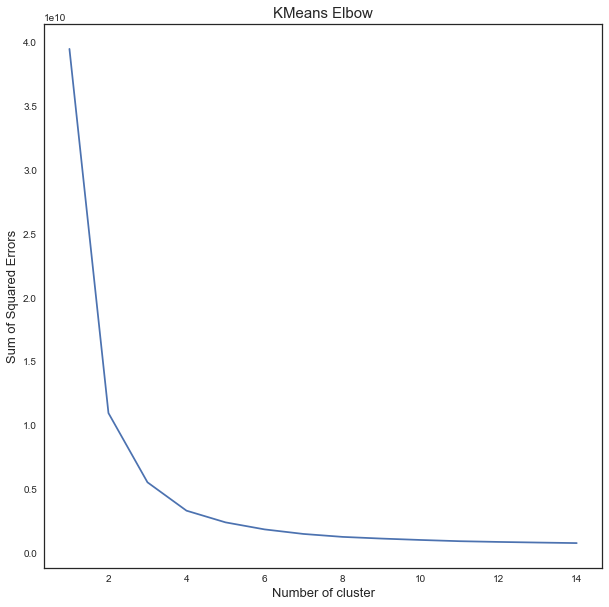

In [288]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(batters)
    batters["clusters"] = kmeans.labels_
    #print(batters["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('KMeans Elbow', fontsize=15)
plt.xlabel("Number of cluster", fontsize=13)
plt.ylabel("Sum of Squared Errors", fontsize=13)
plt.show()

In [289]:
ks = range(2,16)
sil = []

for n_cluster in range(2, 16):
    kmeans = KMeans(n_clusters=n_cluster).fit(batters)
    label = kmeans.labels_
    sil_coeff = silhouette_score(batters, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    sil.append(sil_coeff)

For n_clusters=2, The Silhouette Coefficient is 0.7000034007711311
For n_clusters=3, The Silhouette Coefficient is 0.6453113585611439
For n_clusters=4, The Silhouette Coefficient is 0.6184501637894161
For n_clusters=5, The Silhouette Coefficient is 0.5803924335508405
For n_clusters=6, The Silhouette Coefficient is 0.562107471746755
For n_clusters=7, The Silhouette Coefficient is 0.5444238728314316
For n_clusters=8, The Silhouette Coefficient is 0.5218098290628398
For n_clusters=9, The Silhouette Coefficient is 0.5046179493910616
For n_clusters=10, The Silhouette Coefficient is 0.5016971541496003
For n_clusters=11, The Silhouette Coefficient is 0.47431190618036984
For n_clusters=12, The Silhouette Coefficient is 0.45400146683759895
For n_clusters=13, The Silhouette Coefficient is 0.44239416930888303
For n_clusters=14, The Silhouette Coefficient is 0.4516353225667833
For n_clusters=15, The Silhouette Coefficient is 0.4408585165138371


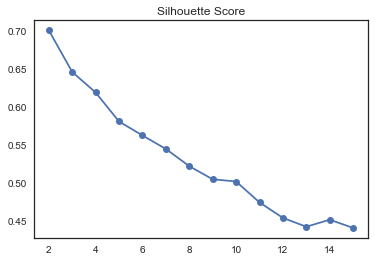

In [290]:
plt.plot(ks, sil, '-o')
plt.title('Silhouette Score');

In [518]:
# Call k-means to cluster the stats
kmeans = KMeans(n_clusters=7, random_state=42)
model = kmeans.fit(batting_team)
centroids = pd.DataFrame(model.cluster_centers_, columns = batting_year.columns)

In [519]:
batters.columns

Index(['g', 'ab', 'r', 'h', '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so',
       'ibb', 'hbp', 'sh', 'sf', 'gidp', '1b', 'years', 'period', 'bavg',
       'obp', 'ops', 'slg', 'kmeans_clusters'],
      dtype='object')

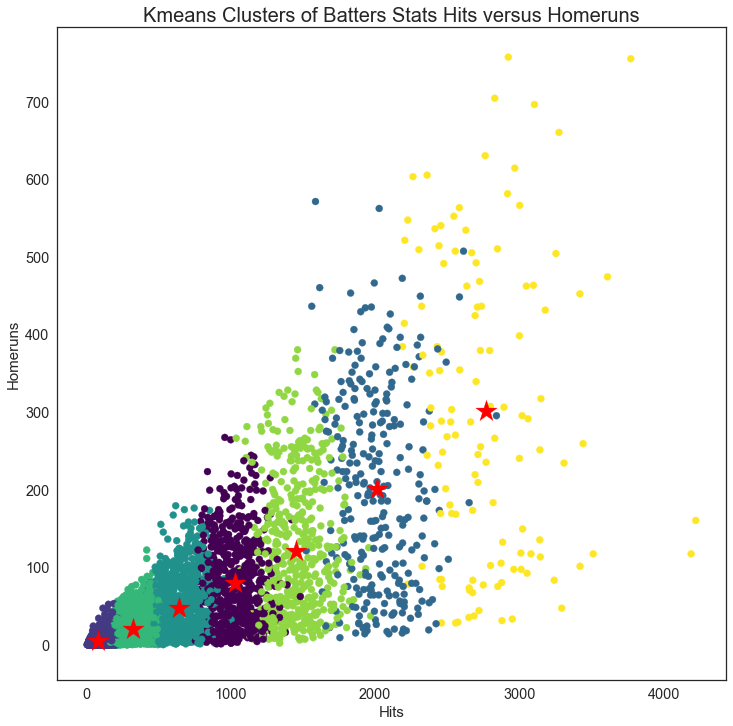

In [520]:
plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batters['h'], batters['hr'],
                c=batters['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Batters Stats Hits versus Homeruns', fontsize=20)
plt.xlabel('Hits', fontsize=15)
plt.ylabel('Homeruns', fontsize=15);

## HDBSCAN

In [521]:
hdb = HDBSCAN(min_cluster_size=6)
hdb.fit(batters)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=6, min_samples=None, p=None,
    prediction_data=False)

In [522]:
# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

-1     4225
 0        6
 1       25
 2       16
 3       13
 4        6
 5       14
 6        7
 7        6
 8       16
 9       20
 10      11
 11       6
 12      18
 13       7
 14       6
 15       8
 16       9
 17      16
 18       9
 19       9
 20       6
 21       6
 22       7
 23      12
 24    2037
dtype: int64

In [523]:
batters['hdb_clusters'] = hdb.labels_

In [524]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batters,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [525]:
show_cluster_results(2, 'hdb_clusters')

g    ab    r     h   2b  3b   hr    rbi    sb    cs  \
playerid                                                            
seguida01  1348  4525  642  1313  269  15  129  637.0  16.0  15.0   
scutama01  1311  4765  670  1330  265  20   74  497.0  53.0  21.0   
jonesja04  1260  4478  617  1255  253  18  164  623.0  82.0  44.0   
mcdougi01  1336  4676  697  1291  187  51  112  576.0  45.0  44.0   
francti01  1480  4708  609  1285  208  33  119  591.0  45.0  19.0   
johnsda02  1346  4611  540  1211  235  17  132  587.0  30.0  25.0   
knighra01  1291  4568  461  1246  253  26   81  570.0  13.0  24.0   
lopezhe01  1450  4644  623  1251  193  37  136  591.0  16.0  23.0   
northji01  1358  4619  597  1236  216  42  150  599.0  38.0  38.0   
jacobbr01  1296  4502  535  1218  204  24  120  544.0  16.0  25.0   
wiggity01  1315  4422  549  1161  243  14  169  591.0  42.0  22.0   
rosebjo01  1504  4692  499  1176  184  44  101  536.0  66.0  55.0   
bellda01   1376  4735  576  1211  258  18  123  581.0  19.0  20.0   
spencji01  1480  4690  523  1184  172  25  142  579.0  11.0  19.0   
drewst01   1222  4308  556  1085  251  63  122  507.0  41.0  19.0   

               ...        gidp   1b  years  period   bavg    obp    ops  \
playerid       ...                                                        
seguida01      ...       125.0  900     14   5.714  0.286  0.352  0.780   
scutama01      ...       114.0  971     11   6.818  0.282  0.342  0.735   
jonesja04      ...       113.0  820      9   6.222  0.281  0.329  0.782   
mcdougi01      ...        93.0  941     10   3.000  0.276  0.356  0.767   
francti01      ...        94.0  925     13   3.615  0.266  0.335  0.729   
johnsda02      ...       120.0  827     10   4.100  0.265  0.345  0.758   
knighra01      ...       163.0  886     10   5.000  0.265  0.313  0.692   
lopezhe01      ...       136.0  885     13   3.462  0.265  0.325  0.738   
northji01      ...       125.0  828     11   4.000  0.265  0.330  0.751   
jacobbr01      ...       137.0  870     10   5.000  0.264  0.326  0.715   
wiggity01      ...       127.0  735     13   6.615  0.264  0.326  0.769   
rosebjo01      ...        75.0  847     12   3.750  0.250  0.327  0.701   
bellda01       ...       120.0  812     13   6.154  0.249  0.310  0.690   
spencji01      ...       116.0  845     14   4.429  0.244  0.299  0.681   
drewst01       ...        46.0  649     13   7.000  0.240  0.310  0.718   

             slg  kmeans_clusters  hdb_clusters  
playerid                                         
seguida01  0.428                5             2  
scutama01  0.393                5             2  
jonesja04  0.453                0             2  
mcdougi01  0.411                5             2  
francti01  0.394                5             2  
johnsda02  0.413                5             2  
knighra01  0.379                0             2  
lopezhe01  0.414                5             2  
northji01  0.421                5             2  
jacobbr01  0.389                0             2  
wiggity01  0.443                0             2  
rosebjo01  0.373                5             2  
bellda01   0.380                5             2  
spencji01  0.382                5             2  
drewst01   0.409                0             2  

[15 rows x 26 columns]

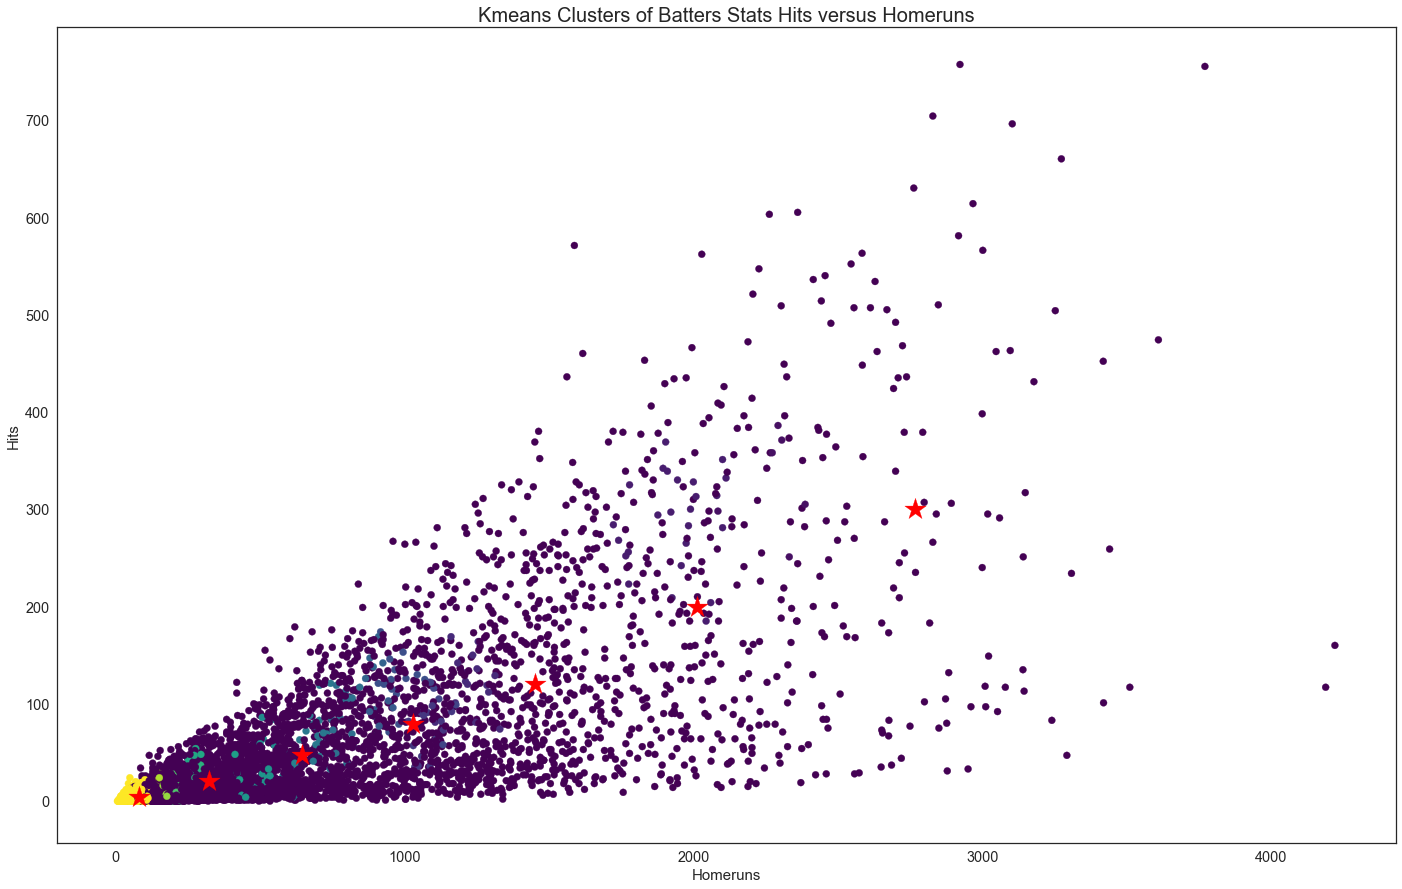

In [526]:

plt.figure(figsize=(24,15))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batters['h'], batters['hr'],
           c=batters['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Batters Stats Hits versus Homeruns', fontsize=20)
plt.xlabel('Homeruns', fontsize=15)
plt.ylabel('Hits', fontsize=15)

plt.show()

# Model the Data

In [527]:
# Define my x and y
# we will test one cluster at a time
features = [each for each in batters.columns if each not in ['kmeans_clusters','hdb_clusters']]
X = batters[features]
y = batters['kmeans_clusters']

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [529]:
X_train.head()

g    ab     r     h   2b   3b   hr     rbi     sb    cs  ...    \
playerid                                                               ...     
desauge01   641  1878   196   444   70   11    3   180.0   12.0   6.0  ...     
stevech01   207   719    87   182   29    8    4    53.0    6.0   8.0  ...     
brownsa01   141   439    29    88   12    1    0    34.0    4.0   0.0  ...     
manushe01  1966  7578  1276  2508  487  158  110  1172.0  113.0  58.0  ...     
kendafr01   824  2476   163   584   85   11   31   237.0    5.0   5.0  ...     

              sh    sf  gidp    1b  years  period   bavg    obp    ops    slg  
playerid                                                                       
desauge01   56.0   0.0  20.0   360      9   2.333  0.229  0.303  0.583  0.280  
stevech01   22.0   0.0  14.0   141      2   3.000  0.254  0.339  0.673  0.334  
brownsa01   15.0   0.0   0.0    75      2   1.000  0.200  0.256  0.488  0.231  
manushe01  186.0   0.0   7.0  1753     16   2.000  0.328  0.376  0.851  0.476  
kendafr01   27.0  23.0  81.0   457      8   4.250  0.220  0.274  0.567  0.293  

[5 rows x 24 columns]

In [530]:
y_train.head()

playerid
desauge01    4
stevech01    1
brownsa01    1
manushe01    2
kendafr01    3
Name: kmeans_clusters, dtype: int32

In [531]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100


building tree 5 of 100building tree 6 of 100

building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100building tree 39 of 100

building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.1s


building tree 70 of 100

building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100building tree 97 of 100

building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


0.9897750511247444

In [532]:
gs_rf.best_params_

{'rf__criterion': 'entropy',
 'rf__n_estimators': 100,
 'rf__n_jobs': -1,
 'rf__random_state': 42,
 'rf__verbose': 2}

In [533]:
gs_rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9914163090128756

In [534]:
y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[142,   0,   0,   1,   0,   0,   0],
       [  0, 750,   0,   0,   0,   0,   0],
       [  0,   0,  68,   0,   0,   0,   0],
       [  0,   0,   0, 203,   1,   0,   0],
       [  0,   4,   0,   4, 319,   0,   0],
       [  1,   0,   0,   0,   0, 105,   0],
       [  0,   0,   3,   0,   0,   0,  30]], dtype=int64)

## Pitching year

## PCA first

## PCA first

In [291]:
pitchers.columns

Index(['w', 'l', 'g', 'gs', 'cg', 'sho', 'sv', 'ipouts', 'h', 'er', 'hr', 'bb',
       'so', 'baopp', 'ibb', 'wp', 'hbp', 'bk', 'bfp', 'gf', 'r', 'sh', 'sf',
       'gidp', 'est_pc', 'years', 'period', 'era', 'whip'],
      dtype='object')

### Scale data for use with PCA

We already did this above

### Find Z scores

In [292]:
pitchers_ss

w         l         g        gs        cg       sho        sv  \
0    -0.399859 -0.376091  0.826636 -0.639136 -0.424885 -0.436902  1.523900   
1     0.492833  0.606315  1.443876  0.098349 -0.068217 -0.043060  1.818152   
2    -0.541878 -0.155050  1.075797 -0.582406 -0.424885 -0.436902 -0.268363   
3    -0.440436 -0.179610 -0.685319 -0.260938  0.189376 -0.436902 -0.295113   
4     0.330525  1.023837  0.203733  1.006024  0.209191  0.088221 -0.321863   
5     0.858025  1.736081  0.407592  1.592230  0.169561  0.219502 -0.321863   
6    -0.643320 -0.474332 -0.702308 -0.459492 -0.424885 -0.436902 -0.321863   
7     0.005910 -0.474332 -0.396519 -0.034020 -0.405070 -0.436902 -0.321863   
8    -0.257840 -0.228730 -0.085068 -0.364943 -0.305996 -0.436902  0.052639   
9     0.533410  0.802796  2.712333 -0.355488 -0.325811 -0.174341  3.583664   
10   -0.683897 -0.793614 -0.894841 -0.629681 -0.424885 -0.436902 -0.295113   
11   -0.704185 -0.793614 -0.832551 -0.639136 -0.424885 -0.436902 -0.321863   
12   -0.501301 -0.351531  0.469882 -0.639136 -0.424885 -0.436902  0.694644   
13   -0.257840 -0.498892 -0.034103 -0.591861 -0.424885 -0.436902  0.427142   
14   -0.460724 -0.253291 -0.453147 -0.166389 -0.424885 -0.436902 -0.295113   
15   -0.156397  0.115112  1.019169 -0.317668 -0.424885 -0.436902  1.095897   
16   -0.683897 -0.818174 -0.826888 -0.639136 -0.424885 -0.436902 -0.321863   
17   -0.075243  0.360713  1.585445 -0.336578 -0.424885 -0.436902  0.480642   
18   -0.318705 -0.498892 -0.113381 -0.421672 -0.325811 -0.305622 -0.107862   
19   -0.440436 -0.597133 -0.407845 -0.639136 -0.424885 -0.436902  0.373642   
20   -0.643320 -0.670813 -0.719296 -0.620226 -0.424885 -0.436902 -0.321863   
21   -0.501301 -0.621693 -0.696645 -0.525677 -0.305996 -0.305622 -0.214863   
22   -0.440436 -0.498892  0.339639 -0.639136 -0.424885 -0.436902 -0.081112   
23   -0.521589 -0.670813 -0.334229 -0.639136 -0.424885 -0.436902 -0.268363   
24    0.127641 -0.032249  0.713381 -0.572951 -0.385255 -0.436902  0.988896   
25   -0.663608 -0.818174 -0.713633 -0.639136 -0.424885 -0.436902 -0.295113   
26    3.150620  2.497446  1.653398  2.622818  3.557907  5.339455  0.079390   
27   -0.602743 -0.744494 -0.809900 -0.582406 -0.424885 -0.436902 -0.321863   
28   -0.683897 -0.597133 -0.832551 -0.525677 -0.365441 -0.436902 -0.321863   
29   -0.278128 -0.351531  1.245680 -0.639136 -0.424885 -0.436902 -0.241613   
...        ...       ...       ...       ...       ...       ...       ...   
5531  0.411679  1.515040  0.905914  0.902019 -0.028587  0.219502  0.346891   
5532 -0.460724 -0.769054 -0.673994 -0.620226 -0.424885 -0.436902 -0.161362   
5533 -0.663608 -0.744494 -0.894841 -0.601316 -0.385255 -0.305622 -0.295113   
5534 -0.481012 -0.474332 -0.611704 -0.412217 -0.226736 -0.043060 -0.241613   
5535 -0.582455 -0.498892 -0.583390 -0.450037 -0.405070 -0.305622 -0.295113   
5536  2.846293  3.504412  1.823280  2.953741  3.042720  2.582557  0.213140   
5537  0.533410  0.630875  0.515184  0.637281  0.070487  0.482063 -0.241613   
5538 -0.683897 -0.818174 -0.583390 -0.639136 -0.424885 -0.436902 -0.321863   
5539  1.486967  1.760641  0.639765  1.819148  1.120676  2.057434 -0.295113   
5540 -0.196974  0.336153 -0.277601  0.117259  0.149747  0.088221 -0.295113   
5541  1.953601  1.367679  0.990856  2.206801 -0.226736  0.219502 -0.321863   
5542  0.147929  0.139672 -0.039766  0.192899 -0.405070 -0.436902 -0.241613   
5543 -0.683897 -0.670813 -0.883516 -0.591861 -0.365441 -0.436902 -0.295113   
5544 -0.440436 -0.474332 -0.141695 -0.620226 -0.424885 -0.436902  0.293391   
5545 -0.562166 -0.670813 -0.555076 -0.610771 -0.424885 -0.436902 -0.054361   
5546 -0.643320 -0.744494 -0.702308 -0.639136 -0.424885 -0.436902 -0.321863   
5547 -0.704185 -0.793614 -0.707970 -0.639136 -0.424885 -0.436902 -0.295113   
5548 -0.501301 -0.695373 -0.645680 -0.412217 -0.405070 -0.305622 -0.214863   
5549 -0.582455 -0.793614 -0.356880 -0.620226 -0.424885 -0.436902 -0.321863   
5550 -0.623032 -0.326971 -0.821226 

### Visualize correlation

In [293]:
# g = sns.PairGrid(pitchers_year_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

Text(0.5,1,'Pitchers Stats by Team Correlation')

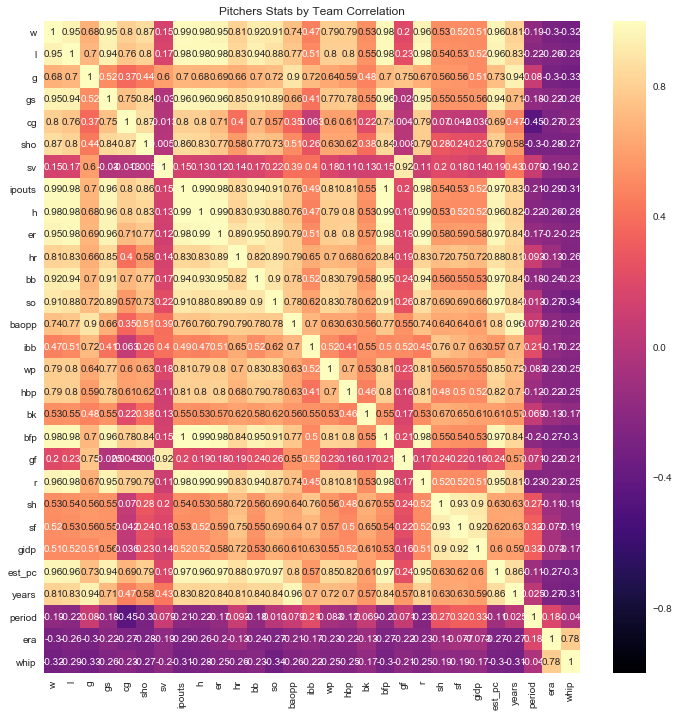

In [294]:
plt.figure(figsize=(12,12))
sns.heatmap(pitchers_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Pitchers Stats by Team Correlation')

### PCA for Pitchers stats

In [295]:
pitchers_pca = PCA(n_components=29)
pitchers_pca.fit(pitchers_ss.values)

PCA(copy=True, iterated_power='auto', n_components=29, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Explained variance

In [296]:
for each in pitchers_pca.components_:
    for each in list(zip(pitchers_ss.columns, each)):
        print(each)
    print()

('w', 0.2253447134131113)
('l', 0.22645563478071462)
('g', 0.18564824539173014)
('gs', 0.21784437379593313)
('cg', 0.15674919426051495)
('sho', 0.1809562593637534)
('sv', 0.05669395849173413)
('ipouts', 0.22892519516789112)
('h', 0.2264085567327627)
('er', 0.22813479197420927)
('hr', 0.21001174941871767)
('bb', 0.22355918868828617)
('so', 0.22384204593442156)
('baopp', 0.1994394702947433)
('ibb', 0.14956916499866466)
('wp', 0.19887485079472889)
('hbp', 0.192633808820846)
('bk', 0.15088503690902447)
('bfp', 0.22922516939762166)
('gf', 0.07318820390199467)
('r', 0.2244663264416499)
('sh', 0.16061940764276503)
('sf', 0.15909300950213728)
('gidp', 0.15390370452583102)
('est_pc', 0.23214772362259356)
('years', 0.2132731006798279)
('period', -0.020477540963559825)
('era', -0.06941395905760714)
('whip', -0.07946839992871879)

('w', 0.11674149795429604)
('l', 0.0988562230105449)
('g', -0.19970626358885474)
('gs', 0.15030090623803108)
('cg', 0.33989524702446644)
('sho', 0.24788510937693892)
('s

In [297]:
pitchers_pca.explained_variance_

array([1.80406899e+01, 3.58570681e+00, 2.31752972e+00, 1.45696988e+00,
       6.98816512e-01, 4.64237849e-01, 4.44534019e-01, 3.73192616e-01,
       3.31344103e-01, 2.69709892e-01, 2.43348978e-01, 1.86565561e-01,
       1.58822777e-01, 8.34910401e-02, 7.93881693e-02, 6.91098659e-02,
       5.14487945e-02, 3.97415657e-02, 3.04777982e-02, 2.66245819e-02,
       1.96947113e-02, 1.24646363e-02, 9.70318620e-03, 4.94689812e-03,
       3.10828985e-03, 1.70315401e-03, 1.36288487e-03, 4.81635638e-04,
       7.34907877e-30])

In [298]:
pitchers_pca.explained_variance_ratio_

array([6.21980888e-01, 1.23622828e-01, 7.99004475e-02, 5.02313063e-02,
       2.40927879e-02, 1.60053230e-02, 1.53260028e-02, 1.28663968e-02,
       1.14236041e-02, 9.29866869e-03, 8.38983510e-03, 6.43213836e-03,
       5.47566265e-03, 2.87848367e-03, 2.73703081e-03, 2.38267029e-03,
       1.77377734e-03, 1.37015239e-03, 1.05076957e-03, 9.17923936e-04,
       6.79005853e-04, 4.29737753e-04, 3.34532460e-04, 1.70552019e-04,
       1.07163135e-04, 5.87188878e-05, 4.69875790e-05, 1.66051389e-05,
       2.53370939e-31])

### Transform batters stats into PCA space

In [299]:
pitchers_pca_transformed = pitchers_pca.transform(pitchers_ss)

In [300]:
pitchers_pca_transformed = pd.DataFrame(pitchers_pca_transformed,
                                       columns=pitchers_ss.columns)

pitchers_pca_transformed

w         l         g        gs        cg       sho        sv  \
0     -0.529262 -2.256328  1.293634  0.549571 -0.840962  0.132480  0.293457   
1      3.543951 -3.293556  1.438344  0.497232  0.465190 -0.395992 -0.237257   
2     -0.627344 -1.606527  0.651180 -0.148799 -1.080217  0.441553 -0.928497   
3     -1.920721  1.764908  0.259341  0.256155  1.473840 -0.932497  0.075190   
4      3.190837 -0.782713 -1.670427 -0.330197  0.049954 -0.992512 -0.859255   
5      6.339656 -1.525444 -3.196364 -0.357886  0.946243 -0.192105  0.310413   
6     -2.514151 -0.015870 -0.675801 -0.226529 -0.127540  0.278774  0.270179   
7     -0.596483 -0.400045 -0.667683 -0.773254 -0.503937 -0.484198  0.042904   
8     -1.445965  0.147263  0.821298  0.481285  0.258925 -0.190660 -0.661846   
9      4.202169 -3.740794  5.041880  2.364286  0.475122 -0.001064 -0.139271   
10    -3.253796  0.588803  0.873171 -2.175433  0.379261 -0.193152 -0.166102   
11    -3.512910 -0.149568 -1.075098  0.559920 -0.945233  0.623408  0.494104   
12    -0.995354 -1.871689  0.806480  0.508173 -0.821016  0.465154 -0.325910   
13    -1.405398 -1.040422  0.687838 -1.390841 -0.843710  0.249611  0.642063   
14    -1.437280 -0.509773 -1.391284  0.664616 -0.524270  0.226387 -0.024167   
15     1.301700 -2.838085  0.493124  0.887396 -0.007420 -0.116368 -0.182862   
16    -3.352158 -0.100696  0.032167 -1.151976 -0.710893  0.256631  0.226070   
17     2.780963 -2.920588  0.334270  0.449032  0.129567 -1.037845 -0.793545   
18    -1.322084  0.257096  0.682233 -0.315115  0.266093 -0.288610 -0.661433   
19    -2.050638 -0.451050  1.400690 -1.800783  0.437644 -0.278449  0.092445   
20    -2.996535  0.135199 -0.325662 -0.041772  0.465379  0.016466  0.140928   
21    -2.751845  0.845465  0.304838  0.125729  0.868616 -0.292489 -0.244045   
22    -1.390943 -1.148775  0.500891 -0.369691 -1.023607  0.068621 -0.259839   
23    -2.516199 -0.511130 -0.664702  1.020166 -0.461264  0.361886 -0.178468   
24    -0.641536 -0.433909  2.675551  0.496257  0.349941 -0.453166 -0.026817   
25    -3.471147 -0.253020 -1.351896  1.752449 -1.104758  0.521009  0.351694   
26     8.717687  5.094000  2.836126  0.301071 -1.465927  1.174946 -0.852115   
27    -3.033743  0.047084  0.049924 -1.572392 -0.459995  0.234884  0.218812   
28    -3.103580  1.021063  0.161878 -0.138762  1.141331 -0.480689 -0.155758   
29    -0.586848 -1.308500  1.571955 -2.180215 -1.264452  0.194178 -1.120298   
...         ...       ...       ...       ...       ...       ...       ...   
5531   4.913032 -1.479516 -1.387004  0.879213  0.426067 -0.431554  0.362733   
5532  -2.938870  0.507922  1.001353 -1.716562  0.709054 -0.123953 -0.001637   
5533  -3.277732  0.539706 -0.223206 -0.281409  0.629371  0.466520  0.142850   
5534  -2.106071  1.155219  1.256651 -1.639290  1.265923 -0.343402 -0.271416   
5535  -2.243224  0.102316  0.199305 -0.681208  0.280819 -0.018099 -0.208683   
5536  10.304003  4.025024  1.580950  1.748523 -0.017901  2.523665 -1.406709   
5537   3.335389 -1.487569 -1.070036 -0.911540  1.123858  0.778310 -0.436707   
5538  -3.185826 -0.359196 -1.025426  0.856596 -0.962510  0.325518  0.397167   
5539   7.031124 -0.939520 -2.587183 -1.254395  0.259358 -1.339460 -0.165719   
5540  -0.599460  1.601316  0.039766  1.224210  0.545383 -0.386966 -0.421788   
5541   8.933188 -1.722560 -2.964850 -1.175353 -0.369895 -2.206020  0.660407   
5542   1.453355 -0.825285 -1.357498 -0.375624 -0.119485 -0.734498  0.985387   
5543  -3.113813  1.009855  1.075728 -1.796528  1.388281 -0.615633 -0.343773   
5544  -1.810944 -1.029775  0.210975 -0.131788  0.603619  0.022397 -0.090238   
5545  -2.688520  0.173984  0.638367 -0.941539  0.038962 -0.108739  0.011380   
5546  -3.205629 -0.086673  0.098341 -1.382500 -0.835230  0.274963  0.257367   
5547  -3.305876 -0.248793 -0.862414  0.643673 -0.970976  0.389290  0.275435   
5548  -2.531277  0.262072 -0.320568  0.159064  0.337980 -0.283533  0.020583   
5549  -2.444917 -0.580721 -0.016541 -0.852296 -0.483547 -0.11240

### Visualize transformed PCA features
-There should be no correlation

In [301]:
# sns.pairplot(pitchers_pca_transformed)

## Now  KMeans Clustering

In [306]:
pitching_year['year'] = pitching_year.index

In [308]:
# Fitting pitching year data on KMeans
km = KMeans(n_clusters=7,
           random_state=42)
km.fit(pitching_year)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [309]:
centroids = pd.DataFrame(km.cluster_centers_, columns = pitching_year.columns)

In [310]:
#looking at labels
km.labels_

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 6, 6,
       1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4,
       4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [311]:
#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

1    37
0    24
3    23
6    19
5    17
2    13
4     9
dtype: int64

In [312]:
#saving labels to clustering data frame
pitching_year['kmeans_clusters'] = km.labels_

In [313]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=pitching_year,
                        by='era',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [314]:
show_cluster_results(6, 'kmeans_clusters')[pitching_year.columns]

w     l     g    gs    cg  sho   sv  ipouts      h    er  \
year                                                                
1950  1172  1128  4614  2318   957  133  281   60614  20578  9571   
1938  1133  1104  4162  2265  1026  121  198   60005  21357  9348   
1937  1154  1124  4177  2308  1049  130  202   60163  21612  9318   
1948  1201  1166  5110  2395   889  141  306   62953  21109  9389   
1940  1163  1152  4413  2315  1044  132  229   61474  21233  9182   
1949  1196  1153  4841  2371   951  167  233   62498  20776  9271   
1953  1193  1157  5107  2354   841  152  337   62361  21000  9316   
1951  1184  1144  4850  2323   913  160  268   62516  20590  9060   
1955  1184  1138  5345  2317   730  152  341   61509  19885  8832   
1954  1191  1158  5066  2362   824  161  338   62495  20443  8832   
1941  1156  1147  4313  2322  1025  150  206   61456  20759  8784   
1956  1189  1138  5430  2323   740  125  359   62328  20155  8902   
1947  1178  1136  4827  2319   925  172  283   61913  20373  8685   
1959  1189  1130  5281  2324   725  155  367   61484  19752  8600   
1958  1158  1117  5358  2278   710  128  382   60680  19619  8464   

           ...             r   sh   sf  gidp    est_pc  period    era   whip  \
year       ...                                                                 
1950       ...         10800  0.0  0.0   0.0  248841.0       3  4.610  0.170   
1938       ...         10855  0.0  0.0   0.0  229575.0       2  4.451  0.168   
1937       ...         10842  0.0  0.0   0.0  231048.0       2  4.399  0.166   
1948       ...         10590  0.0  0.0   0.0  250548.0       3  4.314  0.166   
1940       ...         10557  0.0  0.0   0.0  230712.0       2  4.295  0.161   
1949       ...         10532  0.0  0.0   0.0  251289.0       3  4.259  0.166   
1953       ...         10519  0.0  0.0   0.0  246102.0       3  4.253  0.161   
1951       ...         10274  0.0  0.0   0.0  242787.0       3  4.109  0.160   
1955       ...         10004  0.0  0.0   0.0  250680.0       3  4.092  0.157   
1954       ...          9981  0.0  0.0   0.0  248151.0       3  4.059  0.158   
1941       ...         10199  0.0  0.0   0.0  233907.0       2  4.045  0.161   
1956       ...         10115  0.0  0.0   0.0  258444.0       3  4.033  0.158   
1947       ...          9888  0.0  0.0   0.0  241083.0       3  4.031  0.160   
1959       ...          9737  0.0  0.0   0.0  254346.0       3  3.997  0.154   
1958       ...          9467  0.0  0.0   0.0  249126.0       3  3.969  0.153   

      year  kmeans_clusters  
year                         
1950  1950                6  
1938  1938                6  
1937  1937                6  
1948  1948                6  
1940  1940                6  
1949  1949                6  
1953  1953                6  
1951  1951                6  
1955  1955                6  
1954  1954                6  
1941  1941                6  
1956  1956                6  
1947  1947                6  
1959  1959                6  
1958  1958                6  

[15 rows x 30 columns]

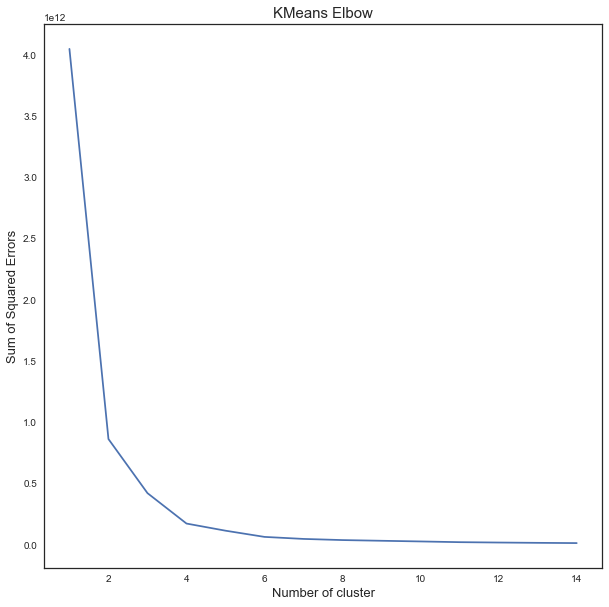

In [315]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(pitching_year)
    pitching_year['kmeans_clusters'] = kmeans.labels_
    #print(batters["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('KMeans Elbow', fontsize=15)
plt.xlabel("Number of cluster", fontsize=13)
plt.ylabel("Sum of Squared Errors", fontsize=13)
plt.show()

In [316]:
ks = range(2,16)
sil = []

for n_cluster in range(2, 16):
    kmeans = KMeans(n_clusters=n_cluster).fit(pitching_year)
    label = kmeans.labels_
    sil_coeff = silhouette_score(pitching_year, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    sil.append(sil_coeff)

For n_clusters=2, The Silhouette Coefficient is 0.700673238866029
For n_clusters=3, The Silhouette Coefficient is 0.6538000201066002
For n_clusters=4, The Silhouette Coefficient is 0.6980161664638962
For n_clusters=5, The Silhouette Coefficient is 0.708693994471374
For n_clusters=6, The Silhouette Coefficient is 0.6973854381361764
For n_clusters=7, The Silhouette Coefficient is 0.6395322092905547
For n_clusters=8, The Silhouette Coefficient is 0.6347931044471159
For n_clusters=9, The Silhouette Coefficient is 0.5856316955614111
For n_clusters=10, The Silhouette Coefficient is 0.5524740423179817
For n_clusters=11, The Silhouette Coefficient is 0.5764013716452836
For n_clusters=12, The Silhouette Coefficient is 0.543537460785607
For n_clusters=13, The Silhouette Coefficient is 0.5693331814094278
For n_clusters=14, The Silhouette Coefficient is 0.5226331686567388
For n_clusters=15, The Silhouette Coefficient is 0.5382316843311324


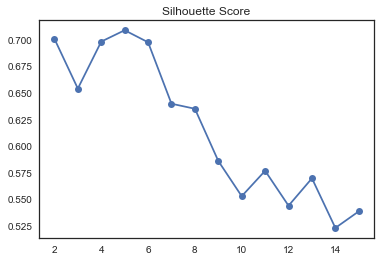

In [317]:
plt.plot(ks, sil, '-o')
plt.title('Silhouette Score');

In [318]:
pitching_year['year'] = pitching_year.index

In [319]:
# Call k-means to cluster the stats
kmeans = KMeans(n_clusters=7, random_state=42)
model = kmeans.fit(pitching_year)
centroids = pd.DataFrame(model.cluster_centers_, columns = pitching_year.columns)

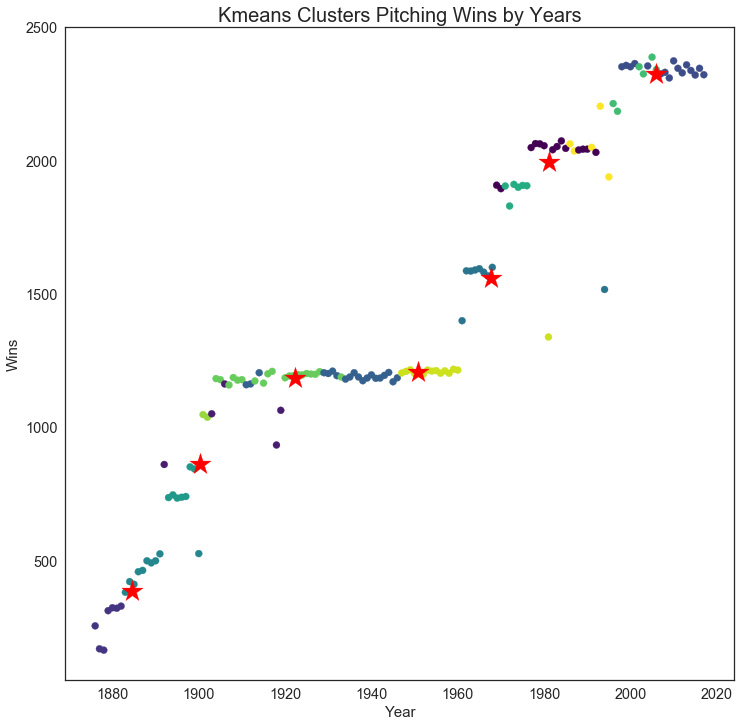

In [585]:
plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(pitching_year.index, pitching_year['w'],
                c=pitching_year['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['year'], centroids['w'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters Pitching Wins by Years', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Wins', fontsize=15);

## HDBSCAN

In [586]:
hdb = HDBSCAN(min_cluster_size=6)
hdb.fit(pitching_year)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=6, min_samples=None, p=None,
    prediction_data=False)

In [587]:
# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

-1     7
 0    23
 1     9
 2    23
 3    17
 4    56
 5     7
dtype: int64

In [588]:
pitching_year['hdb_clusters'] = hdb.labels_

In [589]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=pitching_year,
                        by='era',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [590]:
show_cluster_results(1, 'hdb_clusters')

w     l      g    gs    cg  sho   sv  ipouts      h     er  \
year                                                                  
1994  1516  1472  10020  2939   243   65  774   80237  27554  13027   
1962  1586  1558   7869  3148   830  165  608   84088  27428  12154   
1966  1581  1545   8151  3131   720  185  659   84508  26332  10953   
1964  1589  1550   7929  3145   786  214  663   84193  26460  10974   
1965  1594  1571   8265  3165   728  188  674   85141  26131  10938   
1963  1585  1555   7616  3134   857  232  581   84231  25901  10588   
1967  1567  1549   7991  3104   769  222  639   83928  25280  10144   
1972  1829  1789   8656  3612  1001  293  719   97088  29270  11553   
1968  1599  1577   7730  3201   896  278  591   85816  25059   9395   

          ...           sh     sf    gidp    est_pc  period    era   whip  \
year      ...                                                               
1994      ...       1124.0  905.0  2271.0  375900.0       6  4.673  0.165   
1962      ...          0.0    0.0     0.0  363480.0       4  4.115  0.156   
1966      ...          0.0    0.0     0.0  353454.0       4  3.829  0.148   
1964      ...          0.0    0.0     0.0  358020.0       4  3.725  0.147   
1965      ...          0.0    0.0     0.0  366549.0       4  3.701  0.146   
1963      ...          0.0    0.0     0.0  352758.0       4  3.697  0.146   
1967      ...          0.0    0.0     0.0  356859.0       4  3.482  0.142   
1972      ...       1692.0  832.0     0.0  406110.0       4  3.471  0.147   
1968      ...          0.0    0.0     0.0  353211.0       4  3.238  0.139   

      kmeans_clusters  year  hdb_clusters  
year                                       
1994                5  1994             1  
1962                5  1962             1  
1966                5  1966             1  
1964                5  1964             1  
1965                5  1965             1  
1963                5  1963             1  
1967                5  1967             1  
1972                8  1972             1  
1968                5  1968             1  

[9 rows x 31 columns]

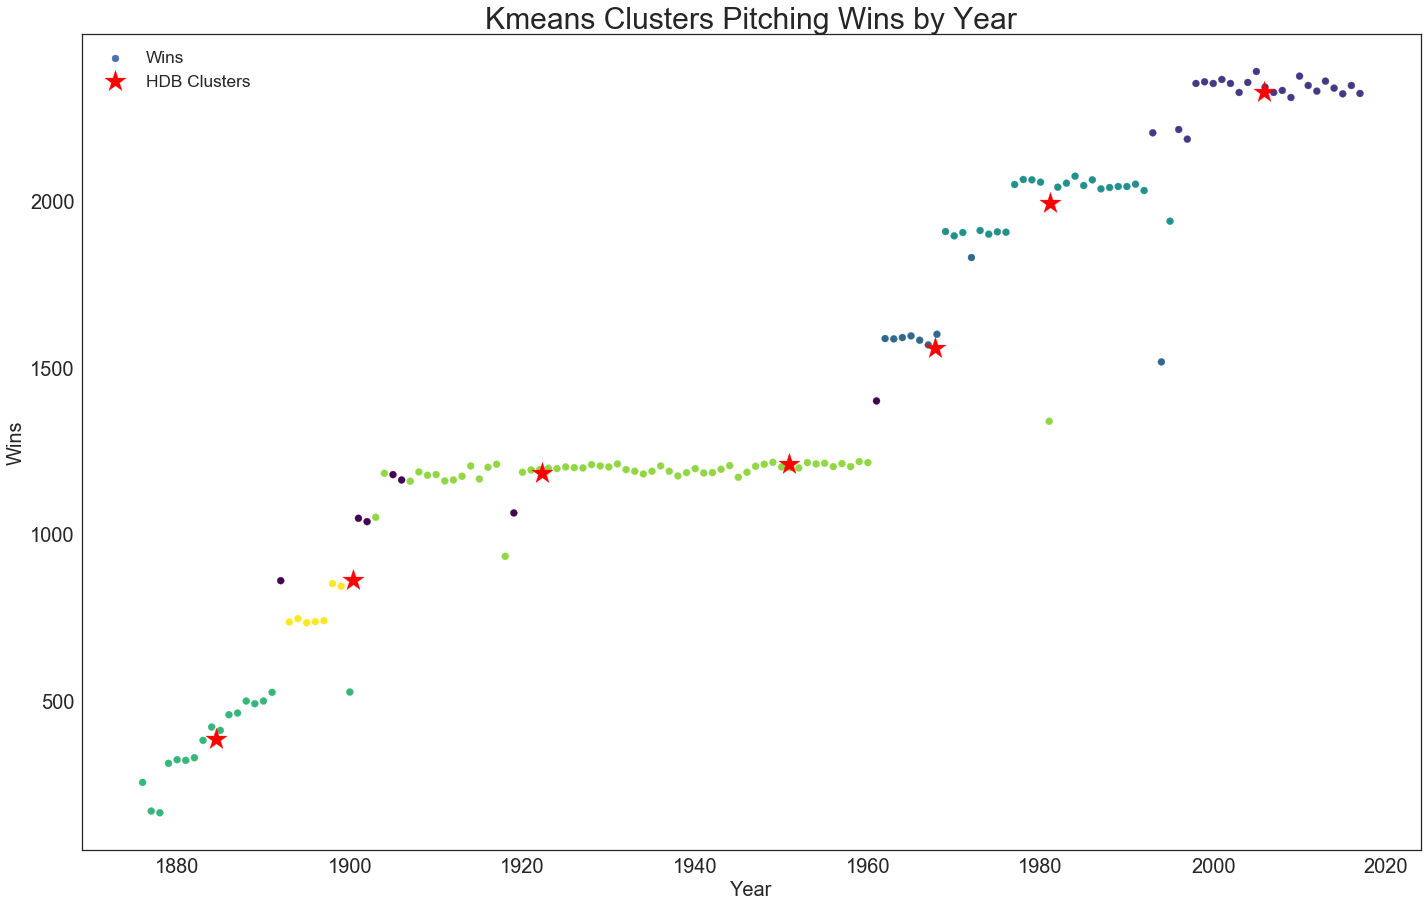

In [591]:

plt.figure(figsize=(24,15))
plt.scatter(pitching_year.index, pitching_year['w'],
           c=pitching_year['hdb_clusters'], cmap='viridis', label='Wins')

plt.scatter(centroids['year'], centroids['w'],
           c='red', marker='*', s=500, label='HDB Clusters')
plt.title('Kmeans Clusters Pitching Wins by Year', fontsize=30)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Wins', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize='xx-large');

# Model the Data

In [592]:
# Define my x and y
# we will test one cluster at a time
features = [each for each in pitching_year.columns if each not in ['kmeans_clusters','hdb_clusters', 'w', 'year']]
X = pitching_year[features]
y = pitching_year['kmeans_clusters']

In [593]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [594]:
X_train.head()

l      g    gs    cg  sho    sv  ipouts      h     er    hr  ...    \
year                                                                  ...     
1986  2009  11295  4043   573  138   999  109206  35417  15884  3654  ...     
1918   926   2688  1889  1205  183   104   50627  15567   5073   214  ...     
1993  2157  14223  4308   368   99  1186  116337  39113  17824  3815  ...     
1962  1558   7869  3148   830  165   608   84088  27428  12154  2877  ...     
1971  1894   9325  3806  1072  263   681  101845  31742  13010  2782  ...     

           bfp    gf      r      sh      sf    gidp    est_pc  period    era  \
year                                                                           
1986  155085.0  3508  17693  1460.0  1130.0  3000.0  489330.0       5  4.173   
1918   69260.0   606   6629     0.0     0.0     0.0  158226.0       1  2.859   
1993  166682.0  4031  19702  1734.0  1361.0  3281.0  520344.0       5  4.406   
1962  120069.0  2279  13785     0.0     0.0     0.0  363480.0       4  4.115   
1971  143079.0  2702  14637  1746.0   960.0     0.0  427965.0       4  3.717   

       whip  
year         
1986  0.157  
1918  0.140  
1993  0.159  
1962  0.156  
1971  0.152  

[5 rows x 27 columns]

In [595]:
y_train.head()

year
1986    13
1918     1
1993    13
1962     5
1971     8
Name: kmeans_clusters, dtype: int32

In [596]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   41.8s finished


building tree 1 of 1000building tree 2 of 1000building tree 3 of 1000building tree 4 of 1000



building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000building tree 9 of 1000

building tree 10 of 1000building tree 11 of 1000building tree 12 of 1000


building tree 13 of 1000building tree 14 of 1000

building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000building tree 20 of 1000building tree 21 of 1000


building tree 22 of 1000
building tree 23 of 1000building tree 24 of 1000

building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000building tree 35 of 1000

building tree 36 of 1000
building tree 37 of 1000building tree 38 of 1000

building tree 39 of 1000building tree 40 of 1000

building 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.0s


building tree 114 of 1000
building tree 115 of 1000
building tree 116 of 1000
building tree 117 of 1000
building tree 118 of 1000
building tree 119 of 1000
building tree 120 of 1000
building tree 121 of 1000
building tree 122 of 1000
building tree 123 of 1000
building tree 124 of 1000
building tree 125 of 1000
building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000building tree 130 of 1000

building tree 131 of 1000
building tree 132 of 1000
building tree 133 of 1000building tree 134 of 1000

building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    0.2s


building tree 206 of 1000
building tree 207 of 1000
building tree 208 of 1000
building tree 209 of 1000
building tree 210 of 1000
building tree 211 of 1000building tree 212 of 1000building tree 213 of 1000


building tree 214 of 1000
building tree 215 of 1000
building tree 216 of 1000
building tree 217 of 1000building tree 218 of 1000

building tree 219 of 1000building tree 220 of 1000

building tree 221 of 1000
building tree 222 of 1000
building tree 223 of 1000
building tree 224 of 1000building tree 225 of 1000

building tree 226 of 1000building tree 227 of 1000

building tree 228 of 1000
building tree 229 of 1000
building tree 230 of 1000building tree 231 of 1000
building tree 232 of 1000
building tree 233 of 1000

building tree 234 of 1000building tree 235 of 1000

building tree 236 of 1000building tree 237 of 1000

building tree 238 of 1000building tree 239 of 1000

building tree 240 of 1000building tree 241 of 1000building tree 242 of 1000


building tree 243 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    0.6s


building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000building tree 397 of 1000building tree 398 of 1000


building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000building tree 406 of 1000

building tree 407 of 1000
building tree 408 of 1000
building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000
building tree 412 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    1.4s


building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000building tree 678 of 1000

building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000building tree 685 of 1000

building tree 686 of 1000building tree 687 of 1000building tree 688 of 1000


building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000building tree 693 of 1000building tree 694 of 1000


building tree 695 of 1000
building tree 696 of 1000building tree 697 of 1000building tree 698 of 1000


building tree 699 of 1000
building tree 700 of 1000
building tree 701 of 1000
building tree 702 of 1000
building tree 703 of 1000
building tree 704 of 1000building tree 705 of 1000

building tree 706 of 1000
building tree 707 of 1000
building tree 708 of 1000building tree 709 of 1000

building tree 710 of 1000
building tree 711 of 1000
building tree 712 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.2s finished


0.9150943396226415

In [597]:
gs_rf.best_params_

{'rf__criterion': 'entropy',
 'rf__n_estimators': 1000,
 'rf__n_jobs': -1,
 'rf__random_state': 42,
 'rf__verbose': 2}

In [598]:
gs_rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.9166666666666666

In [599]:
y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


array([[2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

In [600]:
# pipe_lr = Pipeline([
#     ('ss', StandardScaler()),
#     ('lr', LogisticRegressionCV())
# ])

# params = {
#     'lr__Cs': [1, 10],
#     'lr__cv': [3,5,7],
#     'lr__penalty': ['l2'],
#     'lr__max_iter': [10,100,1000],
#     'lr__verbose': [2],
#     'lr__n_jobs': [2],
#     'lr__random_state': [42]
# }
# gs_lr = GridSearchCV(pipe_lr, params, n_jobs=-1, cv=5, verbose=2)
# gs_lr.fit(X_train, y_train)
# gs_lr.best_score_

In [601]:
# gs_lr.best_params_

In [602]:
# gs_lr.score(X_test, y_test)

In [603]:
# y_preds_gs_lr = gs_lr.predict(X_test)

# confusion_matrix(y_test, y_preds_gs_lr)

## Pitching Year

## PCA first

### Pitching by years

In [710]:
pitching_year.columns

Index(['w', 'l', 'g', 'gs', 'cg', 'sho', 'sv', 'ipouts', 'h', 'er', 'hr', 'bb',
       'so', 'baopp', 'ibb', 'wp', 'hbp', 'bk', 'bfp', 'gf', 'r', 'sh', 'sf',
       'gidp', 'est_pc', 'period', 'era', 'whip', 'kmeans_clusters', 'year',
       'hdb_clusters'],
      dtype='object')

### Scale data for use with PCA

We already did this above

### Find Z scores

In [711]:
pitching_year_ss

w         l         g        gs        cg       sho        sv  \
0   -1.899895 -1.906185 -1.203515 -1.938177 -0.923017 -1.287931 -1.051001   
1   -2.041399 -2.016832 -1.232228 -2.067117 -1.234104 -1.700567 -1.069038   
2   -2.049626 -2.030244 -1.238080 -2.075600 -1.213962 -1.612145 -1.073547   
3   -1.806107 -1.805596 -1.182849 -1.836382 -0.623120 -1.317405 -1.071293   
4   -1.788007 -1.788832 -1.171510 -1.811781 -0.638786 -1.228983 -1.048746   
5   -1.791298 -1.797214 -1.180837 -1.827051 -0.614168 -1.214246 -1.075802   
6   -1.778135 -1.772067 -1.177180 -1.807540 -0.538075 -1.376353 -1.073547   
7   -1.692574 -1.693273 -1.151759 -1.717621 -0.385888 -1.420564 -1.055510   
8   -1.626758 -1.646332 -1.144626 -1.653999 -0.159846 -0.978454 -1.066783   
9   -1.643212 -1.637949 -1.149564 -1.670117 -0.157608 -0.978454 -1.069038   
10  -1.565878 -1.597714 -1.131093 -1.592074 -0.007660 -1.332142 -1.069038   
11  -1.557651 -1.584302 -1.128898 -1.578502  0.052767 -1.479512 -1.064529   
12  -1.498416 -1.480361 -1.112073 -1.498762  0.267619 -0.668977 -1.071293   
13  -1.511580 -1.537361 -1.108232 -1.534390  0.021435 -1.361616 -1.051001   
14  -1.498416 -1.534008 -1.109878 -1.534390  0.079624 -1.170035 -1.060019   
15  -1.455636 -1.483714 -1.089395 -1.486886  0.075148 -1.228983 -1.023944   
16  -0.904426 -0.903654 -0.952049 -0.896476  1.523158 -0.668977 -1.023944   
17  -1.108456 -1.136684 -0.994661 -1.136542  0.784605 -1.376353 -1.023944   
18  -1.092002 -1.143390 -0.985700 -1.124666  0.764463 -1.538460 -1.005907   
19  -1.111747 -1.123272 -0.986431 -1.122121  0.728654 -1.317405 -1.005907   
20  -1.106811 -1.128302 -0.991369 -1.118728  0.791320 -1.170035 -1.019435   
21  -1.101875 -1.129978 -0.988992 -1.102611  0.905459 -1.258457 -1.019435   
22  -0.919235 -0.932154 -0.950403 -0.907504  1.433636 -0.786873 -1.041982   
23  -0.932398 -0.955625 -0.956987 -0.938890  1.344115 -0.668977 -1.014926   
24  -1.453991 -1.435096 -1.070375 -1.446168  0.059481 -0.978454 -1.051001   
25  -0.596736 -0.625360 -0.872677 -0.604664  2.102809 -0.212130 -0.994633   
26  -0.613190 -0.692419 -0.890234 -0.638596  2.098333  0.274191 -1.005907   
27  -0.591800 -0.632066 -0.872311 -0.607209  2.060287  0.333139 -0.976596   
28  -0.374607 -0.390654 -0.822384 -0.349328  2.751840  1.615258 -0.992379   
29  -0.381189 -0.377242 -0.781601 -0.353570  2.319899  1.276307 -0.981105   
..        ...       ...       ...       ...       ...       ...       ...   
112  1.035502  1.062848  0.706348  1.045261 -0.576121  0.657353  1.275834   
113  1.040439  1.019260  0.803459  1.025751 -0.876018  0.229980  1.320928   
114  1.040439  0.984054  0.884111  0.992667 -0.990158  0.067873  1.411115   
115  1.051956  1.046084  0.995671  1.035082 -1.124440 -0.403711  1.460718   
116  1.020694  1.027642  1.018348  0.996060 -1.014776  0.141558  1.415624   
117  1.305348  1.310966  1.299991  1.292962 -1.115488 -0.506870  1.598254   
118  0.174957  0.162582  0.531327  0.131652 -1.395243 -1.007928  0.669324   
119  0.869317  0.841554  1.083090  0.828099 -1.328102 -0.683714  1.185647   
120  1.321802  1.305937  1.432399  1.316714 -1.296769 -0.742662  1.435917   
121  1.274086  1.257319  1.470988  1.247154 -1.352720 -0.668977  1.490029   
122  1.548868  1.555731  1.640522  1.560174 -1.272151 -0.506870  1.774119   
123  1.557095  1.562437  1.714407  1.566112 -1.413147 -1.022665  1.654621   
124  1.548868  1.545672  1.686243  1.546601 -1.426575 -0.948980  1.568943   
125  1.568613  1.530584  1.788109  1.539815 -1.500431 -0.890032  1.645602   
126  1.548868  1.512143  1.787561  1.522849 -1.466860 -0.698451  1.672658   
127  1.504442  1.451790  1.779697  1.446503 -1.491478 -0.948980  1.616291   
128  1.553804  1.512143  1.898572  1.507580 -1.610094 -0.963717  1.690696   
129  1.608102  1.600996  1.863092  1.627189 -1.518335 -1.037402  1.747063   
130  1.530768  1.465202  1.949413  1.451593 -1.623523 -1.081613  1.625310   
131  1.504442  1.486996  2.053109  1.470255 -1.692902 -1.361616  1.605018   
132  1.5

### Visualize correlation

In [336]:
# g = sns.PairGrid(batting_year_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

Text(0.5,1,'Pitching Stats by Year Correlation')

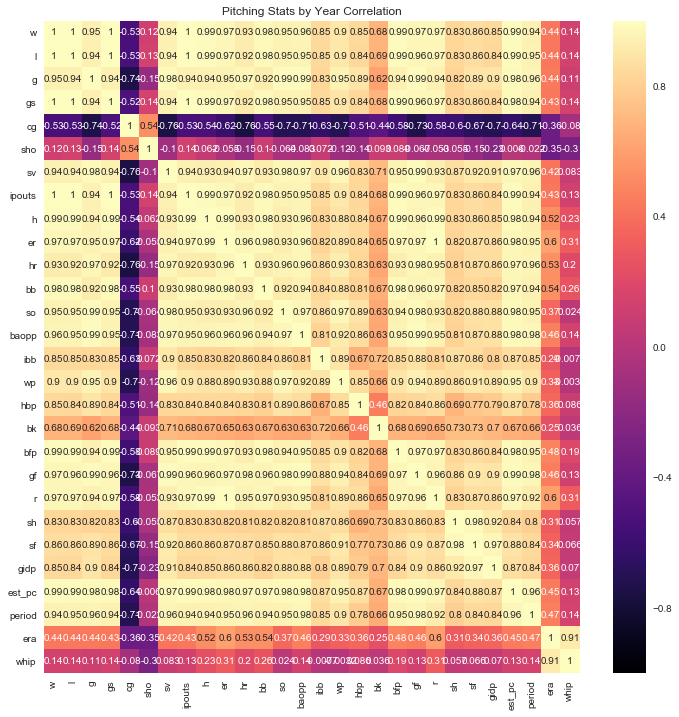

In [712]:
plt.figure(figsize=(12,12))
sns.heatmap(pitching_year_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Pitching Stats by Year Correlation')

### PCA for pitching stats

In [713]:
pitching_year_pca = PCA(n_components=28)
pitching_year_pca.fit(pitching_year_ss.values)

PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Explained variance

In [714]:
for each in pitching_year_pca.components_:
    for each in list(zip(pitching_year_ss.columns, each)):
        print(each)
    print()

('w', 0.2068951568147732)
('l', 0.20663657719409945)
('g', 0.20720147680646608)
('gs', 0.20611858170893405)
('cg', -0.14308224179106302)
('sho', -0.010450947147037187)
('sv', 0.20828272907324755)
('ipouts', 0.20656075783288083)
('h', 0.20663805576682934)
('er', 0.20759289179569987)
('hr', 0.20548359670213132)
('bb', 0.2049911425160412)
('so', 0.20612123735840931)
('baopp', 0.20709360511025743)
('ibb', 0.18703268322284053)
('wp', 0.2007939197824903)
('hbp', 0.1815190262709235)
('bk', 0.1493745586703852)
('bfp', 0.2067346092689095)
('gf', 0.21016619415530666)
('r', 0.20636823095468457)
('sh', 0.1860638970206006)
('sf', 0.19470122857598138)
('gidp', 0.19246459584813758)
('est_pc', 0.21006813143970254)
('period', 0.2042099211451316)
('era', 0.10181335380662263)
('whip', 0.034777305005836555)

('w', -0.06591419274557987)
('l', -0.06727141312791038)
('g', 0.013242512696078932)
('gs', -0.0701529380557782)
('cg', -0.16408969964837763)
('sho', -0.4646174130252547)
('sv', -0.022507984357752787)


In [715]:
pitching_year_pca.explained_variance_

array([2.25070266e+01, 2.13844141e+00, 1.58003942e+00, 7.76534717e-01,
       4.58313709e-01, 2.67358981e-01, 1.80488557e-01, 6.55687247e-02,
       4.86432240e-02, 3.99850995e-02, 3.71815120e-02, 3.22744961e-02,
       1.91518344e-02, 1.18242410e-02, 1.00409634e-02, 8.11419047e-03,
       6.13134619e-03, 4.51416461e-03, 3.12311111e-03, 1.53832538e-03,
       1.35344440e-03, 3.91263540e-04, 2.32978357e-04, 1.33697811e-04,
       8.96694559e-05, 4.80328291e-05, 3.78303296e-05, 2.05590738e-31])

In [716]:
pitching_year_pca.explained_variance_ratio_

array([7.98161658e-01, 7.58350703e-02, 5.60325851e-02, 2.75380772e-02,
       1.62530767e-02, 9.48129182e-03, 6.40062540e-03, 2.32524904e-03,
       1.72502379e-03, 1.41798265e-03, 1.31855966e-03, 1.14454325e-03,
       6.79177225e-04, 4.19320418e-04, 3.56080443e-04, 2.87751724e-04,
       2.17434561e-04, 1.60084811e-04, 1.10754192e-04, 5.45532894e-05,
       4.79968965e-05, 1.38752915e-05, 8.26205943e-06, 4.74129560e-06,
       3.17992789e-06, 1.70337749e-06, 1.34156853e-06, 7.29081843e-33])

### Transform batters stats into PCA space

In [717]:
pitching_year_pca_transformed = pitching_year_pca.transform(pitching_year_ss)

In [718]:
pitching_year_pca_transformed = pd.DataFrame(pitching_year_pca_transformed,
                                       columns=pitching_year_ss.columns)

pitching_year_pca_transformed

w         l         g        gs        cg       sho        sv  \
0   -7.041449 -0.971226  3.542758  0.342339 -0.424268 -0.204368 -0.423001   
1   -6.948559  1.294278  3.095089  0.835835 -0.596541 -0.391292 -0.059789   
2   -7.219089 -0.694894  3.994833  0.377367 -0.538168 -0.192311 -0.333698   
3   -6.789327 -1.150414  3.449854  0.203481 -0.281468 -0.139710 -0.254431   
4   -6.842567 -1.667875  3.626290  0.079776 -0.341065 -0.077202 -0.381524   
5   -6.673779 -0.368961  2.943464  0.447700 -0.325299 -0.239765 -0.167774   
6   -6.634687 -0.469441  3.073820  0.334568 -0.279568 -0.173910 -0.177244   
7   -6.337096  0.301077  2.559338  0.476154 -0.172417 -0.249629 -0.017789   
8   -6.192402 -0.487335  2.459117  0.296849 -0.172955 -0.258162  0.063617   
9   -6.329607 -0.757816  2.584332  0.309451 -0.167218 -0.187819 -0.025053   
10  -5.982638  0.318636  2.189693  0.428623 -0.007546 -0.262101  0.221394   
11  -5.738774  1.419467  1.683838  0.421334  0.293923 -0.196458  0.477927   
12  -6.026014 -1.500195  2.330485 -0.138487  0.257826  0.007769  0.133083   
13  -5.573841  1.896552  1.254436  0.538061  0.265281 -0.291862  0.437098   
14  -5.610374  1.282470  1.386866  0.388710  0.346580 -0.207004  0.486011   
15  -5.557678  0.918273  1.535293  0.271931  0.388181 -0.171767  0.367044   
16  -4.497008 -0.010374  0.114705 -0.218079  1.222606 -0.006459  0.506201   
17  -4.352227  3.048618 -0.261107  0.441042  0.980203 -0.166943  0.804297   
18  -4.114368  4.499208 -0.863483  0.744415  0.941703 -0.335984  0.910226   
19  -4.405175  3.196009 -0.337509  0.449194  0.945419 -0.153086  0.731823   
20  -4.611522  2.253474  0.003584  0.310243  0.929492 -0.117802  0.623145   
21  -4.576359  2.039254  0.104168  0.156258  1.148045  0.017012  0.711093   
22  -4.505303  0.557574 -0.002948 -0.227663  1.477497  0.227825  0.661856   
23  -4.431010  0.922861 -0.224363  0.121013  1.357236  0.378512  0.723699   
24  -5.546279  1.090885  1.215480  0.346617  0.420081 -0.048387  0.338903   
25  -3.976061 -0.357651 -0.529649 -0.558925  1.586643  0.351736  0.487933   
26  -4.311303 -1.233530 -0.441994 -0.546896  1.378359  0.276861  0.260538   
27  -3.971922 -1.217394 -0.636481 -0.599833  1.278443  0.230976  0.183985   
28  -3.801429 -3.099010 -1.303406 -0.787089  1.397571  0.363110  0.160580   
29  -3.696069 -2.670761 -0.927695 -0.925995  1.316376  0.330095  0.214954   
..        ...       ...       ...       ...       ...       ...       ...   
112  5.761966 -1.953241  0.093118  5.138338 -0.304568  3.971438  0.842932   
113  5.101635 -1.302860  0.531346  2.121507 -0.260758  0.726656  0.092146   
114  5.089967 -0.809350  0.583350  1.335389 -0.213853  0.054570  0.008821   
115  5.263024 -0.431619  0.856008  0.888875 -0.053294 -0.037105 -0.130462   
116  5.046564 -0.875934  0.628174  0.836061  0.015114 -0.338552 -0.152853   
117  6.838969  0.168300  0.502880  1.065904  0.322728  0.138397  0.217877   
118  2.976436  1.579879  1.158765  0.742709 -0.489204 -0.184871 -0.034230   
119  5.482144  1.149200  0.612187  0.326422 -0.046630 -0.023828 -0.043490   
120  7.450201  1.179922  0.315080  0.039939  0.272438 -0.147997  0.226042   
121  7.024685  0.958924  0.456629 -0.076386  0.246431 -0.070578  0.007258   
122  8.022568  0.539861  0.288297 -0.315965  0.511306  0.153544 -0.068320   
123  8.353963  1.522385  0.261904 -0.435811  0.549218 -0.040535 -0.059505   
124  8.340893  1.648688  0.145480 -0.434859  0.454539 -0.253011 -0.108629   
125  8.124798  0.658053  0.759813 -0.897940  0.601516 -0.065790  0.277807   
126  7.986472  0.504700  0.674445 -0.697899  0.492281 -0.239976  0.216304   
127  7.752093  0.680031  0.829968 -0.841444  0.570510  0.034340  0.216964   
128  8.224910  0.900400  0.762022 -0.800542  0.509367 -0.116441  0.220154   
129  8.002775  0.650482  0.857359 -0.885349  0.685588  0.102065 -0.025799   
130  8.180796  1.064653  0.853660 -0.887005  0.365765 -0.177159  0.036618   
131  8.149047  1.296420  0.965684 -0.956836  0.403139 -0.064474 -0.101344   
132  7.9

### Visualize transformed PCA features
-There should be no correlation

In [350]:
# sns.pairplot(batting_year_pca_transformed)

## Now  KMeans Clustering

In [719]:
pitching_year[pitching_year.columns]

w     l      g    gs    cg  sho    sv  ipouts      h     er  \
year                                                                   
1876   255   238    534   499   454   46    11   13560   5001   1113   
1877   169   172    377   347   315   18     3    9358   3564    970   
1878   164   164    345   337   324   24     1    9107   3195    743   
1879   312   298    647   619   588   44     2   16752   5892   1513   
1880   323   308    709   648   581   50    12   17145   5546   1452   
1881   321   303    658   630   592   51     0   16738   5838   1666   
1882   329   318    678   653   626   40     1   17530   5920   1830   
1883   381   365    817   759   694   37     9   19970   7176   2224   
1884   421   393    856   834   795   67     4   21952   7147   2298   
1885   411   398    829   815   796   67     3   21390   6798   2178   
1886   458   422    930   907   863   43     3   23421   7725   2722   
1887   463   430    942   923   890   33     5   24067   8567   3429   
1888   499   492   1034  1017   986   88     2   26776   8257   2716   
1889   491   458   1055   975   876   41    11   25490   8940   3612   
1890   499   460   1046   975   902   54     7   25807   8380   3192   
1891   525   490   1158  1031   900   50    23   27344   9078   3320   
1892   860   836   1909  1727  1547   88    23   45402  14557   5379   
1893   736   697   1676  1444  1217   40    23   38391  14469   6356   
1894   746   693   1725  1458  1208   29    31   38006  16080   7217   
1895   734   705   1721  1461  1192   44    31   37945  15204   6474   
1896   737   702   1694  1465  1220   54    25   38003  14614   5920   
1897   740   701   1707  1484  1271   48    25   38684  15044   5982   
1898   851   819   1918  1714  1507   80    15   44479  15603   5794   
1899   843   805   1882  1677  1467   88    27   43390  15922   5964   
1900   526   519   1262  1079   893   67    11   27952  10165   3732   
1901  1047  1002   2343  2071  1806  119    36   54729  19312   6842   
1902  1037   962   2247  2031  1804  152    31   53974  18206   6090   
1903  1050   998   2345  2068  1787  156    44   54643  18105   6140   
1904  1182  1142   2618  2372  2096  243    37   62388  19054   5966   
1905  1178  1150   2841  2367  1903  220    42   62869  19118   6445   
...    ...   ...    ...   ...   ...  ...   ...     ...    ...    ...   
1988  2039  2009  10977  4016   609  178  1043  108264  34466  14746   
1989  2042  1983  11508  3993   475  149  1063  108095  34378  14530   
1990  2042  1962  11949  3954   424  138  1103  106822  34610  14942   
1991  2049  1999  12559  4004   364  106  1125  108576  34732  15409   
1992  2030  1988  12683  3958   413  143  1105  108070  34525  14711   
1993  2203  2157  14223  4308   368   99  1186  116337  39113  17824   
1994  1516  1472  10020  2939   243   65   774   80237  27554  13027   
1995  1938  1877  13037  3760   273   87  1003  101665  34404  16356   
1996  2213  2154  14947  4336   287   83  1114  117152  40324  19577   
1997  2184  2125  15158  4254   262   88  1138  115405  39011  18277   
1998  2351  2303  16085  4623   298   99  1264  124852  42281  20055   
1999  2356  2307  16489  4630   235   64  1211  124153  43087  21205   
2000  2351  2297  16335  4607   229   69  1173  123646  42611  21283   
2001  2363  2288  16892  4599   196   73  1207  123978  41582  19868   
2002  2351  2277  16889  4579   211   86  1219  123975  40979  19218   
2003  2324  2241  16846  4489   200   69  1194  121918  40909  19336   
2004  2354  2277  17496  4561   147   68  1227  124142  42045  20012   
2005  2387  2330  17302  4702   188   63  1252  125234  42158  19451   
2006  2340  2249  17774  4495   141   60  1198  122199  42029  19988   
2007  2324  2262  18341  4517   110   41  1189  123070  42103  19878   
2008  2330  2261  18074  4514   131   51  1181  122752  40997  19190   
2009  2309  2259  18137  4488   148   61  1200  121865  40383  19001   
2010  2373  2306  18054  4639   164   59  1202  1

In [742]:
# Fitting pitching data on KMeans
pitching_year_cluster = pitching_year[pitching_year.columns]
km = KMeans(n_clusters=8,
           random_state=42)
km.fit(pitching_year_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [743]:
#looking at labels
km.labels_

array([6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5,
       5, 5, 2, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 7, 7,
       1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4,
       4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [744]:
#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

1    35
0    24
3    23
7    21
5    13
4     9
2     9
6     8
dtype: int64

In [745]:
#saving labels to clustering data frame
pitching_year['kmeans_clusters'] = km.labels_

In [746]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=pitching_year,
                        by='era',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [747]:
show_cluster_results(6, 'kmeans_clusters')[pitching_year.columns]

w    l    g   gs   cg  sho  sv  ipouts     h    er       ...        \
year                                                             ...         
1877  169  172  377  347  315   18   3    9358  3564   970       ...         
1883  381  365  817  759  694   37   9   19970  7176  2224       ...         
1882  329  318  678  653  626   40   1   17530  5920  1830       ...         
1881  321  303  658  630  592   51   0   16738  5838  1666       ...         
1879  312  298  647  619  588   44   2   16752  5892  1513       ...         
1878  164  164  345  337  324   24   1    9107  3195   743       ...         
1880  323  308  709  648  581   50  12   17145  5546  1452       ...         
1876  255  238  534  499  454   46  11   13560  5001  1113       ...         

       sf  gidp   est_pc  period    era   whip  kmeans_clusters  year  \
year                                                                    
1877  0.0   0.0  21582.0       0  3.504  0.155                6  1877   
1883  0.0   0.0  59832.0       0  3.312  0.146                6  1883   
1882  0.0   0.0  48384.0       0  3.003  0.136                6  1882   
1881  0.0   0.0  45297.0       0  2.899  0.141                6  1881   
1879  0.0   0.0  40206.0       0  2.551  0.131                6  1879   
1878  0.0   0.0  22449.0       0  2.439  0.136                6  1878   
1880  0.0   0.0  42585.0       0  2.425  0.124                6  1880   
1876  0.0   0.0  24507.0       0  2.360  0.136                6  1876   

      hdb_clusters  kmean_clusters  
year                                
1877            -1               9  
1883             2               9  
1882             2               9  
1881             2               9  
1879             2               9  
1878            -1               9  
1880             2               9  
1876            -1               9  

[8 rows x 32 columns]

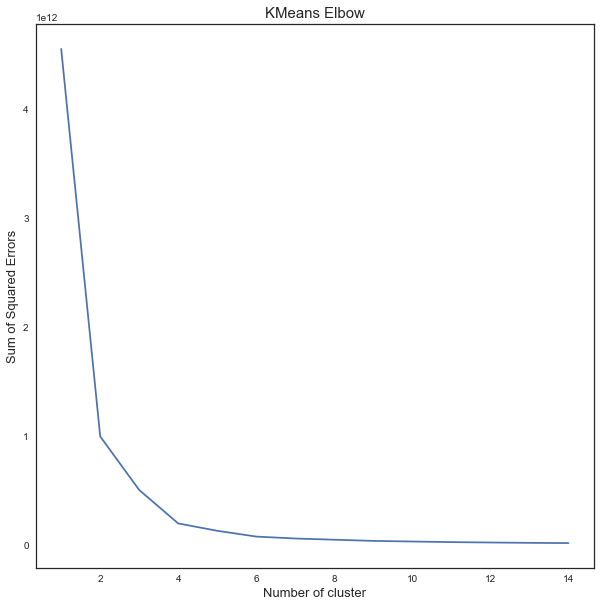

In [748]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(pitching_year)
    pitching_year['kmean_clusters'] = kmeans.labels_
    #print(batters["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('KMeans Elbow', fontsize=15)
plt.xlabel("Number of cluster", fontsize=13)
plt.ylabel("Sum of Squared Errors", fontsize=13)
plt.show()

In [749]:
ks = range(2,16)
sil = []

for n_cluster in range(2, 16):
    kmeans = KMeans(n_clusters=n_cluster).fit(pitching_year)
    label = kmeans.labels_
    sil_coeff = silhouette_score(pitching_year, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    sil.append(sil_coeff)

For n_clusters=2, The Silhouette Coefficient is 0.6952298395626949
For n_clusters=3, The Silhouette Coefficient is 0.6445219790479827
For n_clusters=4, The Silhouette Coefficient is 0.6997618989707152
For n_clusters=5, The Silhouette Coefficient is 0.7016211473912958
For n_clusters=6, The Silhouette Coefficient is 0.6844920939640555
For n_clusters=7, The Silhouette Coefficient is 0.6321158940927283
For n_clusters=8, The Silhouette Coefficient is 0.6235411230149234
For n_clusters=9, The Silhouette Coefficient is 0.588341888851402
For n_clusters=10, The Silhouette Coefficient is 0.5631923228060225
For n_clusters=11, The Silhouette Coefficient is 0.5675416546435622
For n_clusters=12, The Silhouette Coefficient is 0.5543724628909151
For n_clusters=13, The Silhouette Coefficient is 0.5096240099411983
For n_clusters=14, The Silhouette Coefficient is 0.5236077752888876
For n_clusters=15, The Silhouette Coefficient is 0.5428544230454253


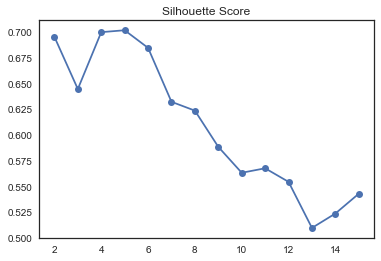

In [750]:
plt.plot(ks, sil, '-o')
plt.title('Silhouette Score');

In [751]:
pitching_year['year'] = batting_year.index

In [752]:
# Call k-means to cluster the stats
kmeans = KMeans(n_clusters=8, random_state=42)
model = kmeans.fit(pitching_year)
centroids = pd.DataFrame(model.cluster_centers_, columns = pitching_year.columns)

In [753]:
pitching_year.columns

Index(['w', 'l', 'g', 'gs', 'cg', 'sho', 'sv', 'ipouts', 'h', 'er', 'hr', 'bb',
       'so', 'baopp', 'ibb', 'wp', 'hbp', 'bk', 'bfp', 'gf', 'r', 'sh', 'sf',
       'gidp', 'est_pc', 'period', 'era', 'whip', 'kmeans_clusters', 'year',
       'hdb_clusters', 'kmean_clusters'],
      dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


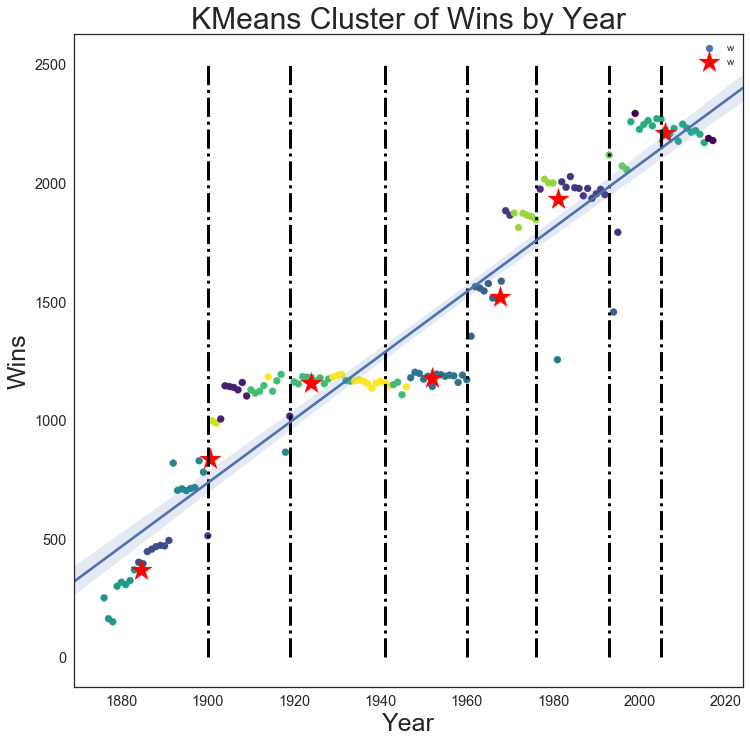

In [343]:
plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(pitching_year['year'], pitching_year['w'],
                c=pitching_year['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['year'], centroids['w'],
           c='red', marker='*', s=500)
ax = sns.regplot(x=pitching_year['year'], y=pitching_year['w'],
                scatter=False, logistic=False, order=1)
plt.vlines(x=1900, ymin=0, ymax=2500, linestyles='dashdot', lw=3)
plt.vlines(x=1919, ymin=0, ymax=2500, linestyles='dashdot', lw=3)
plt.vlines(x=1941, ymin=0, ymax=2500, linestyles='dashdot', lw=3)
plt.vlines(x=1960, ymin=0, ymax=2500, linestyles='dashdot', lw=3)
plt.vlines(x=1976, ymin=0, ymax=2500, linestyles='dashdot', lw=3)
plt.vlines(x=1993, ymin=0, ymax=2500, linestyles='dashdot', lw=3)
plt.vlines(x=2005, ymin=0, ymax=2500, linestyles='dashdot', lw=3)
plt.title('KMeans Cluster of Wins by Year', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Wins', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend();

## HDBSCAN

In [325]:
hdb = HDBSCAN(min_cluster_size=3)
hdb.fit(pitching_year)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=3, min_samples=None, p=None,
    prediction_data=False)

In [326]:
# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

-1     8
 0     9
 1    25
 2    22
 3     5
 4     9
 5     9
 6    55
dtype: int64

In [327]:
pitching_year['hdb_clusters'] = hdb.labels_

In [328]:
#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=pitching_year,
                        by='era',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

In [329]:
show_cluster_results(2, 'hdb_clusters')

w     l      g    gs   cg  sho    sv  ipouts      h     er  \
year                                                                  
2000  2225  2119  15366  4250  219   65  1160  115306  39558  19617   
1999  2292  2218  15874  4446  228   62  1199  119589  41389  20250   
1996  2071  2003  14070  3987  279   78  1109  109253  37421  17969   
2006  2223  2092  16936  4154  135   55  1196  114977  39333  18576   
1998  2257  2160  15392  4324  282   92  1260  118243  39864  18820   
2007  2206  2095  17463  4145  107   40  1188  115426  39077  18244   
2004  2270  2136  16779  4280  141   63  1218  117981  39713  18705   
2001  2246  2142  16135  4255  187   69  1205  116684  38900  18465   
2003  2240  2123  16127  4251  199   69  1188  116261  38807  18235   
1997  2056  1931  14168  3846  257   85  1123  106621  35708  16498   
2005  2268  2209  16544  4403  182   61  1239  118423  39680  18255   
2002  2262  2138  16130  4289  205   83  1217  117425  38490  17968   
2017  2178  2088  18373  4090   54   24  1159  112963  35968  17471   
2008  2229  2119  17218  4197  127   49  1174  115719  38433  17798   
2009  2175  2081  17211  4096  139   57  1191  113765  37390  17406   

          ...           sh      sf    gidp    est_pc  period    era   whip  \
year      ...                                                                
2000      ...       1466.0  1310.0  3432.0  566688.0       6  4.722  0.164   
1999      ...       1474.0  1335.0  3541.0  581172.0       6  4.693  0.165   
1996      ...       1386.0  1211.0  3257.0  525243.0       6  4.588  0.162   
2006      ...       1457.0  1184.0  3456.0  541992.0       7  4.480  0.159   
1998      ...       1556.0  1233.0  3377.0  561759.0       6  4.428  0.158   
2007      ...       1347.0  1248.0  3514.0  547254.0       7  4.422  0.158   
2004      ...       1565.0  1212.0  3422.0  555309.0       6  4.417  0.157   
2001      ...       1457.0  1266.0  3296.0  552177.0       6  4.370  0.155   
2003      ...       1436.0  1150.0  3411.0  537519.0       6  4.362  0.156   
1997      ...       1373.0  1151.0  3059.0  510231.0       6  4.344  0.159   
2005      ...       1488.0  1170.0  3559.0  540876.0       6  4.316  0.155   
2002      ...       1465.0  1250.0  3453.0  551007.0       6  4.296  0.155   
2017      ...        794.0   986.0  3283.0  594987.0       7  4.286  0.148   
2008      ...       1334.0  1192.0  3420.0  555525.0       7  4.268  0.155   
2009      ...       1435.0  1145.0  3331.0  554463.0       7  4.264  0.156   

      year  kmeans_clusters  hdb_clusters  
year                                       
2000  2000                8             2  
1999  1999                0             2  
1996  1996               10             2  
2006  2006                8             2  
1998  1998                8             2  
2007  2007                8             2  
2004  2004                8             2  
2001  2001                8             2  
2003  2003                8             2  
1997  1997               10             2  
2005  2005                8             2  
2002  2002                8             2  
2017  2017                0             2  
2008  2008                8             2  
2009  2009                8             2  

[15 rows x 31 columns]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


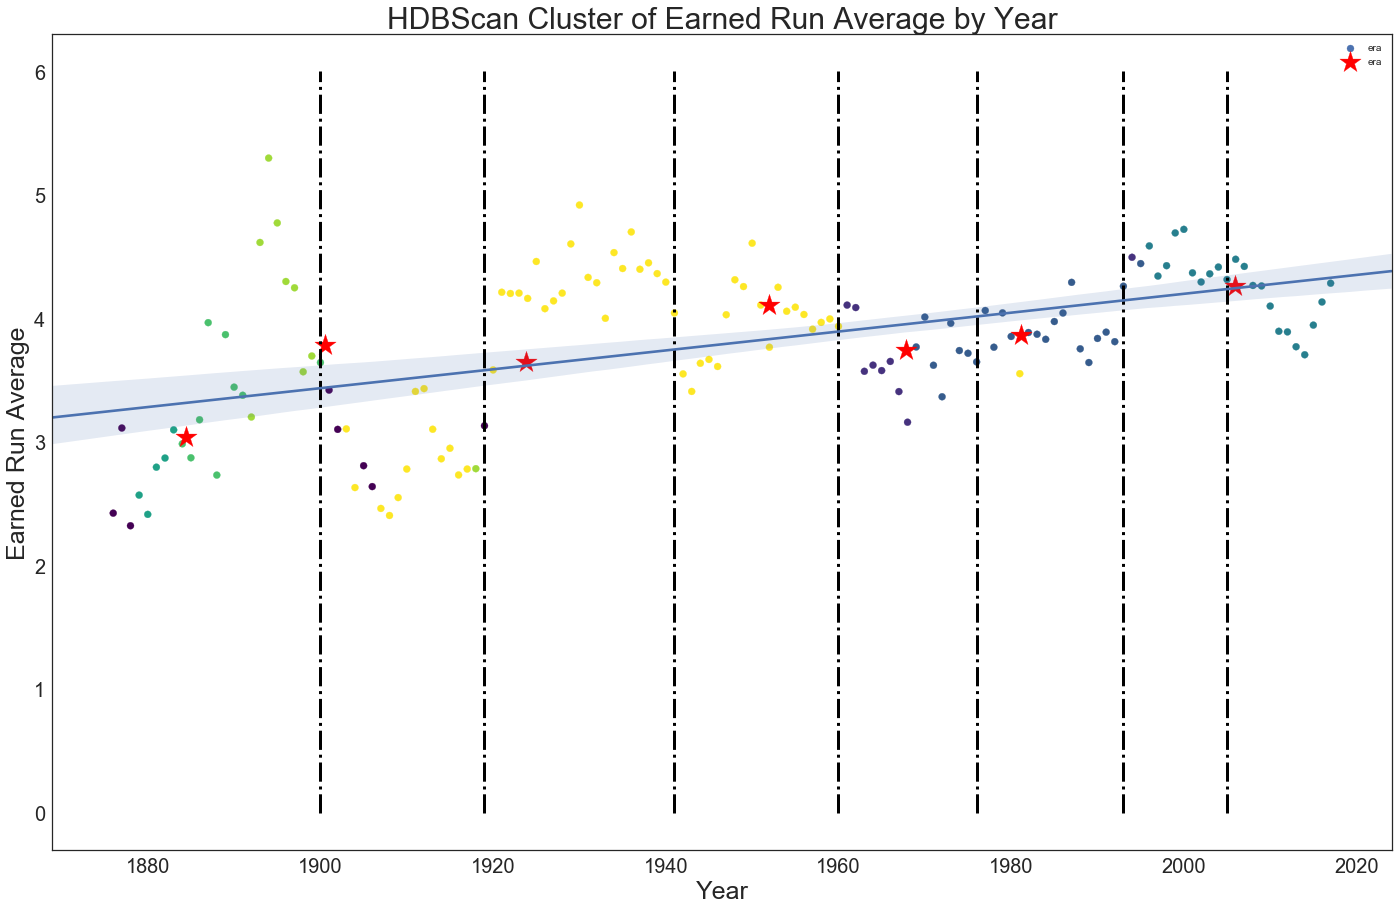

In [341]:

plt.figure(figsize=(24,15))
plt.scatter(pitching_year['year'], pitching_year['era'],
           c=pitching_year['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['year'], centroids['era'],
           c='red', marker='*', s=500)
ax = sns.regplot(x=pitching_year['year'], y=pitching_year['era'],
                scatter=False, logistic=False, order=1)
plt.vlines(x=1900, ymin=0, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=1919, ymin=0, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=1941, ymin=0, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=1960, ymin=0, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=1976, ymin=0, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=1993, ymin=0, ymax=6, linestyles='dashdot', lw=3)
plt.vlines(x=2005, ymin=0, ymax=6, linestyles='dashdot', lw=3)
plt.title('HDBScan Cluster of Earned Run Average by Year', fontsize=30)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Earned Run Average', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis= 'both',
               which= 'major',
               direction= 'in')
plt.legend();

# Model the Data

In [353]:
# Define my x and y
# we will test one cluster at a time
features = [each for each in pitching_year.columns if each not in ['year', 'period','kmeans_clusters','hdb_clusters']]
X = pitching_year[features]
y = pitching_year['period']

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [346]:
X_train.head()

kmeans_clusters  hdb_clusters
year                               
1986                2             1
1918                6             5
1993               10             1
1962                4             0
1971               11             1

In [347]:
y_train.head()

year
1986    5
1918    1
1993    5
1962    4
1971    4
Name: period, dtype: int64

In [348]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   36.3s finished


building tree 1 of 1000building tree 2 of 1000building tree 3 of 1000building tree 4 of 1000



building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000building tree 8 of 1000

building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000building tree 13 of 1000building tree 14 of 1000building tree 15 of 1000



building tree 16 of 1000building tree 17 of 1000

building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000building tree 22 of 1000

building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000building tree 26 of 1000

building tree 27 of 1000
building tree 28 of 1000building tree 29 of 1000building tree 30 of 1000building tree 31 of 1000

building tree 32 of 1000


building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.0s



building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000building tree 141 of 1000
building tree 142 of 1000

building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000building tree 156 of 1000

building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000building tree 160 of 1000

building tree 161 of 1000building tree 162 of 1000

building tree 163 of 1000
building tree 164 of 1000building tree 165 of 1000

building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000building tree 174 of 1000

building tree 175 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    0.2s


building tree 237 of 1000building tree 238 of 1000

building tree 239 of 1000building tree 240 of 1000

building tree 241 of 1000
building tree 242 of 1000
building tree 243 of 1000
building tree 244 of 1000
building tree 245 of 1000
building tree 246 of 1000
building tree 247 of 1000
building tree 248 of 1000
building tree 249 of 1000building tree 250 of 1000

building tree 251 of 1000
building tree 252 of 1000
building tree 253 of 1000
building tree 254 of 1000
building tree 255 of 1000
building tree 256 of 1000
building tree 257 of 1000building tree 258 of 1000

building tree 259 of 1000
building tree 260 of 1000
building tree 261 of 1000
building tree 262 of 1000
building tree 263 of 1000
building tree 264 of 1000
building tree 265 of 1000
building tree 266 of 1000
building tree 267 of 1000building tree 268 of 1000

building tree 269 of 1000building tree 270 of 1000

building tree 271 of 1000building tree 272 of 1000

building tree 273 of 1000building tree 274 of 1000

building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    0.6s


building tree 397 of 1000building tree 398 of 1000

building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000
building tree 406 of 1000building tree 407 of 1000
building tree 408 of 1000

building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000
building tree 412 of 1000
building tree 413 of 1000
building tree 414 of 1000
building tree 415 of 1000
building tree 416 of 1000building tree 417 of 1000

building tree 418 of 1000
building tree 419 of 1000
building tree 420 of 1000
building tree 421 of 1000
building tree 422 of 1000building tree 423 of 1000

building tree 424 of 1000building tree 425 of 1000

building tree 426 of 1000building tree 427 of 1000

building tree 428 of 1000building tree 429 of 1000

building tree 430 of 1000
building tree 431 of 1000
building tree 432 of 1000
building tree 433 of 1000building tree 434 of 1000

building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    1.2s


building tree 686 of 1000
building tree 687 of 1000building tree 688 of 1000

building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000
building tree 693 of 1000building tree 694 of 1000

building tree 695 of 1000
building tree 696 of 1000
building tree 697 of 1000building tree 698 of 1000

building tree 699 of 1000
building tree 700 of 1000
building tree 701 of 1000building tree 702 of 1000

building tree 703 of 1000building tree 704 of 1000building tree 705 of 1000


building tree 706 of 1000
building tree 707 of 1000
building tree 708 of 1000
building tree 709 of 1000
building tree 710 of 1000
building tree 711 of 1000
building tree 712 of 1000
building tree 713 of 1000
building tree 714 of 1000building tree 715 of 1000

building tree 716 of 1000
building tree 717 of 1000
building tree 718 of 1000
building tree 719 of 1000
building tree 720 of 1000
building tree 721 of 1000
building tree 722 of 1000
building tree 723 of 1000building tree

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.0s finished


0.7452830188679245

In [349]:
gs_rf.best_params_

{'rf__criterion': 'gini',
 'rf__n_estimators': 1000,
 'rf__n_jobs': -1,
 'rf__random_state': 42,
 'rf__verbose': 2}

In [350]:
gs_rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.7222222222222222

In [351]:
y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.2s finished


array([[8, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 1, 0, 0, 0, 0, 0],
       [0, 0, 6, 0, 0, 0, 0, 0],
       [0, 0, 2, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 0, 3]], dtype=int64)

In [352]:
gs_rf.predict_proba(X_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.2s finished


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.30303084e-01, 5.69696916e-01],
       [8.26721101e-01, 1.72278899e-01, 0.00000000e+00, 9.09090909e-04,
        0.00000000e+00, 9.09090909e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.19501760e-01,
        0.00000000e+00, 8.04982399e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e-03, 0.00000000e+00, 0.00000000e+00,
        4.89436949e-01, 5.09563051e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.76519840e-01, 4.94083176e-01, 1.29396985e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.96000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.33766234e-04, 2.69956710e-03, 6.66666667e-05, 1.00000000e-03],
       [0.00000000e+00, 1.00000000e-03, 0.00000000e+00, 0.00000000e+00,
        4.89436949e-01, 5.09563051e-01, 0.00000000e+00, 0.

In [340]:
X_test

w     l      g    gs    cg  sho    sv  ipouts      h     er  ...    \
year                                                                  ...     
2007  2206  2095  17463  4145   107   40  1188  115426  39077  18244  ...     
1895   702   676   1634  1395  1144   43    30   36155  14465   6108  ...     
1957  1186  1157   5450  2346   691  132   374   63040  20371   8746  ...     
1972  1811  1764   8452  3575   993  293   715   95732  28819  11322  ...     
1932  1166  1125   4126  2325  1082  113   177   61719  22285   9331  ...     
1888   466   447    950   935   909   82     1   24696   7590   2458  ...     
1974  1863  1817   8562  3690  1065  222   497   98783  31753  12988  ...     
1941  1156  1147   4313  2322  1025  150   206   61456  20759   8784  ...     
1942  1144  1123   4138  2290  1077  170   189   60752  19390   7655  ...     
1894   710   643   1621  1366  1129   29    31   35722  15018   6708  ...     
1927  1153  1130   4034  2307  1127  123   191   61181  22001   8916  ...     
1953  1193  1157   5107  2354   841  152   337   62361  21000   9316  ...     
1969  1882  1804   9292  3681   970  240   719   98624  30394  12870  ...     
1991  1972  1873  11944  3753   352  105  1119  103042  32826  14431  ...     
2006  2223  2092  16936  4154   135   55  1196  114977  39333  18576  ...     
1940  1163  1152   4413  2315  1044  132   229   61474  21233   9182  ...     
1903  1004   933   2203  1958  1704  151    43   51720  17045   5712  ...     
1945  1106  1057   3921  2191  1043  170   203   57768  19122   7471  ...     
2000  2225  2119  15366  4250   219   65  1160  115306  39558  19617  ...     
1949  1196  1153   4841  2371   951  167   233   62498  20776   9271  ...     
1887   455   412    915   896   865   32     5   23377   8300   3302  ...     
1994  1455  1366   9445  2732   235   62   746   75538  25729  12066  ...     
1985  1979  1931  10594  3852   605  157   963  104692  33659  14682  ...     
1988  1976  1884  10437  3810   599  174  1035  103462  32779  13881  ...     
1931  1192  1177   4166  2387  1158  127   191   62764  22720   9408  ...     
1921  1152  1118   3788  2285  1216  119   166   60928  22719   8910  ...     
1885   394   368    781   767   750   64     3   20133   6373   2004  ...     
1880   316   294    686   627   560   50    11   16575   5361   1403  ...     
1902   987   889   2097  1909  1695  146    31   50598  17014   5639  ...     
1999  2292  2218  15874  4446   228   62  1199  119589  41389  20250  ...     
1907  1127  1057   2828  2235  1683  263    83   58944  17458   5240  ...     
1973  1871  1824   8491  3679  1039  230   802   98680  31825  13421  ...     
1912  1121  1060   3161  2179  1321  148   116   57338  18790   6733  ...     
1892   818   766   1777  1609  1454   86    23   42520  13416   4926  ...     
1886   445   391    884   864   822   42     3   22315   7279   2527  ...     
2016  2187  2074  18063  4095    76   34  1263  113717  36291  16921  ...     

         bk       bfp    gf      r      sh      sf    gidp    est_pc    era  \
year                                                                          
2007  118.0  165898.0  4368  19743  1347.0  1248.0  3514.0  547254.0  4.422   
1895    3.0   54160.0   226   8780     0.0     0.0     0.0  123141.0  4.774   
1957   40.0   89315.0  1572   9785     0.0     0.0     0.0  253674.0  3.914   
1972   84.0  133107.0  2515  12786  1657.0   808.0     0.0  399993.0  3.367   
1932   36.0   89421.0  1121  11002     0.0     0.0     0.0  214542.0  4.290   
1888    4.0   34068.0    15   4006     0.0     0.0     0.0   75702.0  2.733   
1974  167.0  139764.0  2558  14797  1633.0  1021.0  2916.0  408201.0  3.741   
1941   28.0   88868.0  1200  10199     0.0     0.0     0.0  233907.0  4.045   
1942   40.0   86352.0  1132   9013     0.0     0.0     0.0  218949.0  3.552   
1894    1.0   54594.0   233   9690     0.0     0.0     0.0  130545.0  5.299   
1927   36.0   88256.0  1080  10648     0.0     0.0     0.0

We are getting a 95% accuracacy with a 92% on testing. So we are overfitting. But on a larger set, it levels out more.

In [ ]:
# Let's do it all in order!

## Batting Year

## PCA first

### Batting by years

batting_year.columns

### Scale data for use with PCA

We already did this above

### Find Z scores

batting_year_ss

### Visualize correlation

# g = sns.PairGrid(batting_year_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

plt.figure(figsize=(12,12))
sns.heatmap(batting_year_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Batting Stats by Year Correlation')

### PCA for batting stats

batting_year_pca = PCA(n_components=23)
batting_year_pca.fit(batting_year_ss.values)

### Explained variance

for each in batting_year_pca.components_:
    for each in list(zip(batting_year_ss.columns, each)):
        print(each)
    print()

batting_year_pca.explained_variance_

batting_year_pca.explained_variance_ratio_

### Transform batters stats into PCA space

batting_year_pca_transformed = batting_year_pca.transform(batting_year_ss)

batting_year_pca_transformed = pd.DataFrame(batting_year_pca_transformed,
                                       columns=batting_year_ss.columns)

batting_year_pca_transformed

### Visualize transformed PCA features
-There should be no correlation

# sns.pairplot(batting_year_pca_transformed)

## Now  KMeans Clustering

batting_year[batting_year.columns]

# Fitting pitching data on KMeans
batting_year_cluster = batting_year[batting_year.columns]
km = KMeans(n_clusters=8,
           random_state=42)
km.fit(batting_year_cluster)

#looking at labels
km.labels_

#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

#saving labels to clustering data frame
batting_year['kmeans_clusters'] = km.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_year,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(6, 'kmeans_clusters')[batting_year.columns]

sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(batting_year)
    batting_year['kmean_clusters'] = kmeans.labels_
    #print(batters["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('KMeans Elbow', fontsize=15)
plt.xlabel("Number of cluster", fontsize=13)
plt.ylabel("Sum of Squared Errors", fontsize=13)
plt.show()

ks = range(2,16)
sil = []

for n_cluster in range(2, 16):
    kmeans = KMeans(n_clusters=n_cluster).fit(batting_year)
    label = kmeans.labels_
    sil_coeff = silhouette_score(batting_year, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    sil.append(sil_coeff)

plt.plot(ks, sil, '-o')
plt.title('Silhouette Score');

batting_year['year'] = batting_year.index

# Call k-means to cluster the stats
kmeans = KMeans(n_clusters=8, random_state=42)
model = kmeans.fit(batting_year)
centroids = pd.DataFrame(model.cluster_centers_, columns = batting_year.columns)

batting_year.columns

plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batting_year['year'], batting_year['hr'],
                c=batting_year['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['year'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Batters Homeruns by Year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Homeruns', fontsize=15);

## HDBSCAN

hdb = HDBSCAN(min_cluster_size=4)
hdb.fit(batting_year)

# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

batting_year['hdb_clusters'] = hdb.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_year,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(2, 'hdb_clusters')


plt.figure(figsize=(24,15))
plt.scatter(batting_year['year'], batting_year['hr'],
           c=batting_year['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['year'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters Homeruns by Year', fontsize=30)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Homeruns', fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

# Model the Data

# Define my x and y
# we will test one cluster at a time
features = [each for each in batting_year.columns if each not in ['year', 'period']]
X = batting_year[features]
y = batting_year['period']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()

y_train.head()

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

gs_rf.best_params_

gs_rf.score(X_test, y_test)

y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)

gs_rf.predict_proba(X_test)

X_test

## Batting Team

## PCA first

batting_team.columns

### Scale data for use with PCA

We already did this above

### Find Z scores

batting_team_ss

### Visualize correlation

# g = sns.PairGrid(batting_year_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

plt.figure(figsize=(12,12))
sns.heatmap(batting_team_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Batting Stats by Team Correlation')

### PCA for batting stats

batting_team_pca = PCA(n_components=23)
batting_team_pca.fit(batting_year_ss.values)

### Explained variance

for each in batting_team_pca.components_:
    for each in list(zip(batting_team_ss.columns, each)):
        print(each)
    print()

batting_team_pca.explained_variance_

batting_team_pca.explained_variance_ratio_

### Transform batters stats into PCA space

batting_team_pca_transformed = batting_team_pca.transform(batting_team_ss)

batting_team_pca_transformed = pd.DataFrame(batting_team_pca_transformed,
                                       columns=batting_team_ss.columns)

batting_team_pca_transformed

### Visualize transformed PCA features
-There should be no correlation

# sns.pairplot(batting_team_pca_transformed)

## Now  KMeans Clustering

## Break Here

batting_team[batting_team.columns]

# Fitting batting team data on KMeans
batting_team_cluster = batting_team[batting_team.columns]
km = KMeans(n_clusters=7,
           random_state=42)
km.fit(batting_team_cluster)

centroids = pd.DataFrame(km.cluster_centers_, columns = batting_team.columns)

#looking at labels
km.labels_

#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

#saving labels to clustering data frame
batting_team['kmeans_clusters'] = km.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_team,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(6, 'kmeans_clusters')[batting_team.columns]

# sse = {}
# for k in range(1, 15):
#     kmeans = KMeans(n_clusters=k, max_iter=1000000).fit(batters)
#     batters["clusters"] = kmeans.labels_
#     #print(batters["clusters"])
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
# plt.figure(figsize=(10,10))
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.title('KMeans Elbow', fontsize=15)
# plt.xlabel("Number of cluster", fontsize=13)
# plt.ylabel("Sum of Squared Errors", fontsize=13)
# plt.show()

# ks = range(2,16)
# sil = []

# for n_cluster in range(2, 16):
#     kmeans = KMeans(n_clusters=n_cluster).fit(batters)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(batters, label, metric='euclidean')
#     print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
#     sil.append(sil_coeff)

# plt.plot(ks, sil, '-o')
# plt.title('Silhouette Score');

# # Call k-means to cluster the stats
# kmeans = KMeans(n_clusters=7, random_state=42)
# model = kmeans.fit(batting_team)
# centroids = pd.DataFrame(model.cluster_centers_, columns = batting_year.columns)

batting_team.columns

plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batting_team['h'], batting_team['hr'],
                c=batting_team['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Team Batting Stats Hits versus Homeruns', fontsize=20)
plt.xlabel('Hits', fontsize=15)
plt.ylabel('Homeruns', fontsize=15);

## HDBSCAN

# ss = StandardScaler()
# batters_years = ss.fit_transform(batters_years)

hdb = HDBSCAN(min_cluster_size=6)
hdb.fit(batting_team)

# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

# batters_years[batters_years['hdb_clusters'] == 2]

batting_team['hdb_clusters'] = hdb.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_team,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(2, 'hdb_clusters')


plt.figure(figsize=(24,15))
plt.scatter(batting_team['h'], batting_team['hr'],
           c=batting_team['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Team Hits versus Homeruns', fontsize=20)
plt.xlabel('Homeruns', fontsize=15)
plt.ylabel('Hits', fontsize=15)

plt.show()



# Model the Data

# Define my x and y
# we will test one cluster at a time
features = [each for each in batting_team.columns if each not in ['kmeans_clusters','hdb_clusters']]
X = batting_team[features]
y = batting_team['kmeans_clusters']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()

y_train.head()

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

gs_rf.best_params_

gs_rf.score(X_test, y_test)

y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)



# pipe_lr = Pipeline([
#     ('ss', StandardScaler()),
#     ('lr', LogisticRegressionCV())
# ])

# params = {
#     'lr__Cs': [10, 50, 100],
#     'lr__cv': [3,5,7,9],
#     'lr__penalty': ['l2'],
#     'lr__max_iter': [10,100,1000],
#     'lr__verbose': [2],
#     'lr__n_jobs': [-1],
#     'lr__random_state': [42]
# }
# gs_lr = GridSearchCV(pipe_lr, params, n_jobs=-1, cv=5, verbose=2)
# gs_lr.fit(X_train, y_train)
# gs_lr.best_score_

# gs_lr.best_params_

# gs_lr.score(X_test, y_test)

# y_preds_gs_lr = gs_lr.predict(X_test)

# confusion_matrix(y_test, y_preds_gs_lr)



## Batting team year

## PCA first

batting_team_year.columns

### Scale data for use with PCA

We already did this above

### Find Z scores

batting_team_year_ss

### Visualize correlation

# g = sns.PairGrid(batting_team_year_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

plt.figure(figsize=(12,12))
sns.heatmap(batting_team_year_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Batting Stats by Team Year Correlation')

### PCA for batting stats

batting_team_year_pca = PCA(n_components=23)
batting_team_year_pca.fit(batting_team_year_ss.values)

### Explained variance

for each in batting_team_year_pca.components_:
    for each in list(zip(batting_team_year_ss.columns, each)):
        print(each)
    print()

batting_team_year_pca.explained_variance_

batting_team_year_pca.explained_variance_ratio_

### Transform batting team year stats into PCA space

batting_team_year_pca_transformed = batting_team_year_pca.transform(batting_team_ss)

batting_team_year_pca_transformed = pd.DataFrame(batting_team_year_pca_transformed,
                                       columns=batting_team_year_ss.columns)

batting_team_year_pca_transformed

### Visualize transformed PCA features
-There should be no correlation

# sns.pairplot(batting_team_year_pca_transformed)

## Now  KMeans Clustering

batting_team_year[batting_team_year.columns]

# Fitting batting team data on KMeans
# batting_team_year_cluster = batting_team_year[batting_team_year.columns]
km = KMeans(n_clusters=7,
           random_state=42)
km.fit(batting_team_year)

centroids = pd.DataFrame(km.cluster_centers_, columns = batting_team_year.columns)

#looking at labels
km.labels_

#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

#saving labels to clustering data frame
batting_team_year['kmeans_clusters'] = km.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_team_year,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(6, 'kmeans_clusters')[batting_team_year.columns]

# sse = {}
# for k in range(1, 15):
#     kmeans = KMeans(n_clusters=k, max_iter=1000000).fit(batters)
#     batters["clusters"] = kmeans.labels_
#     #print(batters["clusters"])
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
# plt.figure(figsize=(10,10))
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.title('KMeans Elbow', fontsize=15)
# plt.xlabel("Number of cluster", fontsize=13)
# plt.ylabel("Sum of Squared Errors", fontsize=13)
# plt.show()

# ks = range(2,16)
# sil = []

# for n_cluster in range(2, 16):
#     kmeans = KMeans(n_clusters=n_cluster).fit(batters)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(batters, label, metric='euclidean')
#     print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
#     sil.append(sil_coeff)

# plt.plot(ks, sil, '-o')
# plt.title('Silhouette Score');

# # Call k-means to cluster the stats
# kmeans = KMeans(n_clusters=7, random_state=42)
# model = kmeans.fit(batting_team)
# centroids = pd.DataFrame(model.cluster_centers_, columns = batting_year.columns)

batting_team_year.columns

plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batting_team_year['h'], batting_team_year['hr'],
                c=batting_team_year['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Team Batting by Year Stats Hits versus Homeruns', fontsize=20)
plt.xlabel('Hits', fontsize=15)
plt.ylabel('Homeruns', fontsize=15);

## HDBSCAN

hdb = HDBSCAN(min_cluster_size=6)
hdb.fit(batting_team_year)

# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

batting_team_year['hdb_clusters'] = hdb.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_team_year,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(2, 'hdb_clusters')


plt.figure(figsize=(24,15))
plt.scatter(batting_team_year['h'], batting_team_year['hr'],
           c=batting_team_year['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Team Batting Stats by Year Hits versus Homeruns', fontsize=20)
plt.xlabel('Homeruns', fontsize=15)
plt.ylabel('Hits', fontsize=15)

plt.show()



# Model the Data

# Define my x and y
# we will test one cluster at a time
features = [each for each in batting_team_year.columns if each not in ['kmeans_clusters','hdb_clusters']]
X = batting_team_year[features]
y = batting_team_year['kmeans_clusters']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()

y_train.head()

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

gs_rf.best_params_

gs_rf.score(X_test, y_test)

y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)



# pipe_lr = Pipeline([
#     ('ss', StandardScaler()),
#     ('lr', LogisticRegressionCV())
# ])

# params = {
#     'lr__Cs': [10, 50, 100],
#     'lr__cv': [3,5,7,9],
#     'lr__penalty': ['l2'],
#     'lr__max_iter': [10,100,1000],
#     'lr__verbose': [2],
#     'lr__n_jobs': [-1],
#     'lr__random_state': [42]
# }
# gs_lr = GridSearchCV(pipe_lr, params, n_jobs=-1, cv=5, verbose=2)
# gs_lr.fit(X_train, y_train)
# gs_lr.best_score_

# gs_lr.best_params_

# gs_lr.score(X_test, y_test)

# y_preds_gs_lr = gs_lr.predict(X_test)

# confusion_matrix(y_test, y_preds_gs_lr)



## Batters

## PCA first

batters.columns

### Scale data for use with PCA

We already did this above

### Find Z scores

batters_ss

### Visualize correlation

# g = sns.PairGrid(batters_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

plt.figure(figsize=(12,12))
sns.heatmap(batters_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Batters Stats Correlation')

### PCA for batting stats

batters_pca = PCA(n_components=24)
batters_pca.fit(batters_ss.values)

### Explained variance

for each in batters_pca.components_:
    for each in list(zip(batters_ss.columns, each)):
        print(each)
    print()

batters_pca.explained_variance_

batters_pca.explained_variance_ratio_

### Transform batting team year stats into PCA space

batters_pca_transformed = batters_pca.transform(batters_ss)

batters_pca_transformed = pd.DataFrame(batters_pca_transformed,
                                       columns=batters_ss.columns)

batters_pca_transformed

### Visualize transformed PCA features
-There should be no correlation

# sns.pairplot(batters_pca_transformed)

## Now  KMeans Clustering

batters[batters.columns]

# Fitting batting team data on KMeans
# batting_team_year_cluster = batting_team_year[batting_team_year.columns]
km = KMeans(n_clusters=7,
           random_state=42)
km.fit(batters)

centroids = pd.DataFrame(km.cluster_centers_, columns = batters.columns)

#looking at labels
km.labels_

#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

#saving labels to clustering data frame
batters['kmeans_clusters'] = km.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batters,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(6, 'kmeans_clusters')[batters.columns]

# sse = {}
# for k in range(1, 15):
#     kmeans = KMeans(n_clusters=k, max_iter=1000000).fit(batters)
#     batters["clusters"] = kmeans.labels_
#     #print(batters["clusters"])
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
# plt.figure(figsize=(10,10))
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.title('KMeans Elbow', fontsize=15)
# plt.xlabel("Number of cluster", fontsize=13)
# plt.ylabel("Sum of Squared Errors", fontsize=13)
# plt.show()

# ks = range(2,16)
# sil = []

# for n_cluster in range(2, 16):
#     kmeans = KMeans(n_clusters=n_cluster).fit(batters)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(batters, label, metric='euclidean')
#     print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
#     sil.append(sil_coeff)

# plt.plot(ks, sil, '-o')
# plt.title('Silhouette Score');

# # Call k-means to cluster the stats
# kmeans = KMeans(n_clusters=7, random_state=42)
# model = kmeans.fit(batting_team)
# centroids = pd.DataFrame(model.cluster_centers_, columns = batting_year.columns)

batters.columns

plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batters['h'], batters['hr'],
                c=batters['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Batters Stats Hits versus Homeruns', fontsize=20)
plt.xlabel('Hits', fontsize=15)
plt.ylabel('Homeruns', fontsize=15);

## HDBSCAN

hdb = HDBSCAN(min_cluster_size=6)
hdb.fit(batters)

# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

batters['hdb_clusters'] = hdb.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batters,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(2, 'hdb_clusters')


plt.figure(figsize=(24,15))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batters['h'], batters['hr'],
           c=batters['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['h'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Batters Stats Hits versus Homeruns', fontsize=20)
plt.xlabel('Homeruns', fontsize=15)
plt.ylabel('Hits', fontsize=15)

plt.show()



# Model the Data

# Define my x and y
# we will test one cluster at a time
features = [each for each in batters.columns if each not in ['kmeans_clusters','hdb_clusters']]
X = batters[features]
y = batters['kmeans_clusters']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()

y_train.head()

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

gs_rf.best_params_

gs_rf.score(X_test, y_test)

y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)



## Teams by Years

## Batting team year

## PCA first

batting.columns

plt.scatter(batting['year'], batting['hr'])

## Now  KMeans Clustering

batting.columns

features = [each for each in batting.columns if each not in ['lgid', 'playerid', 'teamid']]
batting_new = batting[features]

batting_new

# Fitting batting team data on KMeans
# batting_team_year_cluster = batting_team_year[batting_team_year.columns]
km = KMeans(n_clusters=7,
           random_state=42)
km.fit(batting_new)

centroids = pd.DataFrame(km.cluster_centers_, columns = batting_new.columns)

#looking at labels
km.labels_

#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

#saving labels to clustering data frame
batting_new['kmeans_clusters'] = km.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_new,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(6, 'kmeans_clusters')[batting_new.columns]

# sse = {}
# for k in range(1, 15):
#     kmeans = KMeans(n_clusters=k, max_iter=1000000).fit(batters)
#     batters["clusters"] = kmeans.labels_
#     #print(batters["clusters"])
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
# plt.figure(figsize=(10,10))
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.title('KMeans Elbow', fontsize=15)
# plt.xlabel("Number of cluster", fontsize=13)
# plt.ylabel("Sum of Squared Errors", fontsize=13)
# plt.show()

# ks = range(2,16)
# sil = []

# for n_cluster in range(2, 16):
#     kmeans = KMeans(n_clusters=n_cluster).fit(batters)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(batters, label, metric='euclidean')
#     print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
#     sil.append(sil_coeff)

# plt.plot(ks, sil, '-o')
# plt.title('Silhouette Score');

# # Call k-means to cluster the stats
# kmeans = KMeans(n_clusters=7, random_state=42)
# model = kmeans.fit(batting_team)
# centroids = pd.DataFrame(model.cluster_centers_, columns = batting_year.columns)

batting_new.columns

plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(batting_new['year'], batting_new['hr'],
                c=batting_new['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['year'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Batting Years versus Homeruns', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Homeruns', fontsize=15);

## HDBSCAN

hdb = HDBSCAN(min_cluster_size=6)
hdb.fit(batting_new)

# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

batting_new['hdb_clusters'] = hdb.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=batting_new,
                        by='bavg',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(1, 'hdb_clusters')


plt.figure(figsize=(24,15))
plt.scatter(batting_new['year'], batting_new['hr'],
           c=batting_new['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['year'], centroids['hr'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Homeruns by years', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Homeruns', fontsize=15)

plt.show()



# Model the Data

# Define my x and y
# we will test one cluster at a time
features = [each for each in batting_new.columns if each not in ['kmeans_clusters','hdb_clusters']]
X = batting_new[features]
y = batting_new['kmeans_clusters']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()

y_train.head()

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

gs_rf.best_params_

gs_rf.score(X_test, y_test)

y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)



# pipe_lr = Pipeline([
#     ('ss', StandardScaler()),
#     ('lr', LogisticRegressionCV())
# ])

# params = {
#     'lr__Cs': [1, 10],
#     'lr__cv': [3,5,7],
#     'lr__penalty': ['l2'],
#     'lr__max_iter': [10,100,1000],
#     'lr__verbose': [2],
#     'lr__n_jobs': [2],
#     'lr__random_state': [42]
# }
# gs_lr = GridSearchCV(pipe_lr, params, n_jobs=-1, cv=5, verbose=2)
# gs_lr.fit(X_train, y_train)
# gs_lr.best_score_

# gs_lr.best_params_

# gs_lr.score(X_test, y_test)

# y_preds_gs_lr = gs_lr.predict(X_test)

# confusion_matrix(y_test, y_preds_gs_lr)



## Pitching year

## PCA first

plt.scatter(pitching_year.index, pitching_year['w'])

## Now  KMeans Clustering

pitching_year.columns

# Fitting pitching year data on KMeans
km = KMeans(n_clusters=7,
           random_state=42)
km.fit(pitching_year)

centroids = pd.DataFrame(km.cluster_centers_, columns = pitching_year.columns)

#looking at labels
km.labels_

#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

#saving labels to clustering data frame
pitching_year['kmeans_clusters'] = km.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=pitching_year,
                        by='era',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(6, 'kmeans_clusters')[pitching_year.columns]

sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(pitching_year)
    pitching_year['kmeans_clusters'] = kmeans.labels_
    #print(batters["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('KMeans Elbow', fontsize=15)
plt.xlabel("Number of cluster", fontsize=13)
plt.ylabel("Sum of Squared Errors", fontsize=13)
plt.show()

ks = range(2,16)
sil = []

for n_cluster in range(2, 16):
    kmeans = KMeans(n_clusters=n_cluster).fit(pitching_year)
    label = kmeans.labels_
    sil_coeff = silhouette_score(pitching_year, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    sil.append(sil_coeff)

plt.plot(ks, sil, '-o')
plt.title('Silhouette Score');

pitching_year['year'] = pitching_year.index

# Call k-means to cluster the stats
kmeans = KMeans(n_clusters=7, random_state=42)
model = kmeans.fit(pitching_year)
centroids = pd.DataFrame(model.cluster_centers_, columns = pitching_year.columns)

plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(pitching_year.index, pitching_year['w'],
                c=pitching_year['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['year'], centroids['w'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters Pitching Wins by Years', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Wins', fontsize=15);

## HDBSCAN

hdb = HDBSCAN(min_cluster_size=6)
hdb.fit(pitching_year)

# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

pitching_year['hdb_clusters'] = hdb.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=pitching_year,
                        by='era',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(1, 'hdb_clusters')


plt.figure(figsize=(24,15))
plt.scatter(pitching_year.index, pitching_year['w'],
           c=pitching_year['hdb_clusters'], cmap='viridis', label='Wins')

plt.scatter(centroids['year'], centroids['w'],
           c='red', marker='*', s=500, label='HDB Clusters')
plt.title('Kmeans Clusters Pitching Wins by Year', fontsize=30)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Wins', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize='xx-large');

# Model the Data

# Define my x and y
# we will test one cluster at a time
features = [each for each in pitching_year.columns if each not in ['kmeans_clusters','hdb_clusters', 'w', 'year']]
X = pitching_year[features]
y = pitching_year['kmeans_clusters']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()

y_train.head()

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

gs_rf.best_params_

gs_rf.score(X_test, y_test)

y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)



# pipe_lr = Pipeline([
#     ('ss', StandardScaler()),
#     ('lr', LogisticRegressionCV())
# ])

# params = {
#     'lr__Cs': [1, 10],
#     'lr__cv': [3,5,7],
#     'lr__penalty': ['l2'],
#     'lr__max_iter': [10,100,1000],
#     'lr__verbose': [2],
#     'lr__n_jobs': [2],
#     'lr__random_state': [42]
# }
# gs_lr = GridSearchCV(pipe_lr, params, n_jobs=-1, cv=5, verbose=2)
# gs_lr.fit(X_train, y_train)
# gs_lr.best_score_

# gs_lr.best_params_

# gs_lr.score(X_test, y_test)

# y_preds_gs_lr = gs_lr.predict(X_test)

# confusion_matrix(y_test, y_preds_gs_lr)





## Pitching Year

## PCA first

### Pitching by years

pitching_year.columns

### Scale data for use with PCA

We already did this above

### Find Z scores

pitching_year_ss

### Visualize correlation

# g = sns.PairGrid(batting_year_ss)
# g = g.map_lower(sns.regplot)
# g = g.map_upper(sns.kdeplot, cmap='Reds', shade=True, shade_lowest=False)
# g = g.map_diag(plt.hist)

# plt.show()

### Visualize using heatmap

plt.figure(figsize=(12,12))
sns.heatmap(pitching_year_ss.corr(),
           vmin=-1,
           vmax=1,
           cmap='magma',
           annot=True)
plt.title('Pitching Stats by Year Correlation')

### PCA for pitching stats

pitching_year_pca = PCA(n_components=28)
pitching_year_pca.fit(pitching_year_ss.values)

### Explained variance

for each in pitching_year_pca.components_:
    for each in list(zip(pitching_year_ss.columns, each)):
        print(each)
    print()

pitching_year_pca.explained_variance_

pitching_year_pca.explained_variance_ratio_

### Transform batters stats into PCA space

pitching_year_pca_transformed = pitching_year_pca.transform(pitching_year_ss)

pitching_year_pca_transformed = pd.DataFrame(pitching_year_pca_transformed,
                                       columns=pitching_year_ss.columns)

pitching_year_pca_transformed

### Visualize transformed PCA features
-There should be no correlation

# sns.pairplot(batting_year_pca_transformed)

## Now  KMeans Clustering

pitching_year[pitching_year.columns]

# Fitting pitching data on KMeans
pitching_year_cluster = pitching_year[pitching_year.columns]
km = KMeans(n_clusters=8,
           random_state=42)
km.fit(pitching_year_cluster)

#looking at labels
km.labels_

#Saving labels to a pandas seriers
pd.Series(km.labels_).value_counts()

#saving labels to clustering data frame
pitching_year['kmeans_clusters'] = km.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=pitching_year,
                        by='era',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(6, 'kmeans_clusters')[pitching_year.columns]

sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(pitching_year)
    pitching_year['kmean_clusters'] = kmeans.labels_
    #print(batters["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('KMeans Elbow', fontsize=15)
plt.xlabel("Number of cluster", fontsize=13)
plt.ylabel("Sum of Squared Errors", fontsize=13)
plt.show()

ks = range(2,16)
sil = []

for n_cluster in range(2, 16):
    kmeans = KMeans(n_clusters=n_cluster).fit(pitching_year)
    label = kmeans.labels_
    sil_coeff = silhouette_score(pitching_year, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    sil.append(sil_coeff)

plt.plot(ks, sil, '-o')
plt.title('Silhouette Score');

pitching_year['year'] = batting_year.index

# Call k-means to cluster the stats
kmeans = KMeans(n_clusters=8, random_state=42)
model = kmeans.fit(pitching_year)
centroids = pd.DataFrame(model.cluster_centers_, columns = pitching_year.columns)

pitching_year.columns

plt.figure(figsize=(12,12))
plt.tick_params(axis='both', which='both', direction='in', labelsize='x-large')
plt.scatter(pitching_year['year'], pitching_year['so'],
                c=pitching_year['kmeans_clusters'], marker=None, vmin=None, vmax=None,
                alpha=None, cmap='viridis')
plt.scatter(centroids['year'], centroids['so'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters of Pitching Strikeouts by Year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Wins', fontsize=15);

## HDBSCAN

hdb = HDBSCAN(min_cluster_size=3)
hdb.fit(pitching_year)

# investigate clusters to see how they are made up
pd.Series(hdb.labels_).value_counts().sort_index()

pitching_year['hdb_clusters'] = hdb.labels_

#making a function to later display clusters

#show_cluster_results will take:
# a 'k' to indicate which cluster value to display
# a 'cluster_column' to indicate which column to filter on;
# a 'df', a 'by', and a 'limit'

def show_cluster_results(k, cluster_column,
                        df=pitching_year,
                        by='era',
                        limit=15):
    return df[df[cluster_column] == k].sort_values(by=by, ascending=False).head(limit)

show_cluster_results(2, 'hdb_clusters')


plt.figure(figsize=(24,15))
plt.scatter(pitching_year['year'], pitching_year['so'],
           c=pitching_year['hdb_clusters'], cmap='viridis')

plt.scatter(centroids['year'], centroids['so'],
           c='red', marker='*', s=500)
plt.title('Kmeans Clusters Pitching Strikeouts by Year', fontsize=30)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Wins', fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

# Model the Data

# Define my x and y
# we will test one cluster at a time
features = [each for each in pitching_year.columns if each not in ['year', 'period']]
X = pitching_year[features]
y = pitching_year['period']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()

y_train.head()

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__criterion': ['gini', 'entropy'],
    'rf__verbose': [2],
    'rf__n_jobs': [-1],
    'rf__random_state': [42]
}
gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, cv=5, verbose=2)
gs_rf.fit(X_train, y_train)
gs_rf.best_score_

gs_rf.best_params_

gs_rf.score(X_test, y_test)

y_preds_gs_rf = gs_rf.predict(X_test)

confusion_matrix(y_test, y_preds_gs_rf)

gs_rf.predict_proba(X_test)

X_test

## Time Series

### Batting

In [406]:
batting_test = batting_year

In [407]:
batting_test.head()

g     ab     r     h   2b   3b  hr     rbi   sb   cs      ...       \
year                                                               ...        
1876  4450  19157  2959  5145  614  176  40  1916.0  0.0  0.0      ...        
1877  2913  12346  1885  3417  402  192  23  1314.0  0.0  0.0      ...        
1878  3144  12953  1829  3403  466  130  23  1283.0  0.0  0.0      ...        
1879  5567  23259  3311  5997  938  314  58  2297.0  0.0  0.0      ...        
1880  5764  22915  3089  5720  953  319  61  2145.0  0.0  0.0      ...        

       sh   sf  gidp    1b   bavg    obp    ops    slg  kmeans_clusters  \
year                                                                      
1876  0.0  0.0   0.0  4315  0.261  0.273  0.586  0.313                2   
1877  0.0  0.0   0.0  2800  0.272  0.289  0.630  0.341                2   
1878  0.0  0.0   0.0  2784  0.259  0.278  0.598  0.319                2   
1879  0.0  0.0   0.0  4687  0.252  0.267  0.590  0.323                2   
1880  0.0  0.0   0.0  4387  0.244  0.266  0.583  0.317                2   

      hdb_clusters  
year                
1876             0  
1877             0  
1878             0  
1879             0  
1880             0  

[5 rows x 24 columns]

In [411]:
batting_test.index

Int64Index([1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
            ...
            2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='year', length=142)

In [412]:
batting_test.index = pd.date_range('1876', #start date
                         periods = len(batting_test.index), #we want the number 
                         freq = 'Y') # each period should last one month

In [413]:
batting_test.index

DatetimeIndex(['1876-12-31', '1877-12-31', '1878-12-31', '1879-12-31',
               '1880-12-31', '1881-12-31', '1882-12-31', '1883-12-31',
               '1884-12-31', '1885-12-31',
               ...
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31'],
              dtype='datetime64[ns]', length=142, freq='A-DEC')

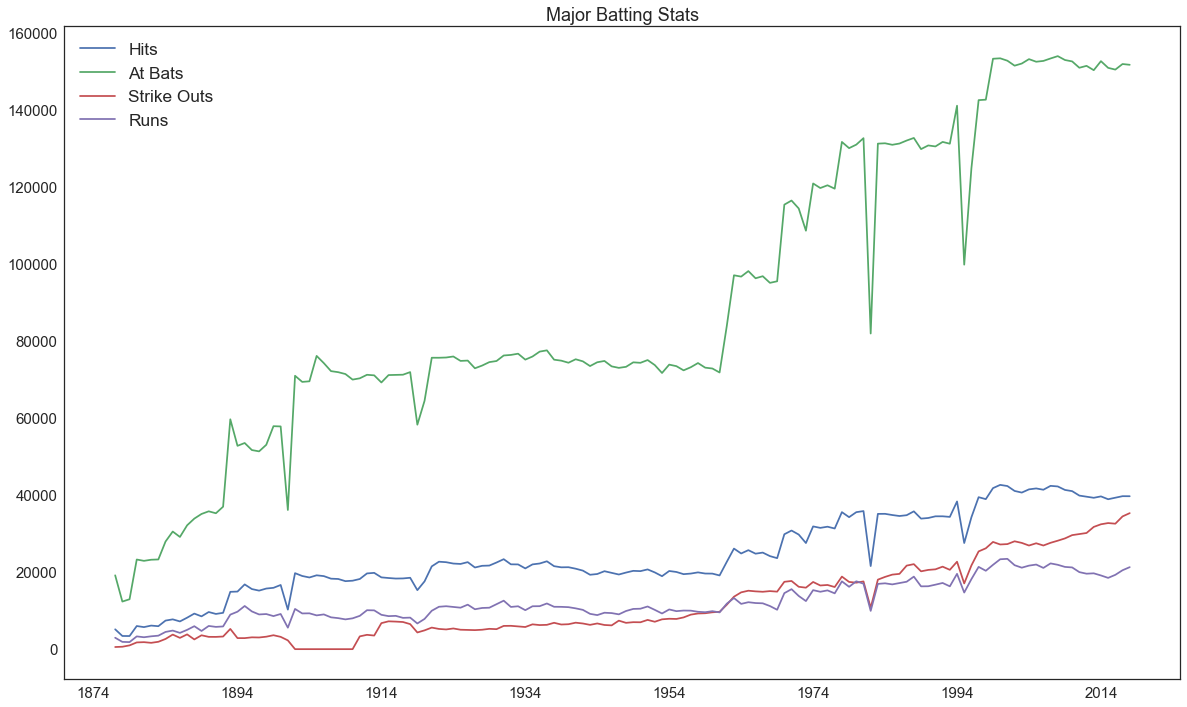

In [586]:
plt.figure(figsize = (20, 12))
plt.plot(batting_test['h'], label='Hits')
plt.plot(batting_test['ab'], label='At Bats')
plt.plot(batting_test['so'], label='Strike Outs')
plt.plot(batting_test['r'], label='Runs')
plt.title(s = "Major Batting Stats", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(axis='both', which='both', direction='inout')
plt.legend(fontsize='xx-large')
plt.show();

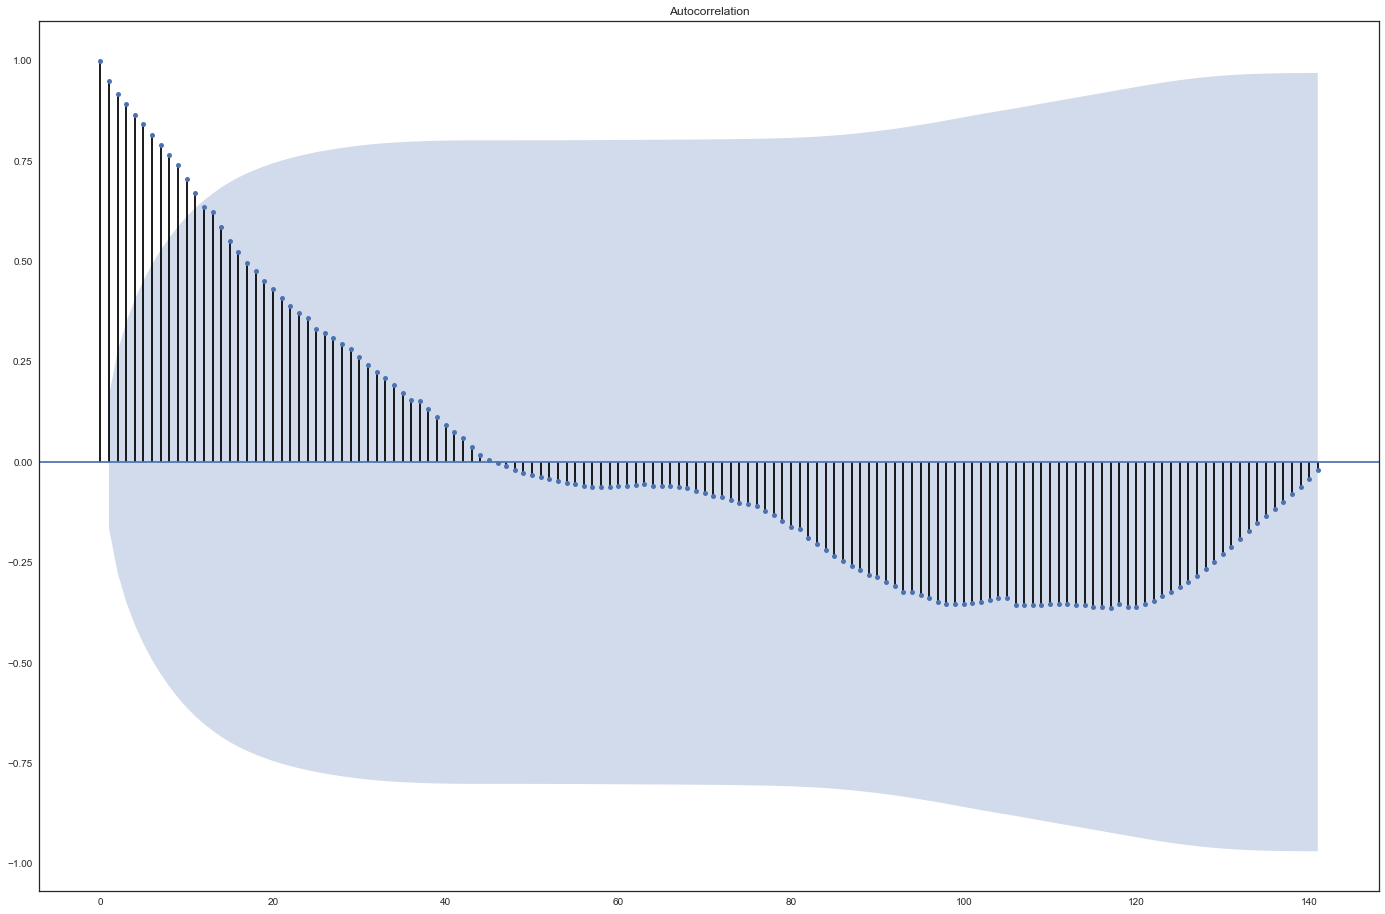

In [418]:
fig, ax = plt.subplots(figsize = (24, 16))
plot_acf(batting_test['h'], lags = 141, ax = ax)

plt.show();

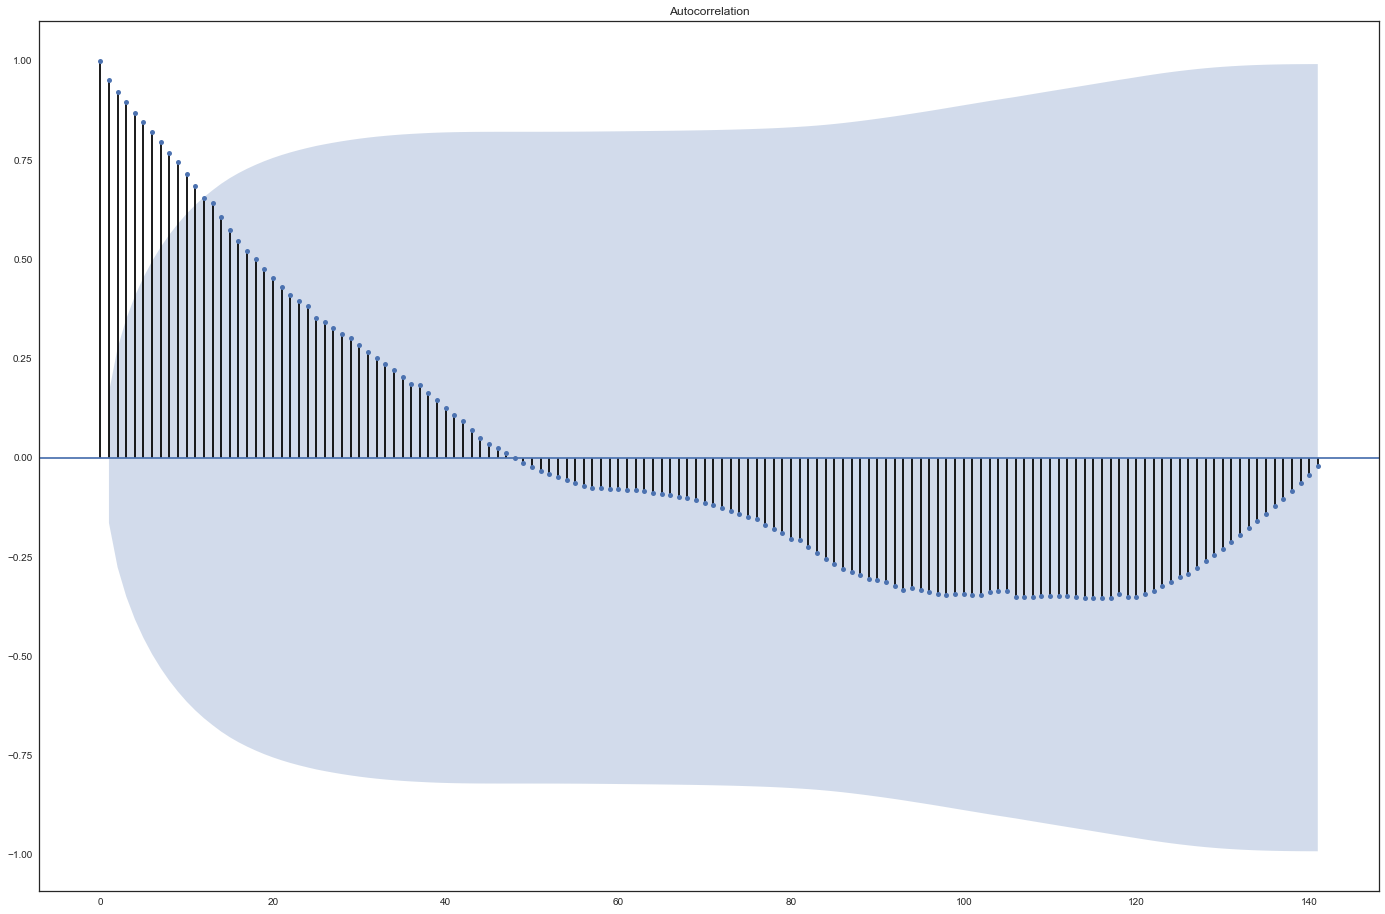

In [584]:
fig, ax = plt.subplots(figsize=(24,16))
plot_acf(batting_test['ab'], lags=141, ax=ax)
plt.show();

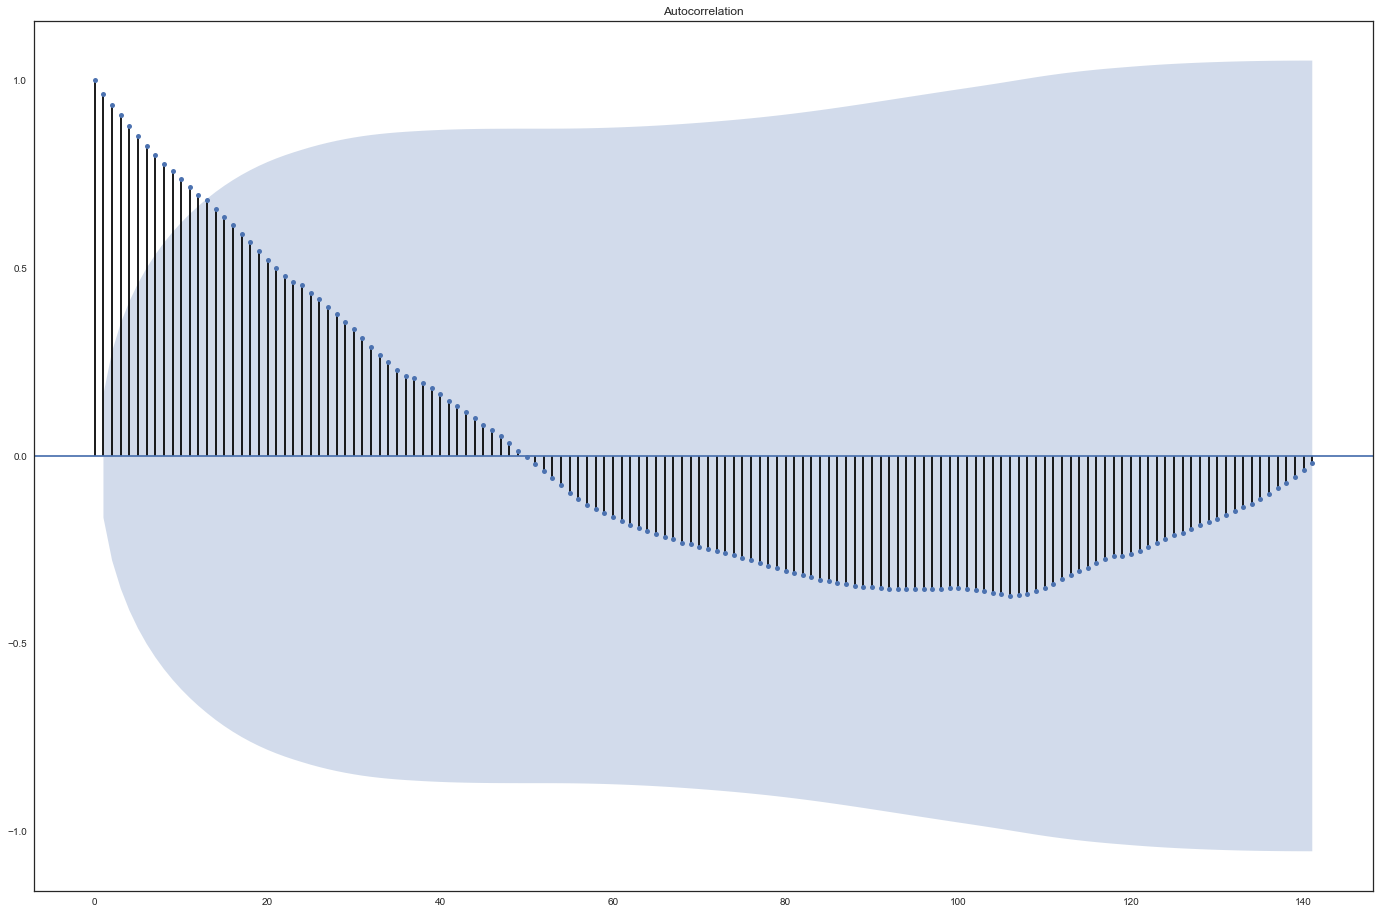

In [585]:
fig, ax =plt.subplots(figsize=(24,16))
plot_acf(batting_test['so'],lags=141, ax=ax)
plt.show();

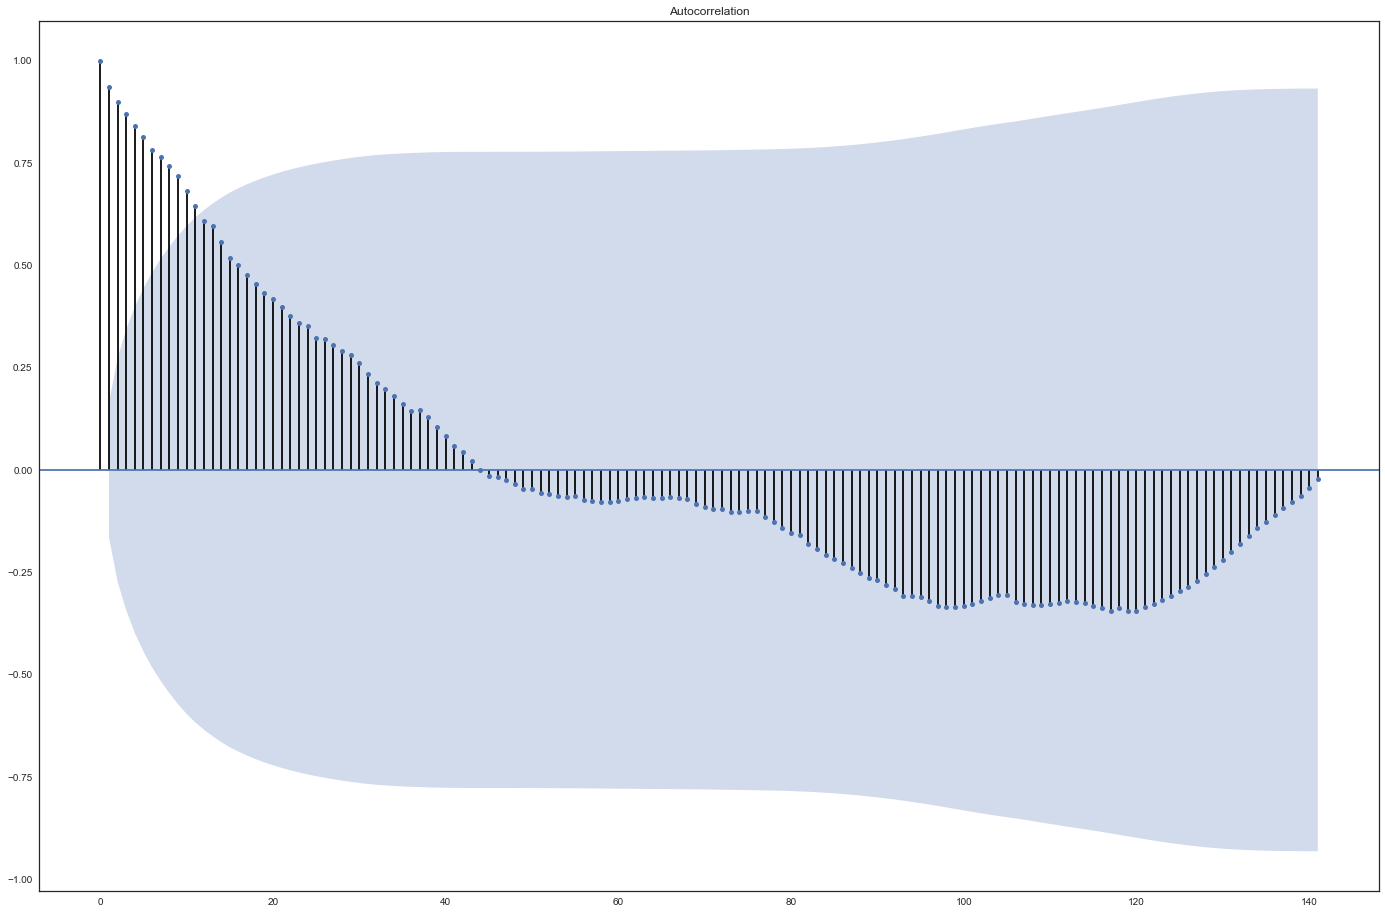

In [587]:
fig,ax=plt.subplots(figsize=(24,16))
plot_acf(batting_test['r'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


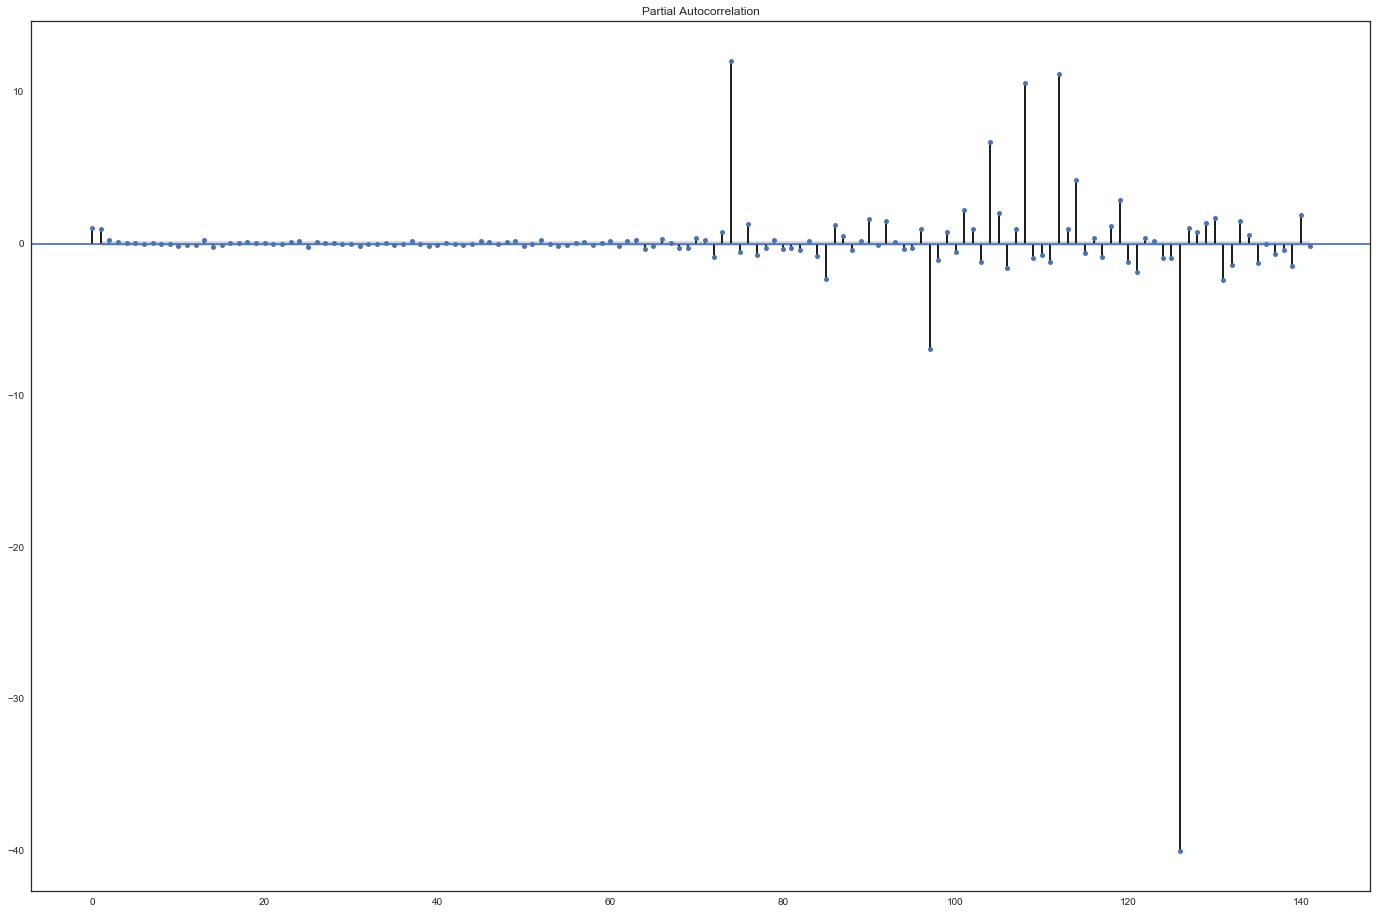

In [420]:
fig, ax = plt.subplots(figsize = (24, 16))
plot_pacf(batting_test['h'], lags = 141, ax = ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


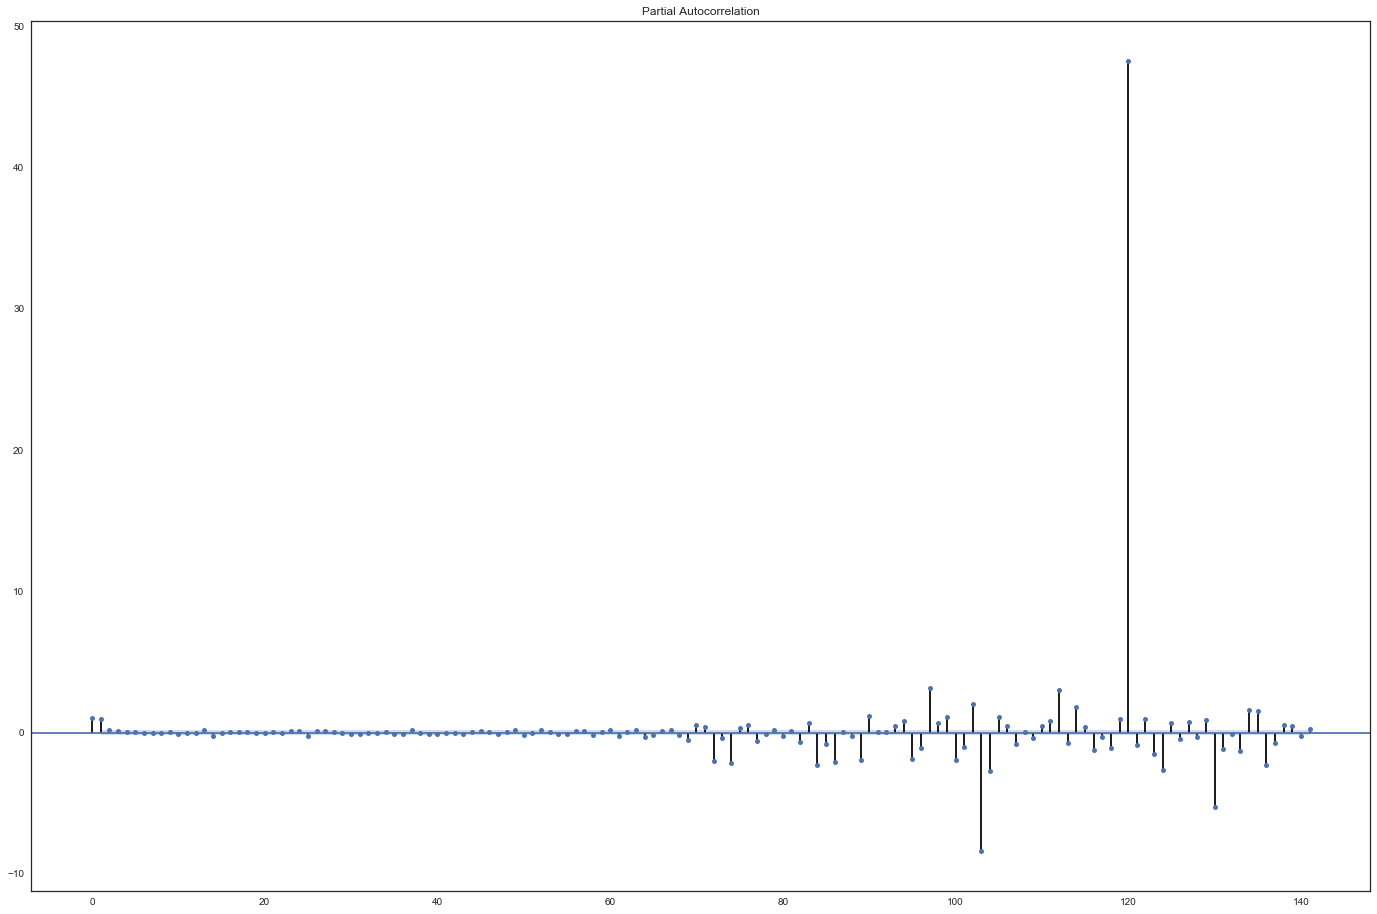

In [588]:
fig, ax = plt.subplots(figsize=(24,16))
plot_pacf(batting_test['ab'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


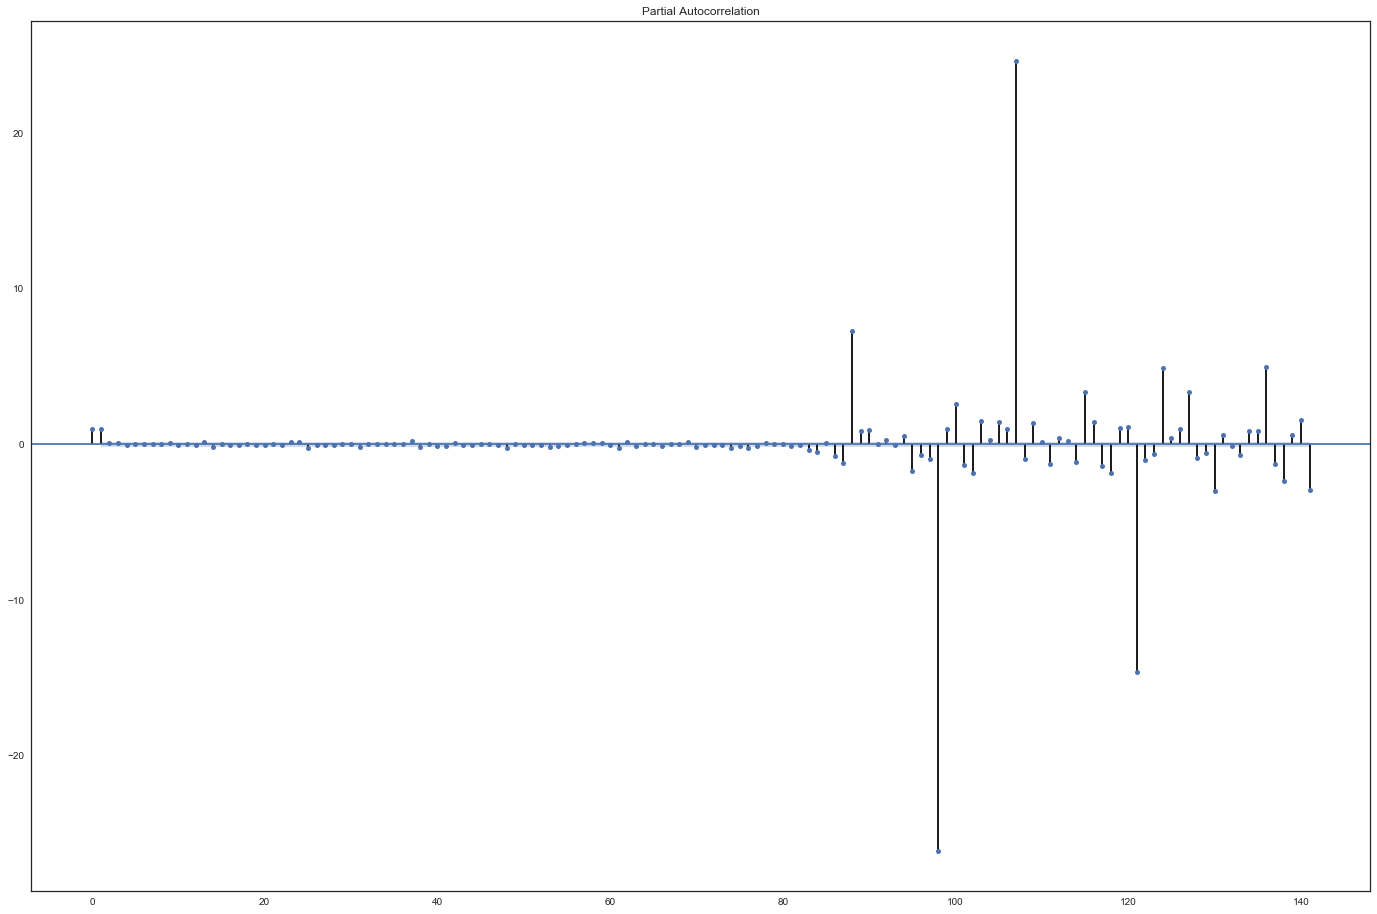

In [589]:
fig,ax = plt.subplots(figsize=(24,16))
plot_pacf(batting_test['so'], lags=141, ax=ax)
plt.show();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


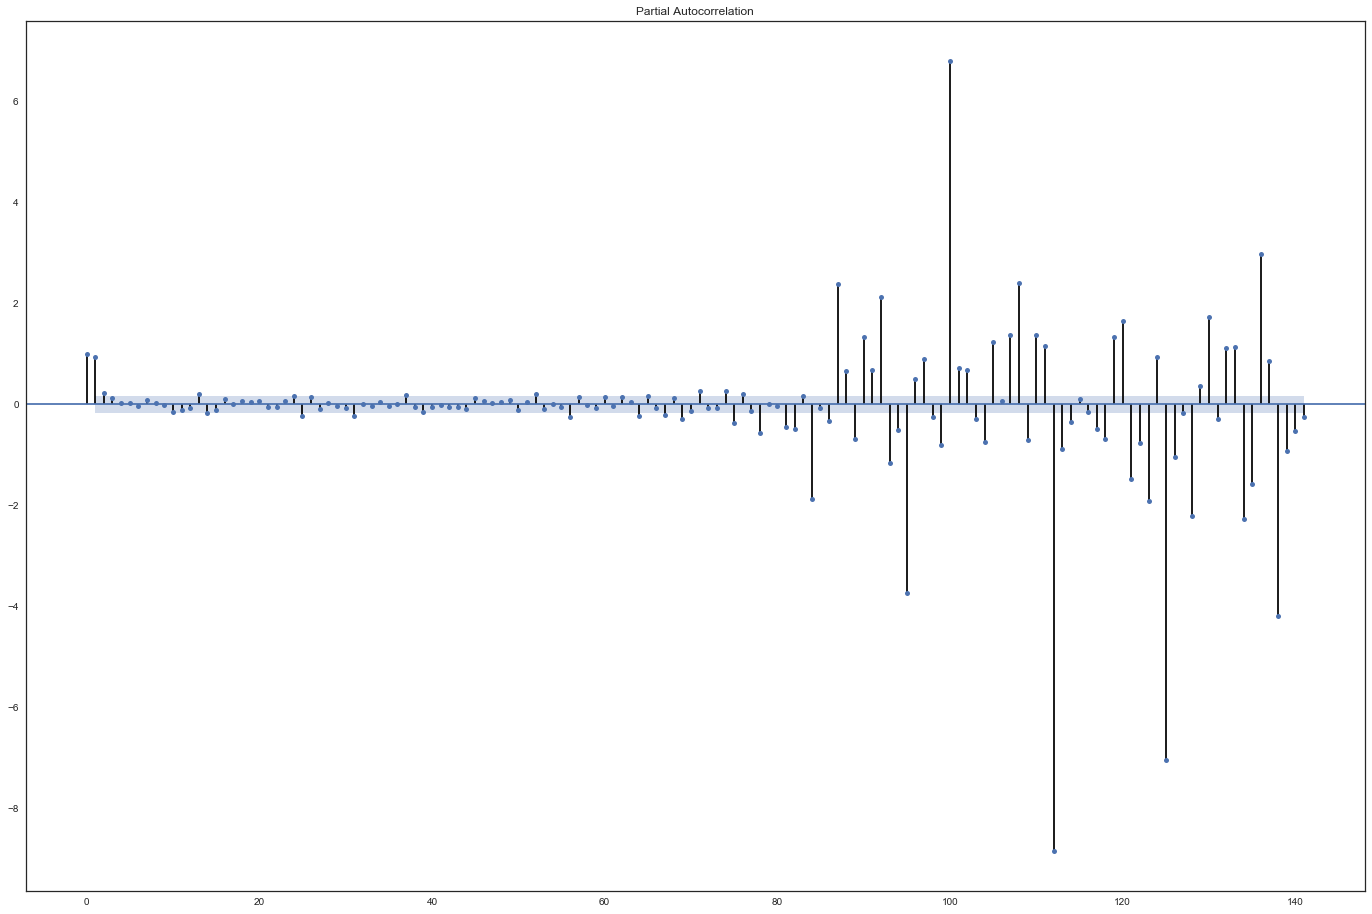

In [590]:
fig,ax=plt.subplots(figsize=(24,16))
plot_pacf(batting_test['r'], lags=141, ax=ax)
plt.show();

### in a loop

In [598]:
for i in range(1,5):
    ar = ARMA(endog = batting_test['h'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds, batting_test['h'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.909178693524152
AR(2) returns an R-squared value of: 0.9204932877637353


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR(3) returns an R-squared value of: 0.8653997869870709
AR(4) returns an R-squared value of: 0.8460048120722204


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [599]:
r2_score(preds[4:], batting_test['h'][4:]) # skips first 4 lines that are always off because no correlated value

0.9426153184566197

In [600]:
for i in range(1,5):
    ar = ARMA(endog = batting_test['ab'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds, batting_test['ab'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.893222129338825


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR(2) returns an R-squared value of: 0.8750774764006335


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR(3) returns an R-squared value of: 0.8653663742217346
AR(4) returns an R-squared value of: 0.8456914731528021


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [601]:
r2_score(preds[4:], batting_test['ab'][4:]) # skips first 4 lines that are always off because no correlated value

0.9502220879558891

In [602]:
for i in range(1,5):
    ar = ARMA(endog = batting_test['so'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds, batting_test['so'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.9674675286376769


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR(2) returns an R-squared value of: 0.9687277590166656
AR(3) returns an R-squared value of: 0.9684430734954343
AR(4) returns an R-squared value of: 0.9687034937401797


In [603]:
r2_score(preds[4:], batting_test['so'][4:]) # skips first 4 lines that are always off because no correlated value

0.9780168683065579

In [608]:
for i in range(1,5):
    ar = ARMA(endog = batting_test['r'],
              order = (i, 0)) # (p, q)
    model = ar.fit()
    preds = model.predict()
    print("AR(" + str(i) + ") returns an R-squared value of: " + str(r2_score(preds, batting_test['r'])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

AR(1) returns an R-squared value of: 0.8832411524485572
AR(2) returns an R-squared value of: 0.8942314399859088
AR(3) returns an R-squared value of: 0.8985437198712377
AR(4) returns an R-squared value of: 0.9001757730782911


In [609]:
r2_score(preds[4:], batting_test['r'][4:]) # skips first 4 lines that are always off because no correlated value

0.9155896892099938

In [610]:
ar_h = ARMA(endog = batting_test['h'], # y variable
          order= (2,0))  # (p,q) <--- talk about q later

In [612]:
model = ar_h.fit()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

In [613]:
preds = model.predict() #generated prediction values. Since autoregression, don't have to pass anything into model

In [614]:
r2_score(preds, batting_test['h'])

0.9204932877637353

In [615]:
batting_test['predicted'] = preds
batting_test[['h', 'predicted']].head(10)

h     predicted
1876-12-31  5145  22932.189050
1877-12-31  3417   5445.380329
1878-12-31  3403   4263.294747
1879-12-31  5997   3616.108552
1880-12-31  5720   5218.814495
1881-12-31  6114   6005.618864
1882-12-31  5956   6147.484482
1883-12-31  7413   6195.134722
1884-12-31  7734   7039.867383
1885-12-31  7194   7777.209686

In [616]:
batting_test[['h', 'predicted']].tail(10)

h     predicted
2008-12-31  41315  42073.398239
2009-12-31  41004  41454.783010
2010-12-31  39847  40926.498587
2011-12-31  39567  40094.420701
2012-12-31  39277  39493.344206
2013-12-31  39640  39210.127029
2014-12-31  38901  39327.973845
2015-12-31  39298  39004.039170
2016-12-31  39696  38977.052019
2017-12-31  39684  39370.444840

In [617]:
np.mean(batting_test['predicted'])

23968.87234724029

In [618]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      h   No. Observations:                  142
Model:                     ARMA(2, 0)   Log Likelihood               -1309.676
Method:                       css-mle   S.D. of innovations           2419.077
Date:                Tue, 16 Oct 2018   AIC                           2627.353
Time:                        16:50:18   BIC                           2639.176
Sample:                    12-31-1876   HQIC                          2632.157
                         - 12-31-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.293e+04   1.14e+04      2.010      0.046     569.755    4.53e+04
ar.L1.h        0.6198      0.078      7.988      0.000       0.468       0.772
ar.L2.h        0.3695      0.078      4.723      0.0

In [ ]:
plt.figure(figsize=(24,16))
plt.plot(batting_test['h'], label='hits')
plt.plot(preds, label='preds')
plt.title('Hits over Time and Predicted Hits', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize='xx-large');

## forecasting

In [536]:
forecast_test = model.forecast(steps=1, # number of out of sample forecast
               exog=None, # only applies if armax
               alpha=0.05 # confidence intervals of the forecast
              )

# returns forecast, std err, and confidence interval range

In [537]:
forecast_test

(array([39510.07054109]),
 array([2419.07692487]),
 array([[34768.76689252, 44251.37418966]]))

In [538]:
forecast_test[0]

array([39510.07054109])

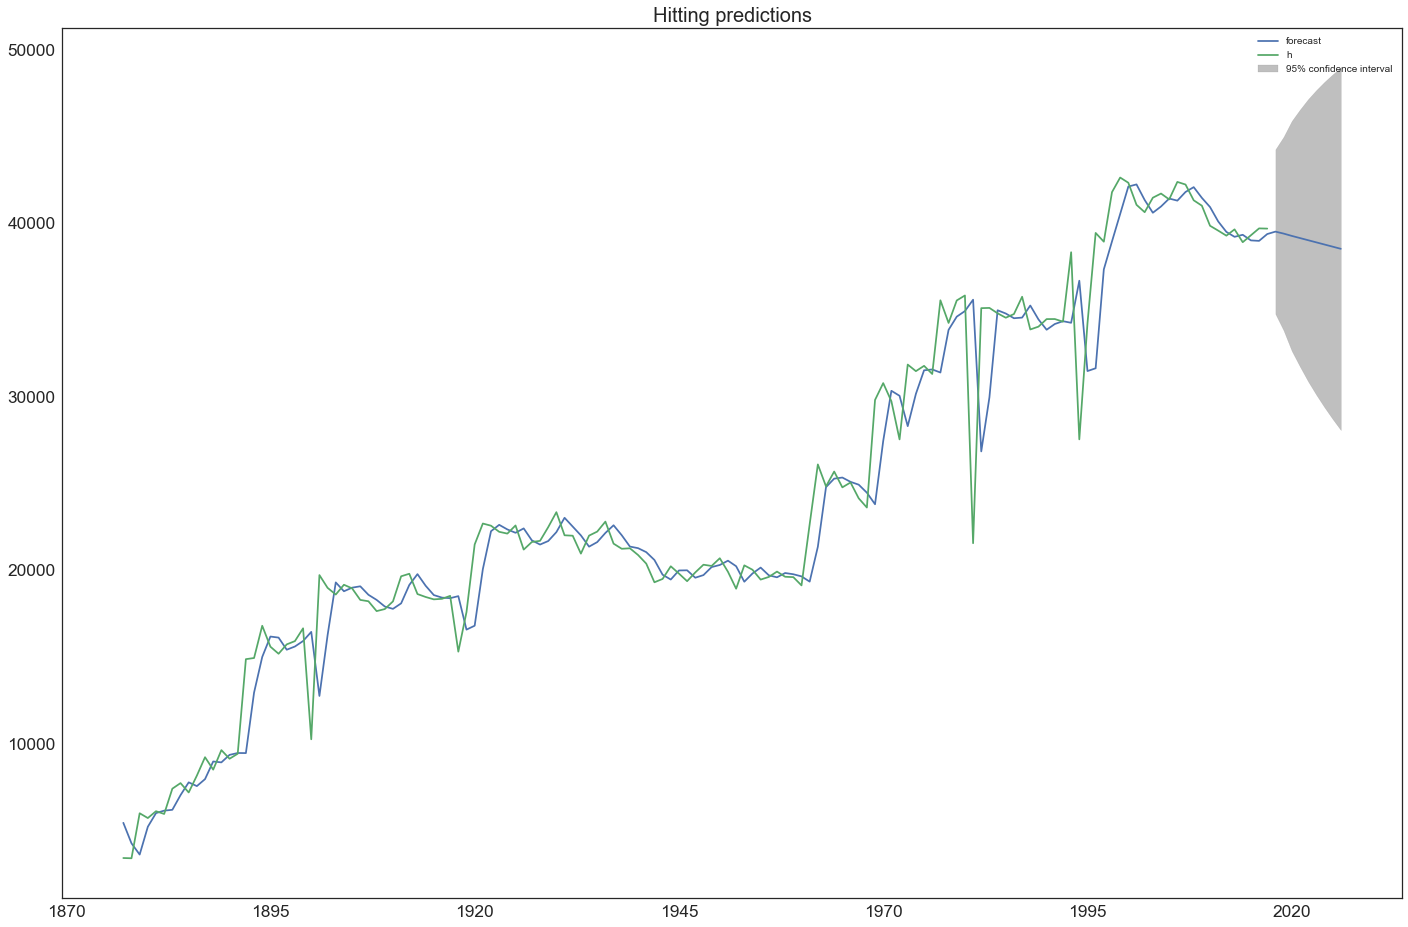

In [582]:
fig, ax = plt.subplots(figsize = (24, 16))
ax.set_title('Hitting predictions', fontsize=20)
ax.tick_params(labelsize='xx-large')
model.plot_predict(start=1, end=150, alpha=0.05, ax = ax)

plt.show();